#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# TAKEAWAY: space derivative depend on nodes granularity. 
# Need increase number of nodes!

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [11]:
node_N=4

In [12]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [21]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [22]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [26]:
# φ, θ, ψ= np.zeros(node_N),np.zeros(node_N),np.zeros(node_N)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[-0.65371631, -0.04652167, -0.75530836],
       [-0.16715713,  0.98233093,  0.08416915],
       [ 0.73804708,  0.18127792, -0.64994217]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001024


In [29]:
Ret

array([[[-0.65371631, -0.04652167, -0.75530836],
        [-0.16715713,  0.98233093,  0.08416915],
        [ 0.73804708,  0.18127792, -0.64994217]],

       [[ 0.57431994,  0.19144307,  0.795931  ],
        [ 0.50393752,  0.68353867, -0.52803586],
        [-0.64513842,  0.70436102,  0.29609454]],

       [[ 0.68929718,  0.71945986,  0.0851288 ],
        [-0.63060825,  0.53798277,  0.5593816 ],
        [ 0.35665478, -0.43926308,  0.82452733]],

       [[ 0.11267651, -0.45963172,  0.88093285],
        [ 0.86695385, -0.38770207, -0.31317427],
        [ 0.48548431,  0.79901551,  0.35479457]]])

In [30]:
Ret.shape

(4, 3, 3)

In [31]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([1.30578402, 0.04646888, 0.17276641, 1.26066777])

In [34]:
C1(dx,dy,dz,Ret)

array([[-1.9736896 , -0.11247795, -0.37300475, -2.08852975],
       [ 0.52971685, -0.39665407, -0.72231874,  1.89131172],
       [ 0.14104371, -0.48199901, -0.07184151, -0.29596008]])

In [35]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000239


In [37]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [38]:
def fD(dx,dy,dz,DT,Ret):
#     print(dx)
#     print(C1(dx,dy,dz).shape) m2*kg/m3 N/m m2/s2*rad
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret)

array([[-11327.07156945,   -645.51479327,  -2140.68692885,
        -11986.14311978],
       [  3040.06296381,  -2276.41116798,  -4145.41176228,
         10854.30212511],
       [   809.45462799,  -2766.20864792,   -412.30088931,
         -1698.52494093]])

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[-11327.07156945,   3040.06296381,    809.45462799],
       [  -645.51479327,  -2276.41116798,  -2766.20864792],
       [ -2140.68692885,  -4145.41176228,   -412.30088931],
       [-11986.14311978,  10854.30212511,  -1698.52494093]])

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000476


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000217


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
dI= 0.69# Inner diameter of pipe, [m]

In [51]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [52]:
Ar

0.08091250419136858

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [54]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [55]:
from numpy import linalg as LA

In [56]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [57]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [58]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [59]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000150


In [60]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[8964.69710988],
       [8964.69710988],
       [8964.69710988],
       [8964.69710988]])

In [61]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.000795


In [62]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [63]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.000868


In [64]:
# # angles should be in radians, otherwise np.radians them  
# def Re_t_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
  
#     Cφ=np.matrix([[1,0,0],
#                       [0,np.cos(φ),-np.sin(φ)],
#                       [0,np.sin(φ),np.cos(φ)]])

#     Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
#                       [0,1,0],
#                       [-np.sin(θ),0,np.cos(θ)]])

#     Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
#                       [np.sin(ψ),np.cos(ψ),0],
#                       [0,0,1]])
        

#     return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [65]:
# Re_t_([1,2,3])

In [66]:
# φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [67]:
# def Re_t(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
# #     print(Re_t_(xyz[0]))
#     return np.apply_along_axis(Re_t_, 1, xyz)

In [68]:
# φ, θ, ψ

In [69]:
# Re_t_(np.array([φ[0], θ[0], ψ[0]]))

In [70]:
# startTime1 = datetime.now()
# Ret=Re_t(φ,θ,ψ)
# print(datetime.now() - startTime1)

In [71]:
# Ret

In [72]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [73]:
# Fossen paper, equation (12)

In [74]:
# φ,θ,ψ=1,2,3

In [75]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [76]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000194


In [77]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [78]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [79]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [80]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [81]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000387


In [82]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [83]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [84]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [85]:
def ne_(x,y,z,dx,dy,dz,Ret):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [86]:
sigma(x,y,z)

array([[     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        , 116269.92391411],
       [     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ]])

In [87]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[ 11327.07156945,    645.51479327,   2140.68692885,
         11986.14311978],
       [ -3040.06296381,   2276.41116798,   4145.41176228,
        -10854.30212511],
       [  -937.61917022,   2638.04410569,    284.13634708,
          1570.3603987 ]])

In [88]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [89]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000936


In [90]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000214


In [91]:
Re_b(Ret).shape

(4, 3, 3)

In [92]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [93]:
Irho_e(Ret)

array([[[ 42.73450087,   0.        ,   0.        ],
        [  0.        ,  96.49740479,   0.        ],
        [  0.        ,   0.        ,  84.48496583]],

       [[ 32.98433927,   0.        ,   0.        ],
        [  0.        ,  46.72251095,   0.        ],
        [  0.        ,   0.        ,  17.53439513]],

       [[ 47.51306039,   0.        ,   0.        ],
        [  0.        ,  28.94254636,   0.        ],
        [  0.        ,   0.        , 135.96906361]],

       [[  1.26959952,   0.        ,   0.        ],
        [  0.        ,  15.03128937,   0.        ],
        [  0.        ,   0.        ,  25.17583784]]])

In [94]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000183


In [95]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
#                   [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
#                   [-np.sin(θ),0,1]])
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [96]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [97]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000512


In [98]:
def ωe(φ,θ,ψ,x,y,z):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
#     B=np.array([φ,θ,ψ]).T
    B=d_s(φ,θ,ψ,x,y,z).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [99]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [100]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,x,y,z)
print(datetime.now() - startTime1)

0:00:00.001075


In [101]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [102]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [103]:
def me(φ,θ,ψ,x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ,x,y,z)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [104]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000734


In [105]:
me_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.09046106e+07,  6.34036358e+08, -2.83202184e+07],
       [-9.50418696e+08, -3.80794812e+08, -2.09137747e+08],
       [ 2.19157090e+07, -5.37489775e+07, -4.31119389e+07]])

In [106]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [107]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [108]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[ 11327.07156945,    645.51479327,   2140.68692885,
         11986.14311978],
       [ -3040.06296381,   2276.41116798,   4145.41176228,
        -10854.30212511],
       [  -937.61917022,   2638.04410569,    284.13634708,
          1570.3603987 ]])

In [109]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [110]:
d_s(a,b,c,x,y,z)

array([[       0.        ,  -482425.77935289,  4935897.3553353 ,
        -2452964.41471804],
       [       0.        ,  1068960.6253818 , -5408255.78066616,
         1739110.60787107],
       [       0.        ,   253000.33129501, -4430456.35093231,
         1632425.19309417]])

In [111]:
Re_b(Ret).shape

(4, 3, 3)

In [112]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[ 11327.07156945,  -3040.06296381,   -937.61917022],
       [   645.51479327,   2276.41116798,   2638.04410569],
       [  2140.68692885,   4145.41176228,    284.13634708],
       [ 11986.14311978, -10854.30212511,   1570.3603987 ]])

In [113]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([-12.43228144, 133.2818667 ,  79.31659439,  94.67832926]),
 array([-149.63474612,   34.15720332,   -4.12313352, -113.37519675]),
 array([ 1.14270907,  0.21556641,  0.41565179, -1.12279462]),
 numpy.ndarray,
 array([ 1.14915079, -0.02865975, -0.55429899, -1.59284361]))

In [114]:
ne_(x,y,z,dx,dy,dz,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz,Ret).T)

array([[ 4772.00060548, -7998.73022012,  7480.59480724],
       [ 3551.75104384,  2764.74346427,  4606.123444  ],
       [ 6622.90192868,  5184.57767846,  -539.02558349],
       [19709.0634383 ,  3253.56977063,  -726.15557554]])

In [115]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[ 11327.07156945,  -3040.06296381,   -937.61917022],
       [   645.51479327,   2276.41116798,   2638.04410569],
       [  2140.68692885,   4145.41176228,    284.13634708],
       [ 11986.14311978, -10854.30212511,   1570.3603987 ]])

### Catenary

In [116]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [117]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [118]:
Fx_0=82945396

In [119]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [120]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [121]:
delta_x=horizontal_length/(node_N-1)

In [122]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [123]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

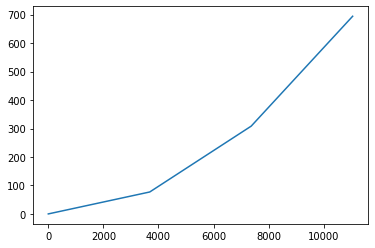

In [124]:
plt.plot(x0, z0)
plt.show()

In [125]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [126]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
# #     elif j==7 or j==9 or j==11: 
#     elif j==9 or j==11: 
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
# #         q0[(j-1)*node_N:j*node_N]=np.array([0.01 for x in range(node_N)])

In [127]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [128]:
q0[node_N*6]=0

In [129]:
q0[node_N*8]=0

In [130]:
q0[node_N*10]=0

### Vessel

In [131]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)

    def eq_left(self,η, dη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)

        return (np.matmul(self.D, dη) + np.dot(C,self.G))
        
    def tau(self,η, dη, ddη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
#         print(Π_([φ,θ,ψ]))
#         print(Re_b(Ret))
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)
#         print(np.dot(C,self.G))
#         print(np.matmul(self.M,ddη))
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(C,self.G))
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [132]:
V=VesselSemisub()

In [133]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [134]:
tau_force = V.tau(η,dη, ddη)

In [135]:
tau_force

array([ 3.38785484e+06, -2.37412183e+06,  4.34580086e+06, -1.36399445e+10,
        3.02038732e+10,  1.28049082e+10])

In [136]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [137]:
sampleTime = 1e-5                # sample time [seconds]
N = int(2e5)                         # number of samples

In [138]:
N

200000

In [139]:
# vehicle_1=semisub('DPcontrol',0.,5.,30.0,0,0) 

In [140]:
# [simTime_1, simData_1] = simulate(N, sampleTime, vehicle_1)

In [141]:
# vehicle_2=semisub('DPcontrol',0.,-5.,30.0,0,0) 

In [142]:
# [simTime_2, simData_2] = simulate(N, sampleTime, vehicle_2)

In [143]:
# simData_1.shape

In [144]:
# simData=np.concatenate([simData_1,simData_2], axis=0)
# simData=simData_1

In [145]:
# simData.shape

In [146]:
# ans_t = simTime_1

In [147]:
# simData[250]

In [148]:
# simData.shape

In [149]:
# ans_t=[]
# sum_=0
# for i in range(simData.shape[0]):
#     ans_t.append(sum_)
#     sum_+=sampleTime

In [150]:
# plotVehicleStates(simTime_1, simData_1, 1)                    
# plotControls(simTime_1, simData_1, vehicle_1, 2)

In [151]:
# plotVehicleStates(simTime_2, simData_2, 1)                    
# plotControls(simTime_2, simData_2, vehicle_2, 2)

In [152]:
# numDataPoints = 5                 # number of 3D data points
# FPS = 10                            # frames per second (animated GIF)
# filename = '3D_animation.gif'       # data file for animated GIF
# browser = 'safari'                  # browser for visualization of animated GIF

In [153]:
# plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [154]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

In [155]:
# simData[1]

In [156]:
# simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
# simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [157]:
# diff_1=np.diff(simD_1,axis=0)
# diff_2=np.diff(simD_2,axis=0)

In [158]:
# diff=np.concatenate([diff_1,diff_2], axis=0)

In [159]:
# diff=diff_1

In [160]:
V=VesselSemisub()

In [161]:
# thres =0.1

In [162]:
# def retrieve_name(var):
#     callers_local_vars = inspect.currentframe().f_back.f_locals.items()
#     return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [163]:
# simD=np.concatenate([simD_1,simD_2], axis=0)

In [164]:
# simD = simD_1

In [165]:
# SD0=simD[:, 0]
# SD1=simD[:, 1]
# SD2=simD[:, 2]
# SD3=simD[:, 3]
# SD4=simD[:, 4]
# SD5=simD[:, 5]
# SD6=simD[:, 6]
# SD7=simD[:, 7]
# SD8=simD[:, 8]
# SD9=simD[:, 9]
# SD10=simD[:, 10]
# SD11=simD[:, 11]
# Diff6=diff[:, 6]
# Diff7=diff[:, 7]
# Diff8=diff[:, 8]
# Diff9=diff[:, 9]
# Diff10=diff[:, 10]
# Diff11=diff[:, 11]

In [166]:
# def feedback(Q):
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

#     K = 2e6 # feedback gain
#     u_x = -K * x 
#     u_y = -K * y
#     u_z = -K * z 
#     u_dx = -K * dx 
#     u_dy = -K * dy 
#     u_dz = -K * dz 
#     u_φ = -K * φ 
#     u_θ = -K * θ
#     u_ψ = -K * ψ 
#     u_dφ= -K * dφ 
#     u_dθ = -K * dθ 
#     u_dψ = -K * dψ 
#     return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [167]:
# def Jv(x, y, z):
    
#     def Jv0(k,x0,x1,y0,y1,z0,z1):
#         tmp1=(x0+x1)/2 
#         tmp2=(y0+y1)/2
#         tmp3=(z0+z1)/2 
#         return np.array([tmp1, tmp2, tmp3]).T 
# #         else:
# #             return np.array([0, 0, 0]).T 
    
#     ans=np.array([Jv0(k, x[k-1],x[k], y[k-1], y[k], z[k-1], z[k]) for k in range(1,node_N)])
    
#     return np.concatenate([ans,np.array([0, 0, 0]).reshape(3,1).T], axis=0).T

In [168]:
# x, y, z = q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [169]:
# q0

In [170]:
# Jv(x, y, z )

In [171]:
# class Time:
#     def __init__(self):
#         self.time=1
# # #         self.n=1
# # # #         self.my_max = sampleTime*N*2
# #         self.my_time=0
# # # #         self.my_n=0
# #         self.my_update=up

In [172]:
# co=Time()

In [173]:
# def asymptote(t):
#     return t/np.sqrt(t**2+1)

In [174]:
from scipy.integrate import solve_ivp

In [333]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     Q,t=np.array(Q),np.array(t)
    print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
  
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
#     co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
#     idx = find_nearest(ans_t,  co.my_time%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
#     idx = find_nearest(ans_t,  t%len(ans_t)) 
#     print('idx',idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
#     x_ve = SD0[idx]
#     y_ve = SD1[idx]
#     z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(SD3[idx]))
#     theta_ve = R2D(ssa(SD4[idx]))
#     psi_v = R2D(ssa(SD5[idx]))
#     phi_ve = ssa(SD3[idx])
#     theta_ve = ssa(SD4[idx])
#     psi_v = ssa(SD5[idx])
#     phi_ve = SD3[idx]
#     theta_ve = SD4[idx]
#     psi_v = SD5[idx]
#     u_ve = SD6[idx]
#     v_ve = SD7[idx]
#     w_ve = SD8[idx]
#     p_ve = SD9[idx]
#     q_ve = SD10[idx]
#     r_ve = SD11[idx]
#     p_ve = ssa(SD9[idx])
#     q_ve = ssa(SD10[idx])
#     r_ve = ssa(SD11[idx])
    
    
#     print(t-co.time)
#     du_ve = Diff6[idx]/sampleTime
#     dv_ve = Diff7[idx]/sampleTime
#     dw_ve = Diff8[idx]/sampleTime
#     dp_ve = Diff9[idx]/sampleTime
#     dq_ve = Diff10[idx]/sampleTime
#     dr_ve = Diff11[idx]/sampleTime
#     print(u_ve, dr_ve )
    
#     co.time=t
#     co.n+=1
#     print(co.time)
#     η=np.array([ x_ve, y_ve, z_ve,phi_ve, theta_ve,  psi_v])
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
#     print( dη)
#     print(ddη)
    
#     tau_force = V.tau(η,dη, ddη)*asymptote(t)
#     tau_force = V.tau(η,dη, ddη)
#     co.time += 1
#     print(tau_force )
#     print()
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]

#     print( x[-1], y[-1], z[-1])
    x[0]=0
    y[0]=0
    z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
    dx[0]=0
    dy[0]=0
    dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
  
    
    
    
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
    ddη=np.linalg.lstsq(V.M, left, rcond=None)[0]
 
    tau_force = V.tau(η,dη,ddη)
    print(η,dη,ddη)
#     print(tau_force)
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
#     Z0=np.zeros((node_N,3))
#     print(tau_force[:3].shape)
#     Z0[-1]=tau_force[:3]
#     print(Z0)
#     Z0=np.dot(Jv(x, y, z ).T,tau_force[:3]).reshape(node_N,1)
#     print(Z0)
#     print()
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z0=tau_force[:3]
#     print(Z0)
#     Z0=tau_force[:3].T
#     print(Z0)
    Z1 = d_s(a,b,c,x,y,z).T
#     print(Z1.shape)
#     Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz,Ret).T)
#     print(Z1,Z2)
    Z2=ne_(x,y,z,dx,dy,dz,Ret).T
#     print(Z0)
#     Z=(np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) 
    Z= ( Z1 + Z2 
        - Z0 
       )
#     print(Z1,Z2, - Z0,Z)
#     print()
#     print(Z0,Z1,Z2)
#     print(Z)
    
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
#     ddx,ddy, ddz = 1/Ws*torch.linalg.lstsq(torch.from_numpy(Re_b(Ret).astype(np.float64)),torch.from_numpy(Z.astype(np.float64))).solution.cpu().numpy().T
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
    
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,x,y,z,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
#     C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
#     C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
#     C3=np.einsum('ijk,ik->ij', Re_b(Ret),C3_)
#     print(C3.shape)
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
#     C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
    C5= -np.dot(DR,K1).astype(np.float32).T
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
#     print(C5.shape)    
#     C0=np.zeros((node_N,3))
#     C0[-1]=tau_force[3:]
#     print(Π(φ,θ,ψ).shape)
#     print(Re_b(Ret).shape)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),Re_b(Ret)).shape)
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(tau_force[3:])
#     print(C0.shape)
#     .reshape(node_N,3)
#     print(np.einsum('ijk,ikr->ijr',Π(φ,θ,ψ),Re_b(Ret)).shape)
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    
    B_ =(-C1-C2+C3+C4+C5)
    B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       -C0.squeeze()
      )
#     print(B.shape,C0.squeeze().shape)
#     print(B.shape)
#     print(C0, C0.squeeze())
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
#     A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
#     A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     print(B,A)    
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    
#     print(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0) 
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)

#     return A1111+feedback(Q)
#     print(φ,θ,ψ)
#     print(Ret)
#     if np.isnan(np.sum(φ)):     
#         print('φ',np.isnan(np.sum(φ)))
#     if np.isnan(np.sum(θ)):     
#         print('θ',np.isnan(np.sum(θ)))
#     if np.isnan(np.sum(ψ)):     
#         print('ψ',np.isnan(np.sum(ψ))) 
#     print(A1111)
    return A1111

In [334]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [335]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [336]:
# q0.shape

In [337]:
# import numpy as np

In [338]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [339]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [340]:
# grayscott1d(4,q0)

In [341]:
# grayscott1d(4,q0).shape

In [342]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [343]:
import scipy

In [344]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [345]:
tspan = (0., 2)

In [346]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [348]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, method='BDF',rtol=1000, atol=1000)
# us=ode15s.integrate(3)
print(datetime.now() - startTime1)

0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [ 1.00762082e+01 -5.06891182e+00 -3.97278206e-02  3.90794979e-01
  5.64781099e-01  4.70760156e-04]
2.0448891831606505e-11
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [-2.0389526109890477e-11, 7.95314981777367e-20, -2.603211387622655e-07, -0.005846747152492887, -0.010720127053801393, 1.429557443082063e-17] [ 1.00494877e+01 -5.05953458e+00 -3.96368212e-02  3.90028261e-01
  5.63167308e-01  4.70008865e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [ 1.00762082e+01 -5.06891182e+00 -3.97278206e-02  3.90794979e-01
  5.64781099e-01  4.70760156e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [ 1.00762082e+01 -5.06891182e+00 -3.97278206e-02  3.90794979e-01
  5.64781099e-01  4.70760156e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [ 1.0

4.089778366321301e-09
[11052.68484446162, 4.2399216438130384e-14, 694.4218951076863, -1.7268041050725316e-09, -2.968497342471672e-09, -9.981705664499291e-14] [-5.3589259720329334e-05, 2.4570070541195342e-05, -4.134666039246801e-05, -1.0006717632239497, -1.7202249294467398, -5.784333600977537e-05] [ 5.78844375e+00 -3.46399652e+00 -2.51254089e-02  2.59571015e-01
  3.05821191e-01  3.41452785e-04]
4.089778366321301e-09
[11052.68484446162, 8.788221264272272e-14, 694.4218951076863, -2.5810101425045016e-09, -4.345276232802468e-09, -2.060419312959903e-13] [-7.844183776591468e-05, 3.672421925839262e-05, -3.6375892356711e-05, -0.917231223255875, -1.52366772827369, -8.5963095815407e-05] [ 6.27837418e+00 -3.59782156e+00 -2.67938998e-02  2.70513064e-01
  3.35410598e-01  3.51822787e-04]
2.453867019792781e-08
[11052.684844461619, 7.547082568151839e-13, 694.4218951076855, -1.9757091034492226e-08, -3.2955551848254005e-08, -1.767383719796535e-12] [-0.0005949139183171908, 0.0002811160590991884, -0.000193

0.004544197730381628
[11052.168589353432, 0.1729245113705702, 694.4224296894331, -0.01352868058875066, -0.017304944610778104, 0.0008094136213246369] [-261.4562049014163, 76.46396288529496, 0.1713852039856224, -3.026490339894351, -3.98551267159551, 0.4215003191462231] [-2.09410479e+00  5.15390526e-02  3.88164945e-03 -1.00169045e-03
 -2.71734548e-02  8.00496524e-05]
0.004544197730381628
[11052.168589353432, 0.1729245113705702, 694.4224296894331, -0.01352868058875066, -0.017304944610778104, 0.0008094136213246369] [-261.4562049014163, 76.46394798413377, 0.1713852039856224, -3.026490339894351, -3.98551267159551, 0.4215003191462231] [-2.09410479e+00  5.15390026e-02  3.88164945e-03 -1.00169159e-03
 -2.71734548e-02  8.00496810e-05]
0.004544197730381628
[11052.168589353432, 0.1729245113705702, 694.4224296894331, -0.01352868058875066, -0.017304944610778104, 0.0008094136213246369] [-261.4562049014163, 76.46396288529496, 0.1713852039856224, -3.026490339894351, -3.98551267159551, 0.4215003191462231

0.02499308956198814
[11050.138084272234, 1.145552811799981, 694.4248439056136, -0.07456517049357059, -0.0948734384390493, 0.008870262490109783] [360.9459838118844, 67.95924896922217, -0.01123672954352703, -2.9614308186316145, -3.2662616774092372, 2.2345380420558514] [ 5.12471941e+00  5.97670430e-02 -1.24158479e-02 -4.00684962e-03
  6.86807941e-02 -4.60821439e-04]
0.02499308956198814
[11050.138084272234, 1.145552811799981, 694.4248439056136, -0.07456517049357059, -0.0948734384390493, 0.008870262490109783] [360.9459838118844, 67.95924896922217, -0.01123672954352703, -2.9614308186316145, -3.2662616774092372, 2.2345380420558514] [ 5.12471941e+00  5.97670430e-02 -1.24158479e-02 -4.00684962e-03
  6.86807941e-02 -4.60821439e-04]
0.02499308956198814
[11050.138084272234, 1.145552811799981, 694.4248439056136, -0.07456517049357059, -0.0948734384390493, 0.008870262490109783] [360.9459838118844, 67.95924896922217, -0.01123672954352703, -2.9614308186316145, -3.2662616774092372, 2.2345380420558514] [

0.04544198139359465
[11055.595316455972, 2.4836552853610923, 694.5464528943098, -0.11879210384388238, -0.1700240597454393, 0.1104075320801584] [125.66654718766972, 64.8905590951199, 5.089368829052446, -2.290558313335799, -3.791177596023025, 3.7354043788027553] [ 2.37968368e+00  7.79540272e-02  3.39924450e-01 -1.46549785e-03
  2.95919616e-02 -4.97362214e-04]
0.24993089970965973
[11069.139863789751, 13.694209266134429, 695.1789228495547, -0.600331931473701, -0.9519327594296192, 0.8213280582251695] [20.60759509173411, 118.21978599826573, 20.9771982002299, 2.373117615429625, -5.506597990850649, 19.68479947957888] [-4.13801773  4.17574958  1.43698087 -0.26522707 -0.29584035  0.0966677 ]
0.24993089970965973
[11069.095338444415, 270.0262450123963, 646.1862085088226, 3.0555834372468387, 4.609504724062111, 7.382000373153637] [70.32458408173204, 1540.9519287535566, -280.68566693306207, 18.82984033178055, 28.408774612957842, 41.49263426152934] [ 62.39295292 -31.61590233 -19.96446482   3.09463863 

0.24993089970965973
[11069.139863789751, 13.694209266134429, 695.1789228495547, -0.600331931473701, -0.9519327594296192, 0.8213280582251695] [20.60759509173411, 118.21978599826573, 20.9771982002299, 2.373117615429625, -5.506597990850649, 19.68479947957888] [-4.13801773  4.17574958  1.43698087 -0.26522707 -0.29584035  0.0966677 ]
0.24993089970965973
[11069.139863789751, 13.694209266134429, 695.1789228495547, -0.600331931473701, -0.9519327594296192, 0.8213280582251695] [20.60759509173411, 118.21978599826573, 20.9771982002299, 2.373117615429625, -5.506597990850649, 19.68479947957888] [-4.13801773  4.17574958  1.43698087 -0.26522707 -0.29584035  0.0966677 ]
0.24993089970965973
[11069.139863789751, 13.694209266134429, 695.1789228495547, -0.600331931473701, -0.9519327594296192, 0.8213280582251695] [20.60759509173411, 118.21978599826573, 20.9771982002299, 2.373117615429625, -5.506597990850649, 19.68479947957888] [-4.13801773  4.17574958  1.43698087 -0.26522707 -0.29584035  0.0966677 ]
0.24993

0.1476864405516272
[11029.190012761954, 16.617503164912822, 699.5159210764605, -1.782196717485617, -1.6393127777949674, -1.7664038682205765] [-308.7905811055333, 155.20147730283725, 57.30953588111756, -18.84541397674259, -16.312021855313148, -22.400864850764144] [-32.22099568  25.78807563   4.01365853  -2.07770688  -1.81767368
  -0.32465385]
0.09656421097261092
[11058.314843291657, 5.178611219722997, 694.6844792927029, -0.23900740865635084, -0.3661648894473454, 0.2885376544496681] [60.77219275955119, 71.98273136100298, 7.89706053136535, -1.1148081024297465, -4.2584910582342355, 7.745932362988292] [ 1.56281345e+00  7.05072700e-01  5.18082882e-01 -3.88260380e-02
  1.32560047e-02 -1.40888359e-04]
0.09656421097261092
[11055.662330168378, -3.86723504126609, 692.4557648651793, 0.42528937569738345, -0.025715893969836756, 1.488556437633818] [9.098041826107924, -154.15592049426624, -48.43708949484695, 13.04227509918814, 4.0721248798107785, 31.290087942257916] [ 17.2426251  -12.69289345  -3.4663

0.05822253878834871
[11053.668394379498, 2.824164071349249, 694.5232247601184, -0.1450591122006596, -0.22224785210754822, 0.16464287539352263] [-292.78068430446547, 12.653396244603847, -4.06971250676934, -1.7636938460614466, -4.264551158476893, 4.906714594870875] [-2.1064953  -0.28178258 -0.31476132  0.01265836 -0.01337537  0.00302389]
0.05822253878834871
[11053.668394379498, 2.824164071349249, 694.5232247601184, -0.1450591122006596, -0.22224785210754822, 0.16464287539352263] [-292.78068430446547, 12.653396244603847, -4.06971250676934, -1.7636938460614466, -4.264551158476893, 4.906714594870875] [-2.1064953  -0.28178258 -0.31476132  0.01265836 -0.01337537  0.00302389]
0.05822253878834871
[11053.668394379498, 2.824164071349249, 694.5232247601184, -0.1450591122006596, -0.22224785210754822, 0.16464287539352263] [-292.78068430446547, 12.653396244603847, -4.06971250676934, -1.7636938460614466, -4.264552648593012, 4.906714594870875] [-2.10649901 -0.28178258 -0.31476131  0.01265836 -0.0133756 

0.12212532576211901
[11045.537876119464, 4.518638727002409, 694.4891801803938, -0.26383698000669953, -0.4893465082918463, 0.45846747741024185] [-345.5631657713931, -64.09422997543697, -3.886431759911741, -0.05821047852932493, -5.580775355342699, 7.549525612347441] [-5.11168499  0.75142854 -0.31764274 -0.08012933 -0.16726773 -0.00857702]
0.12212532576211901
[11045.537876119464, 4.518638727002409, 694.4891801803938, -0.26383698000669953, -0.4893465082918463, 0.45846747741024185] [-345.5631657713931, -64.09422997543697, -3.886431759911741, -0.05821047852932493, -5.580775355342699, 7.549525612347441] [-5.11168499  0.75142854 -0.31764274 -0.08012933 -0.16726773 -0.00857702]
0.12212532576211901
[11045.537876119464, 4.518638727002409, 694.4891801803938, -0.26383698000669953, -0.4893465082918463, 0.45846747741024185] [-345.5631657713931, -64.09422997543697, -3.886431759911741, -0.05821047852932493, -5.580775355342699, 7.549525612347441] [-5.11168499  0.75142854 -0.31764274 -0.08012933 -0.16726

[10949.896061194157, 38.94164149938125, 688.7816371234837, -0.8309310165455042, -5.037474781681279, -4.467855037652183] [158.0056799461817, 1185.4408555456857, -60.637467293616844, -14.4821320763681, -30.27421359578727, -144.74374739829992] [-62.28344388  32.65458431  -4.20102105  -2.22456372  -3.90661192
  -1.91316201]
0.8250559824735924
[10949.895898027993, 38.94164149938125, 688.7816371234837, -0.8309310165455042, -5.037474781681279, -4.467855037652183] [158.0056799461817, 1185.4408555456857, -60.637467293616844, -14.4821320763681, -30.27421359578727, -144.74374739829992] [-62.28344388  32.65458431  -4.20102105  -2.22456372  -3.90661192
  -1.91316201]
0.8250559824735924
[10949.895898027993, 38.94164149938125, 688.7816371234837, -0.8309310165455042, -5.037474781681279, -4.467855037652183] [158.0056799461817, 1185.4408555456857, -60.637467293616844, -14.4821320763681, -30.27421359578727, -144.74374739829992] [-62.28344388  32.65458431  -4.20102105  -2.22456372  -3.90661192
  -1.913162

[10949.895898027993, 38.94164149938125, 688.7816371234837, -0.8309310165455042, -5.037474781681279, -4.467855037652183] [158.0056799461817, 1185.4408555456857, -60.637467293616844, -14.4821320763681, -30.27421359578727, -144.74374739829992] [-62.28344388  32.65458431  -4.20102105  -2.22456372  -3.90661192
  -1.91316201]
0.8250559824735924
[10949.895898027993, 38.94164149938125, 688.7816371234837, -0.8309310165455042, -5.037474781681279, -4.467855037652183] [158.0056799461817, 1185.4408555456857, -60.637467293616844, -14.482133566484219, -30.27421359578727, -144.74374739829992] [-62.28344388  32.6545867   -4.20102105  -2.22456392  -3.90661192
  -1.91316201]
0.8250559824735924
[10949.895898027993, 38.94164149938125, 688.7816371234837, -0.8309310165455042, -5.037474781681279, -4.467855037652183] [158.0056799461817, 1185.4408555456857, -60.637467293616844, -14.4821320763681, -30.27421359578727, -144.74374739829992] [-62.28344388  32.65458431  -4.20102105  -2.22456372  -3.90661192
  -1.9131

[10134.11314404531, 425.86609606056084, 967.8939626415155, -2.2675495190246795, -12.629874602009634, -13.144574768394312] [-9315.781304434504, -13.577429768695822, 2036.744969687753, -3.0961440966662916, -2.28159655628367, -5.1438556291493995] [-94.17226892  -3.95558762 144.27067396   0.2872813   -0.55577085
   0.24125297]
2.0
[10134.11314404531, 425.86609606056084, 967.8939626415155, -2.2675495190246795, -12.629874602009634, -13.144574768394312] [-9315.781304434504, -13.577429768695822, 2036.744939337888, -3.0961440966662916, -2.28159655628367, -5.1438556291493995] [-94.17226892  -3.95558762 144.27067181   0.2872813   -0.55577085
   0.24125297]
2.0
[10134.11314404531, 425.86609606056084, 967.8939626415155, -2.2675495190246795, -12.629874602009634, -13.144574768394312] [-9315.781304434504, -13.577429768695822, 2036.744969687753, -3.0961440966662916, -2.28159655628367, -5.1438556291493995] [-94.17226892  -3.95558762 144.27067396   0.2872813   -0.55577085
   0.24125297]
2.0
[10134.113144

1.2527710238023704
[2041877.611849415, -7351849.115147425, 13001883.82665782, 23124.091137396157, 79361.66549380498, 29748.366514859303] [3220833.4421006558, -11659164.70574747, 20617985.350165438, 36672.64204695873, 125862.41668192782, 47181.75426170364] [ 3.46938284e+05 -9.79053594e+04  1.45930761e+06  3.91355394e+03
  1.91678820e+04  6.17270863e+02]
0.8791565357035556
[10762.925122447123, 164.88303775474822, 782.0554793034406, -0.9808633951387733, -5.424895723710846, -5.032417541026023] [-2851.0416713616023, 171.90784184036818, 656.7134155302389, -1.6591412545653283, -5.346938974638812, -6.6961826459478635] [-18.47029951   3.75585974  46.27009679  -0.24716596   0.35380147
  -0.50814113]
0.8791565357035556
[10417.50988496119, -2144.335598200536, 4498.853864600537, 10.49123381344774, 36.77416851503963, 17.806927399067504] [-1656.5767070006505, -7091.346342706908, 11954.440712225627, 35.238301074835434, 127.41537872115202, 65.2024268888767] [299.23884333 -80.49874743 845.70676031   4.1

0.5055421366813762
[10972.529055101159, 77.88870578612351, 720.1093352880447, -0.5519691462089353, -3.0232368218061527, -2.3283677723422245] [-696.3507985790001, 233.62891570761332, 196.77448291852997, -14.762968912087132, -8.444862169436371, -33.78721410094316] [-32.59540224  20.48721804  13.98920307  -1.61812563  -1.56271367
  -0.67246015]
0.5055420921430585
[10972.529090260983, 77.88869535667902, 720.1093255753069, -0.5519680716384509, -3.023236383911388, -2.328365454251426] [-696.1287172229743, 233.7362583395337, 196.7029523152612, -1.180140364299703, -6.368719658951429, -7.213624923196751] [-27.418624    -1.30895328  13.96651151   0.16325261  -1.25018294
  -0.33851246]
0.5055420921430585
[10972.529085178618, 77.88869538816343, 720.1093267380228, -0.5519685313119882, -3.0232364726667265, -2.3283670973623156] [-696.2397306116176, 233.68291733877217, 196.73792544548047, -13.378176038124055, -8.789627322638385, -50.95465405901724] [-33.45381852  18.274066    13.98954201  -1.43663602  

0.5055420517802087
[10972.529112361, 77.88868596196782, 720.1093190075162, -0.5519680303066832, -3.0232361307111897, -2.328365162653511] [-696.1405574335423, 233.7310429159811, 196.7061476207872, -10.008926618657544, -18.360904283983956, -8.249587760658574] [-57.30996532  12.8514283   14.06855577  -0.99452477  -3.05546682
  -0.35259764]
0.5055420517802087
[10972.529112361, 77.88868596196782, 720.1093190075162, -0.5519680303066832, -3.0232361307111897, -2.328365162653511] [-696.1405574335423, 233.7310429159811, 196.7061476207872, -10.008926618657544, -18.360904283983956, -8.249587760658574] [-57.30996532  12.8514283   14.06855577  -0.99452477  -3.05546682
  -0.35259764]
0.5055420517802087
[10972.529112361, 77.88868596196782, 720.1093190075162, -0.5519680303066832, -3.0232361307111897, -2.328365162653511] [-696.1405574335423, 233.7310429159811, 196.7061476207872, -10.008926618657544, -18.360904283983956, -8.249587760658574] [-57.30996532  12.8514283   14.06855577  -0.99452477  -3.0554668

0.5055451792885906
[10972.526929209771, 77.88941401718716, 720.1099358653769, -0.5519467925707615, -3.023213560346635, -2.3284425148915773] [-704.7700445518306, 229.21113733026598, 199.50302634940823, 804.7033505257261, 511.0181582622064, -3889.76902343064] [ 1262.12542005 -1292.09797944     9.7719675    105.81794924
    76.63667447   -48.77153898]
0.5055451792885906
[10972.526929209771, 77.88941401718716, 720.1099358653769, -0.5519467925707615, -3.023213560346635, -2.3284425148915773] [-704.7700445518306, 229.21113733026598, 199.50302634940823, 804.7033505257261, 511.0181582622064, -3889.76902343064] [ 1262.12542005 -1292.09797944     9.7719675    105.81794924
    76.63667447   -48.77153898]
0.5055451792885906
[10972.526929209771, 77.88941401718716, 720.1099358653769, -0.5519467925707615, -3.023213560346635, -2.3284425148915773] [-704.7700445518306, 229.21113733026598, 199.50302634940823, 804.7033505257261, 511.0181582622064, -3889.76902343064] [ 1262.12542005 -1292.09797944     9.771

0.5055451792885906
[10972.526929209771, 77.88941401718716, 720.1099358653769, -0.5519467925707615, -3.023213560346635, -2.3284425148915773] [-704.7700445518306, 229.21113733026598, 199.50302634940823, 804.7033505257261, 511.0181582622064, -3889.76902343064] [ 1262.12542005 -1292.09797944     9.7719675    105.81794924
    76.63667447   -48.77153898]
0.5055451792885906
[10972.526929209771, 77.88941401718716, 720.1099358653769, -0.5519467925707615, -3.023213560346635, -2.3284425148915773] [-704.7700445518306, 229.21113733026598, 199.50302634940823, 804.7033505257261, 511.0181582622064, -3889.76902343064] [ 1262.12542005 -1292.09797944     9.7719675    105.81794924
    76.63667447   -48.77153898]
0.5055451792885906
[10972.526929209771, 77.88941401718716, 720.1099358653769, -0.5519467925707615, -3.023213560346635, -2.3284425148915773] [-704.7700445518306, 229.21113733026598, 199.50302634940823, 804.7033520158423, 511.0181582622064, -3889.76902343064] [ 1262.12542005 -1292.09798183     9.771

0.5056866908704165
[10972.417055385602, 77.91757948291718, 720.1406576167971, -0.5523313866124535, -3.023081150914283, -2.32548971525908] [-1221.6948298545246, 19.24538429595262, 325.02572661487494, -2.049281245207715, 0.6449063842488085, 18.778132507100054] [-1.43899219e+01 -6.74948969e-01  2.29912102e+01  3.52495218e-02
 -1.76162448e-01 -1.32144459e-02]
0.5056866908704165
[10972.099658414512, 77.88365332281845, 720.1530843789228, -0.5523133103475546, -3.023440348419241, -2.325564074479552] [-3969.2450991332407, -143.26475224213104, 342.7993045444014, -2.3263045981532855, -2.5439042980136417, 19.124036847667572] [-4.58716315e+01 -7.72885253e-01  2.42536292e+01 -1.37521960e-02
 -5.75247983e-01 -8.63023347e-03]
0.5056866908704165
[10972.417055385602, 77.91757948291718, 720.1406576167971, -0.5523313866124535, -3.023081150914283, -2.32548971525908] [-1221.6948298545246, 19.24538429595262, 325.02572661487494, -2.049281245207715, 0.6449063842488085, 18.778132507100054] [-1.43899219e+01 -6.7

[10972.417055385602, 77.91757948291718, 720.1406576167971, -0.5523314015136147, -3.023081150914283, -2.32548971525908] [-1221.6948298545246, 19.24538429595262, 325.02572661487494, -2.049281245207715, 0.6449063842488085, 18.778132507100054] [-1.43899216e+01 -6.74948987e-01  2.29912102e+01  3.52495230e-02
 -1.76162432e-01 -1.32144541e-02]
0.5056866908704165
[10972.417055385602, 77.91757948291718, 720.1406576167971, -0.5523313866124535, -3.023081150914283, -2.32548971525908] [-1221.6948298545246, 19.24538429595262, 325.02572661487494, -2.049281245207715, 0.6449063842488085, 18.778132507100054] [-1.43899219e+01 -6.74948969e-01  2.29912102e+01  3.52495218e-02
 -1.76162448e-01 -1.32144459e-02]
0.5056866908704165
[10972.417055385602, 77.91757948291718, 720.1406576167971, -0.5523313866124535, -3.023081150914283, -2.32548971525908] [-1221.6948298545246, 19.24538429595262, 325.02572661487494, -2.049281245207715, 0.6449063842488085, 18.778132507100054] [-1.43899219e+01 -6.74948969e-01  2.29912102

0.5059225435067931
[10972.117711475625, 77.93321109863997, 720.2112306038049, -0.5528825243272928, -3.0229724627754666, -2.3208111555940136] [-3430.0506770346155, -414.76811331798206, 595.7676607924828, -1.7086946922826387, -2.1922075915585024, 19.71609301649245] [-4.02838146e+01 -2.72335024e+00  4.21723926e+01  5.02277550e-02
 -5.32982526e-01 -4.78936944e-04]
0.5059225435067931
[10973.078741521736, 77.93079880005865, 720.3102956704518, -0.5528886040409008, -3.02185441968869, -2.320815911191343] [2739.0831642622597, 96.22754208198728, 672.8708525227934, -2.4128717887512505, 5.134611023206703, 19.828108078358667] [ 3.08498789e+01  1.12973938e-01  4.76241818e+01 -2.44516325e-03
  3.89964728e-01 -9.24305259e-05]
0.5059225435067931
[10972.117711475625, 77.93321109863997, 720.2112306038049, -0.5528825243272928, -3.0229724627754666, -2.3208111555940136] [-3430.0506770346155, -414.76811331798206, 595.7676607924828, -1.7086946922826387, -2.1922075915585024, 19.71609301649245] [-4.02838146e+01 

0.5059225435067931
[10972.117711475625, 77.93321109863997, 720.2112306038049, -0.5528825243272928, -3.0229724627754666, -2.3208111555940136] [-3430.0506770346155, -414.76811331798206, 595.7676607924828, -1.7086946922826387, -2.1922075915585024, 19.71609301649245] [-4.02838146e+01 -2.72335024e+00  4.21723926e+01  5.02277550e-02
 -5.32982526e-01 -4.78936944e-04]
0.5059225435067931
[10972.117711475625, 77.93321109863997, 720.2112306038049, -0.552882539228454, -3.0229724627754666, -2.3208111555940136] [-3430.0506770346155, -414.76811331798206, 595.7676607924828, -1.7086946922826387, -2.1922075915585024, 19.71609301649245] [-4.02838143e+01 -2.72335025e+00  4.21723926e+01  5.02277561e-02
 -5.32982510e-01 -4.78945129e-04]
0.5059225435067931
[10972.117711475625, 77.93321109863997, 720.2112306038049, -0.5528825243272928, -3.0229724627754666, -2.3208111555940136] [-3430.0506770346155, -414.76811331798206, 595.7676607924828, -1.7086946922826387, -2.1922075915585024, 19.71609301649245] [-4.0283814

0.50570143166019
[10972.366183192658, 77.90979011875199, 720.1504949650607, -0.5523544131359347, -3.023114125307022, -2.325199611722991] [-1729.720081902512, -31.148102607120393, 359.21183502240353, -2.2094977617828877, -0.10370267288783541, 19.81268604027285] [-2.05975260e+01 -5.90054974e-01  2.54145588e+01  1.05859200e-02
 -2.73344428e-01 -1.93123344e-04]
0.50570143166019
[10972.354777617822, 77.90156489953445, 720.1565497103286, -0.5523066491695098, -3.0231769062697924, -2.325289199741095] [-1307.1146571941742, -26.320048065121824, 372.0300808626138, -1.6204934121957701, -0.36869933630743007, 18.406841547348563] [-1.76354375e+01 -1.51665694e+00  2.63283486e+01  8.80906786e-02
 -3.25526748e-01 -1.76867097e-02]
0.5056645796857562
[10972.407595145496, 77.90588662210399, 720.1403723586033, -0.5522663946040417, -3.023137735728948, -2.3259310210778206] [-1446.3316493804946, 32.788565844689884, 319.7858640607236, -2.2929649400329293, 0.24438148022394246, 19.828784877569582] [-1.73164685e+0

[10972.43272521013, 77.90327536164223, 720.1341515043551, -0.5522111590748998, -3.023153416726391, -2.3263881953650665] [-1279.0150974266, 72.20234482311076, 295.4256500850407, -2.3443934219133165, 0.45018855240734534, 19.83874334975166] [-1.53789752e+01 -1.52848109e-02  2.08958986e+01 -9.69973702e-05
 -2.04501010e-01 -1.14811953e-04]
0.5056415472017357
[10972.43272521013, 77.90327536164223, 720.1341515043551, -0.5522111590748998, -3.023153416726391, -2.3263881953650665] [-1279.0150974266, 72.20234482311076, 295.4256500850407, -2.3443934219133165, 0.45018855240734534, 19.83874334975166] [-1.53789752e+01 -1.52848109e-02  2.08958986e+01 -9.69973702e-05
 -2.04501010e-01 -1.14811953e-04]
0.5056415472017357
[10972.43272521013, 77.90327536164223, 720.1341515043551, -0.5522111590748998, -3.023153416726391, -2.3263881953650665] [-1279.0150974266, 72.20234482311076, 295.4256500850407, -2.3443934219133165, 0.45018855240734534, 19.83874334975166] [-1.53789752e+01 -1.52848109e-02  2.08958986e+01 -

0.5056415472017357
[10972.43272521013, 77.90327536164223, 720.1341515043551, -0.5522111590748998, -3.023153416726391, -2.3263881953650665] [-1279.0150974266, 72.20234482311076, 295.4256500850407, -2.3443934219133165, 0.45018855240734534, 19.83874334975166] [-1.53789752e+01 -1.52848109e-02  2.08958986e+01 -9.69973702e-05
 -2.04501010e-01 -1.14811953e-04]
0.5056415472017357
[10972.43272521013, 77.90327536164223, 720.1341515043551, -0.5522111590748998, -3.023153416726391, -2.3263881953650665] [-1279.0150974266, 72.20234482311076, 295.4256500850407, -2.3443934219133165, 0.45018855240734534, 19.83874334975166] [-1.53789752e+01 -1.52848109e-02  2.08958986e+01 -9.69973702e-05
 -2.04501010e-01 -1.14811953e-04]
0.5056415472017357
[10972.43272521013, 77.90327536164223, 720.1341515043551, -0.5522111590748998, -3.0231534018252297, -2.3263881953650665] [-1279.0150974266, 72.20234482311076, 295.4256500850407, -2.3443934219133165, 0.45018855240734534, 19.83874334975166] [-1.53789752e+01 -1.52848870e-

0.5056530634437468
[10972.416880407309, 77.9039248814406, 720.1376609153969, -0.5522379193799443, -3.023149589324847, -2.3261597726882854] [-1409.512888889176, 50.17769807379123, 308.48425069646834, -2.3155622223993184, 0.29127086811758607, 19.83327796483336] [-1.68883812e+01 -1.37635443e-01  2.18210396e+01  2.16970942e-03
 -2.24329701e-01 -1.30870437e-04]
0.5056530634437468
[10972.416880407309, 77.9039248814406, 720.1376609153969, -0.5522379193799443, -3.023149589324847, -2.3261597726882854] [-1409.5128678857977, 50.17769807379123, 308.48425069646834, -2.3155622223993184, 0.29127086811758607, 19.83327796483336] [-1.68883810e+01 -1.37635443e-01  2.18210396e+01  2.16970942e-03
 -2.24329702e-01 -1.30870437e-04]
0.5056530634437468
[10972.416880407309, 77.9039248814406, 720.1376609153969, -0.5522379193799443, -3.023149589324847, -2.3261597726882854] [-1409.5128678857977, 50.17769807379123, 308.48425069646834, -2.3155622223993184, 0.29127086811758607, 19.83327796483336] [-1.68883810e+01 -1.

0.5056530634437468
[10972.416880407309, 77.9039248814406, 720.1376609153969, -0.5522379193799443, -3.023149589324847, -2.3261597726882854] [-1409.5128678857977, 50.17769807379123, 308.48425069646834, -2.3155622223993184, 0.29127086811758607, 19.83327796483336] [-1.68883810e+01 -1.37635443e-01  2.18210396e+01  2.16970942e-03
 -2.24329702e-01 -1.30870437e-04]
0.5056530634437468
[10972.416880407309, 77.9039248814406, 720.1376609153969, -0.5522379193799443, -3.0231495744236856, -2.3261597726882854] [-1409.5128678857977, 50.17769807379123, 308.48425069646834, -2.3155622223993184, 0.29127086811758607, 19.83327796483336] [-1.68883810e+01 -1.37635519e-01  2.18210396e+01  2.16971531e-03
 -2.24329701e-01 -1.30869646e-04]
0.5056530634437468
[10972.416880407309, 77.9039248814406, 720.1376609153969, -0.5522379193799443, -3.023149589324847, -2.3261597726882854] [-1409.5128678857977, 50.17769807379123, 308.48425069646834, -2.3155622223993184, 0.29127086811758607, 19.83327796483336] [-1.68883810e+01 -

0.5056429867319872
[10972.429723746274, 77.90316516930223, 720.1347056810096, -0.5522142538294574, -3.0231541850755375, -2.326359690241158] [-1310.4856564315414, 68.73700490494193, 297.28291055057855, -2.339837484746024, 0.41220952534469535, 19.837905978228314] [-1.57426034e+01 -3.44855698e-02  2.10274971e+01  2.55956065e-04
 -2.09258009e-01 -1.17192884e-04]
0.5056429867319872
[10972.429723746274, 77.90316516930223, 720.1347056810096, -0.5522142538294574, -3.0231541850755375, -2.326359690241158] [-1310.4856759592994, 68.73700490494193, 297.28291055057855, -2.339837484746024, 0.41220952534469535, 19.837905978228314] [-1.57426036e+01 -3.44855698e-02  2.10274971e+01  2.55956065e-04
 -2.09258009e-01 -1.17192884e-04]
0.5056429867319872
[10972.429723746274, 77.90316516930223, 720.1347056810096, -0.5522142538294574, -3.0231541850755375, -2.326359690241158] [-1310.4856564315414, 68.73700490494193, 297.28291055057855, -2.339837484746024, 0.41220952534469535, 19.837905978228314] [-1.57426034e+01

0.5056429867319872
[10972.429723746274, 77.90316516930223, 720.1347056810096, -0.5522142538294574, -3.0231541850755375, -2.326359690241158] [-1310.4856564315414, 68.73700490494193, 297.28291055057855, -2.339837484746024, 0.41220952534469535, 19.837905978228314] [-1.57426034e+01 -3.44855698e-02  2.10274971e+01  2.55956065e-04
 -2.09258009e-01 -1.17192884e-04]
0.5056429867319872
[10972.429723746274, 77.90316516930223, 720.1347056810096, -0.5522142538294574, -3.0231541850755375, -2.326359690241158] [-1310.4856564315414, 68.73700490494193, 297.28291055057855, -2.339837484746024, 0.41220952534469535, 19.837905978228314] [-1.57426034e+01 -3.44855698e-02  2.10274971e+01  2.55956065e-04
 -2.09258009e-01 -1.17192884e-04]
0.5056429867319872
[10972.429723746274, 77.90316516930223, 720.1347056810096, -0.5522142538294574, -3.0231541850755375, -2.326359690241158] [-1310.4856564315414, 68.73700490494193, 297.28291055057855, -2.339837484746024, 0.4122093763330834, 19.837905978228314] [-1.57426038e+01 

0.5056501843832444
[10972.420296456066, 77.9036609555919, 720.1368447830972, -0.5522310965122531, -3.0231512118503083, -2.3262169036589855] [-1385.0677930495124, 55.30453428751741, 305.3360684148804, -2.32226390600463, 0.3212266340659131, 19.83456126589416] [-1.66054325e+01 -1.09127038e-01  2.15980166e+01  1.63998896e-03
 -2.20601910e-01 -1.27067818e-04]
0.5056501843832444
[10972.420296456066, 77.9036609555919, 720.1368447830972, -0.5522310965122531, -3.0231512118503083, -2.3262169036589855] [-1385.0677930495124, 55.30453428751741, 305.3360684148804, -2.32226390600463, 0.3212266340659131, 19.83456126589416] [-1.66054325e+01 -1.09127038e-01  2.15980166e+01  1.63998896e-03
 -2.20601910e-01 -1.27067818e-04]
0.5056501843832444
[10972.420296456066, 77.9036609555919, 720.1368447830972, -0.5522310965122531, -3.0231512118503083, -2.3262169036589855] [-1385.0677930495124, 55.30453428751741, 305.3360684148804, -2.32226390600463, 0.3212266340659131, 19.83456126589416] [-1.66054325e+01 -1.09127038

0.5056501843832444
[10972.420296456066, 77.9036609555919, 720.1368447830972, -0.5522310965122531, -3.0231512118503083, -2.3262169036589855] [-1385.0677930495124, 55.30453428751741, 305.3360684148804, -2.32226390600463, 0.3212266340659131, 19.83456126589416] [-1.66054325e+01 -1.09127038e-01  2.15980166e+01  1.63998896e-03
 -2.20601910e-01 -1.27067818e-04]
0.5056501843832444
[10972.420296456066, 77.9036609555919, 720.1368447830972, -0.5522310965122531, -3.0231512118503083, -2.3262169036589855] [-1385.0677930495124, 55.30453428751741, 305.3360684148804, -2.32226390600463, 0.3212266340659131, 19.83456126589416] [-1.66054325e+01 -1.09127038e-01  2.15980166e+01  1.63998896e-03
 -2.20601910e-01 -1.27067818e-04]
0.5056501843832444
[10972.420296456066, 77.9036609555919, 720.1368447830972, -0.5522310965122531, -3.0231512118503083, -2.3262169036589855] [-1385.0677930495124, 55.30453428751741, 305.3360684148804, -2.32226390600463, 0.3212266340659131, 19.83456126589416] [-1.66054325e+01 -1.09127038

0.5056447861448015
[10972.427344666952, 77.90328511510401, 720.135242854166, -0.552218459266033, -3.02315346891892, -2.3263239945915157] [-1329.4799802808473, 65.36361184975371, 299.3002619982975, -2.3354216064969915, 0.3890482632838445, 19.837065498473795] [-1.59623335e+01 -5.32330450e-02  2.11704152e+01  6.03728620e-04
 -2.12146236e-01 -1.19682435e-04]
0.5056447861448015
[10972.427344666952, 77.90343412671595, 720.135242854166, -0.552218459266033, -3.02315346891892, -2.3263239945915157] [-1329.4799802808473, 65.36361184975371, 299.3002619982975, -2.3354216064969915, 0.3890482632838445, 19.837065498473795] [-1.59623335e+01 -5.32330450e-02  2.11704152e+01  6.03728620e-04
 -2.12146236e-01 -1.19682435e-04]
0.5056447861448015
[10972.427344666952, 77.90328511510401, 720.135242854166, -0.552218459266033, -3.02315346891892, -2.3263239945915157] [-1329.4799802808473, 65.36361184975371, 299.3002619982975, -2.3354216064969915, 0.3890482632838445, 19.837065498473795] [-1.59623335e+01 -5.32330450

0.5056447861448015
[10972.427344666952, 77.90328511510401, 720.135242854166, -0.552218459266033, -3.02315346891892, -2.3263239945915157] [-1329.4799802808473, 65.36361184975371, 299.3002619982975, -2.3354216064969915, 0.3890482632838445, 19.837065498473795] [-1.59623335e+01 -5.32330450e-02  2.11704152e+01  6.03728620e-04
 -2.12146236e-01 -1.19682435e-04]
0.5056447861448015
[10972.427344666952, 77.90328511510401, 720.135242854166, -0.552218459266033, -3.02315346891892, -2.3263239945915157] [-1329.4799802808473, 65.36361184975371, 299.3002619982975, -2.3354216064969915, 0.38904811427223257, 19.837065498473795] [-1.59623338e+01 -5.32330450e-02  2.11704152e+01  6.03728620e-04
 -2.12146259e-01 -1.19682435e-04]
0.5056447861448015
[10972.427344666952, 77.90328511510401, 720.135242854166, -0.552218459266033, -3.02315346891892, -2.3263239945915157] [-1329.4799802808473, 65.36361184975371, 299.3002619982975, -2.3354216064969915, 0.3890482632838445, 19.837065498473795] [-1.59623335e+01 -5.3233045

0.505653783208873
[10972.415389335554, 77.90387443611954, 720.1379349183611, -0.5522394728218595, -3.0231499611744663, -2.326145518934025] [-1425.416826061905, 48.456002608359114, 309.39656786624766, -2.3132916576465274, 0.27208763622172494, 19.83285643861114] [-1.70721273e+01 -1.47187234e-01  2.18856836e+01  2.34606304e-03
 -2.26732648e-01 -1.32120066e-04]
0.505653783208873
[10972.415389335554, 77.90402344773148, 720.1379349183611, -0.5522394728218595, -3.0231499611744663, -2.326145518934025] [-1425.416826061905, 48.456002608359114, 309.39656786624766, -2.3132916576465274, 0.27208763622172494, 19.83285643861114] [-1.70721273e+01 -1.47187234e-01  2.18856836e+01  2.34606304e-03
 -2.26732648e-01 -1.32120066e-04]
0.505653783208873
[10972.415389335554, 77.90387443611954, 720.1379349183611, -0.5522394728218595, -3.0231499611744663, -2.326145518934025] [-1425.416826061905, 48.456002608359114, 309.39656786624766, -2.3132916576465274, 0.27208763622172494, 19.83285643861114] [-1.70721273e+01 -1

0.505653783208873
[10972.415389335554, 77.90387443611954, 720.1379349183611, -0.5522394728218595, -3.0231499611744663, -2.326145518934025] [-1425.416826061905, 48.456002608359114, 309.39656786624766, -2.3132916576465274, 0.27208763622172494, 19.83285643861114] [-1.70721273e+01 -1.47187234e-01  2.18856836e+01  2.34606304e-03
 -2.26732648e-01 -1.32120066e-04]
0.505653783208873
[10972.415389335554, 77.90387443611954, 720.1379349183611, -0.5522394728218595, -3.0231499611744663, -2.326145518934025] [-1425.416826061905, 48.456002608359114, 309.39656786624766, -2.3132916576465274, 0.27208763622172494, 19.83285643861114] [-1.70721273e+01 -1.47187234e-01  2.18856836e+01  2.34606304e-03
 -2.26732648e-01 -1.32120066e-04]
0.505653783208873
[10972.415389335554, 77.90387443611954, 720.1379349183611, -0.5522394728218595, -3.0231499611744663, -2.326145504032864] [-1425.416826061905, 48.456002608359114, 309.39656786624766, -2.3132916576465274, 0.27208763622172494, 19.83285643861114] [-1.70721272e+01 -1

0.5056987685292307
[10972.350593869307, 77.90600007674891, 720.1518780126381, -0.5523434643759427, -3.02313852848417, -2.3252533450381354] [-1988.0808289531262, -39.423208207306445, 360.54199569851903, -2.197977098039968, -0.4116424559234992, 19.81097797510881] [-2.35783825e+01 -6.35601230e-01  2.55091780e+01  1.14101408e-02
 -3.12110055e-01 -1.97330795e-04]
0.5056987685292307
[10972.350593869307, 77.90600007674891, 720.1518780126381, -0.5523434643759427, -3.02313852848417, -2.3252533450381354] [-1988.0808289531262, -39.423208207306445, 360.54199569851903, -2.197977098039968, -0.4116424559234992, 19.81097797510881] [-2.35783825e+01 -6.35601230e-01  2.55091780e+01  1.14101408e-02
 -3.12110055e-01 -1.97330795e-04]
0.5056987685292307
[10972.350593869307, 77.90600007674891, 720.1518780126381, -0.5523434643759427, -3.0231385433853313, -2.3252533450381354] [-1988.0808289531262, -39.423208207306445, 360.54199569851903, -2.197977098039968, -0.4116424559234992, 19.81097797510881] [-2.35783825e+

0.5059012024708402
[10973.587594341456, 77.93202677204971, 720.2675019038298, -0.5528374630840972, -3.0212804447751087, -2.3212364652461313] [15235.363255055605, 291.0338381638741, 828.7798542847987, -2.6786607312112007, 19.9785816283798, 19.872146701833387] [ 1.74941924e+02  1.19340267e+00  5.86481346e+01 -2.24390530e-02
  2.25966550e+00  7.04640258e-05]
0.5059012024708402
[10985.381401957566, 78.46098188359485, 720.4523232488369, -0.5535685187736821, -3.0072822915896036, -2.3211193651521658] [129650.94115824113, 5697.40817536804, 2490.5297548116237, -10.13499586197391, 155.81396986771395, 21.076606127159824] [ 1.49416110e+03  3.11982932e+01  1.76175055e+02 -5.79493626e-01
  1.93731647e+01  4.19488474e-03]
0.5059012024708402
[10973.587594341456, 77.93202677204971, 720.2675019038298, -0.5528374630840972, -3.0212804447751087, -2.3212364652461313] [15235.363255055605, 291.0338381638741, 828.7798542847987, -2.6786607312112007, 19.9785816283798, 19.872146701833387] [ 1.74941924e+02  1.1934

0.5059012024708402
[10973.587594341456, 77.93202677204971, 720.2675019038298, -0.5528374630840972, -3.0212804447751087, -2.3212364652461313] [15235.363255055605, 291.0338381638741, 828.7798542847987, -2.6786607312112007, 19.9785816283798, 19.872146701833387] [ 1.74941924e+02  1.19340267e+00  5.86481346e+01 -2.24390530e-02
  2.25966550e+00  7.04640258e-05]
0.5059012024708402
[10973.587594341456, 77.93202677204971, 720.2675019038298, -0.5528374630840972, -3.0212804447751087, -2.3212364652461313] [15235.363255055605, 291.0338381638741, 828.7798542847987, -2.6786607312112007, 19.9785816283798, 19.872146701833387] [ 1.74941924e+02  1.19340267e+00  5.86481346e+01 -2.24390530e-02
  2.25966550e+00  7.04640258e-05]
0.5059012024708402
[10973.587594341456, 77.93202677204971, 720.2675019038298, -0.5528374630840972, -3.0212804447751087, -2.3212364652461313] [15235.363255055605, 291.0338381638741, 828.7798542847987, -2.6786607312112007, 19.9785816283798, 19.872146701833387] [ 1.74941924e+02  1.19340

0.5057957681262519
[10973.024422012377, 77.9191169624122, 720.2105134477382, -0.5525812803518206, -3.022152459688753, -2.3233285643708315] [5508.960955620525, 154.76575152705476, 596.5876012621508, -2.479329196591324, 8.454935292926656, 19.841672669286154] [ 6.28213923e+01  4.42267563e-01  4.22168529e+01 -8.70970040e-03
  8.06546200e-01 -1.23293291e-04]
0.5057957681262519
[10973.024422012377, 77.9191169624122, 720.2105134477382, -0.5525812803518206, -3.022152459688753, -2.3233285643708315] [5508.960955620525, 154.76575152705476, 596.5876012621508, -2.479329196591324, 8.454935292926656, 19.841672669286154] [ 6.28213923e+01  4.42267563e-01  4.22168529e+01 -8.70970040e-03
  8.06546200e-01 -1.23293291e-04]
0.5057957681262519
[10973.024422012377, 77.9191169624122, 720.2105134477382, -0.5525812803518206, -3.022152459688753, -2.3233285643708315] [5508.960955620525, 154.76575152705476, 596.587616163312, -2.479329196591324, 8.454935292926656, 19.841672669286154] [ 6.28213923e+01  4.42267563e-01

0.5058309129077814
[10973.075449097292, 77.92289672499788, 720.2330831247568, -0.5526662464150006, -3.022025502443615, -2.3226315218408993] [747.8206752467058, 98.53250918070741, 649.6710851953277, -2.405858090001005, 2.7720386189776156, 19.83124671215186] [ 7.88723218e+00  1.28380663e-01  4.59840921e+01 -2.80764383e-03
  9.19591958e-02 -1.11953314e-04]
0.5058309129077814
[10973.217742729905, 77.92449285444967, 720.2314343519926, -0.5526682993075728, -3.0218556317567256, -2.322631119225443] [-995.7648169887307, 185.01089691912802, 666.3189092345178, -2.5255044239328894, 0.6917255998468024, 19.853681134465603] [-1.22300675e+01  6.09231691e-01  4.71659570e+01 -1.17906225e-02
 -1.69707856e-01 -4.62452997e-06]
0.5058309129077814
[10973.217742729905, 77.92449285444967, 720.2314343519926, -0.5526682993075728, -3.0218556317567256, -2.322631119225443] [-995.7648169887307, 185.01089691912802, 666.3189092345178, -2.5255044239328894, 0.6917255998468024, 19.853681134465603] [-1.22300675e+01  6.092

0.5058309129077814
[10973.217742729905, 77.92449285444967, 720.2314343519926, -0.5526682993075728, -3.0218556317567256, -2.322631119225443] [-995.7648169887307, 185.01089691912802, 666.3189092345178, -2.5255044239328894, 0.6917255998468024, 19.853681134465603] [-1.22300675e+01  6.09231691e-01  4.71659570e+01 -1.17906225e-02
 -1.69707856e-01 -4.62452997e-06]
0.5058309129077814
[10973.217742729905, 77.92449285444967, 720.2314343519926, -0.5526682993075728, -3.0218556317567256, -2.322631119225443] [-995.7648169887307, 185.01089691912802, 666.3189092345178, -2.5255044239328894, 0.6917255998468024, 19.853681134465603] [-1.22300675e+01  6.09231691e-01  4.71659570e+01 -1.17906225e-02
 -1.69707856e-01 -4.62452997e-06]
0.5058309129077814
[10973.217742729905, 77.92449285444967, 720.2314343519926, -0.5526682993075728, -3.0218556317567256, -2.322631119225443] [-995.7648169887307, 185.01089691912802, 666.3189092345178, -2.5255042749212775, 0.6917255998468024, 19.853681134465603] [-1.22300675e+01  6

0.5058133405170167
[10973.100370520795, 77.92185148015217, 720.2212693160666, -0.5526248746263854, -3.022028784556452, -2.3229798345320947] [2941.834609999716, 156.04080000403917, 628.8599503068482, -2.48256043058438, 5.390262939130318, 19.84541615128214] [ 3.32013863e+01  4.47618616e-01  4.45066608e+01 -8.71915056e-03
  4.21223013e-01 -6.45206986e-05]
0.5058133405170167
[10973.100370520795, 77.92185148015217, 720.2212693160666, -0.5526248746263854, -3.022028784556452, -2.3229798345320947] [2941.834609999716, 156.04080000403917, 628.8599503068482, -2.48256043058438, 5.390262939130318, 19.84541615128214] [ 3.32013863e+01  4.47618616e-01  4.45066608e+01 -8.71915056e-03
  4.21223013e-01 -6.45206986e-05]
0.5058133405170167
[10973.100534032732, 77.92185148015217, 720.2212693160666, -0.5526248746263854, -3.022028784556452, -2.3229798345320947] [2941.834609999716, 156.04080000403917, 628.8599503068482, -2.48256043058438, 5.390262939130318, 19.84541615128214] [ 3.32013863e+01  4.47618616e-01  

0.5058133405170167
[10973.100370520795, 77.92185148015217, 720.2212693160666, -0.5526248746263854, -3.022028784556452, -2.3229798345320947] [2941.834609999716, 156.04080000403917, 628.8599503068482, -2.48256043058438, 5.390262939130318, 19.84541615128214] [ 3.32013863e+01  4.47618616e-01  4.45066608e+01 -8.71915056e-03
  4.21223013e-01 -6.45206986e-05]
0.5058133405170167
[10973.100370520795, 77.92185148015217, 720.2212693160666, -0.5526248746263854, -3.0220287696552908, -2.3229798345320947] [2941.834609999716, 156.04080000403917, 628.8599503068482, -2.48256043058438, 5.390262939130318, 19.84541615128214] [ 3.32013864e+01  4.47618540e-01  4.45066608e+01 -8.71914468e-03
  4.21223014e-01 -6.45199000e-05]
0.5058133405170167
[10973.100370520795, 77.92185148015217, 720.2212693160666, -0.5526248746263854, -3.022028784556452, -2.3229798345320947] [2941.834609999716, 156.04080000403917, 628.8599503068482, -2.48256043058438, 5.390262939130318, 19.84541615128214] [ 3.32013863e+01  4.47618616e-01 

0.5058572714939285
[10973.24746947757, 77.92852199272998, 720.2489101484217, -0.5527336884631573, -3.0217707216839997, -2.3221080347798755] [-22.842349937185645, 131.40525895039454, 704.292359081111, -2.455704054916063, 1.8399676794167794, 19.83985806211262] [-1.02030880e+00  3.11985588e-01  4.98541252e+01 -6.31821995e-03
 -2.47130059e-02 -4.86952560e-05]
0.5058572714939285
[10973.24746947757, 77.92852199272998, 720.2489101484217, -0.5527336884631573, -3.0217707216839997, -2.3221080347798755] [-22.842349937185645, 131.40525895039454, 704.292359081111, -2.455704054916063, 1.8399676794167794, 19.83985806211262] [-1.02030880e+00  3.11985588e-01  4.98541252e+01 -6.31821995e-03
 -2.47130059e-02 -4.86952560e-05]
0.5058572714939285
[10973.24746947757, 77.92852199272998, 720.2489101484217, -0.5527336884631573, -3.0217707216839997, -2.3221080347798755] [-22.84236483834684, 131.40525895039454, 704.292359081111, -2.455704054916063, 1.8399676794167794, 19.83985806211262] [-1.02030893e+00  3.119855

0.5058572714939285
[10973.24746947757, 77.92852199272998, 720.2489101484217, -0.5527336884631573, -3.0217707216839997, -2.3221080347798755] [-22.842349937185645, 131.40525895039454, 704.292359081111, -2.455704054916063, 1.8399676794167794, 19.83985806211262] [-1.02030880e+00  3.11985588e-01  4.98541252e+01 -6.31821995e-03
 -2.47130059e-02 -4.86952560e-05]
0.5058572714939285
[10973.24746947757, 77.92852199272998, 720.2489101484217, -0.5527336884631573, -3.0217707216839997, -2.3221080347798755] [-22.842349937185645, 131.40525895039454, 704.292359081111, -2.455704054916063, 1.8399676794167794, 19.83985806211262] [-1.02030880e+00  3.11985588e-01  4.98541252e+01 -6.31821995e-03
 -2.47130059e-02 -4.86952560e-05]
0.5058572714939285
[10973.24746947757, 77.92852199272998, 720.2489101484217, -0.5527336884631573, -3.0217707067828385, -2.3221080347798755] [-22.842349937185645, 131.40525895039454, 704.292359081111, -2.455704054916063, 1.8399676794167794, 19.83985806211262] [-1.02030879e+00  3.11985

[10973.492707708949, 77.92944196349032, 720.6066048863573, -0.5538360066962429, -3.02058087629989, -2.3125366180970435] [-3953.141075726382, -865.9588687039036, 1281.5474349301783, -1.1435360340402572, -2.992740903630565, 19.588707326503368] [-4.65320352e+01 -5.23617298e+00  9.07471287e+01  9.69672705e-02
 -6.25308428e-01 -7.49363360e-04]
0.5063405122399582
[10973.492707708949, 77.92944196349032, 720.6066048863573, -0.5538360066962429, -3.02058087629989, -2.3125366180970435] [-3953.141075726382, -865.9588687039036, 1281.5474349301783, -1.1435360340402572, -2.992740903630565, 19.588707326503368] [-4.65320352e+01 -5.23617298e+00  9.07471287e+01  9.69672705e-02
 -6.25308428e-01 -7.49363360e-04]
0.5063405122399582
[10973.492707708949, 77.92944196349032, 720.6066048863573, -0.5538360066962429, -3.02058087629989, -2.3125366180970435] [-3953.141075726382, -865.9588687039036, 1281.5474349301783, -1.1435360340402572, -2.992740903630565, 19.588707326503368] [-4.65320352e+01 -5.23617298e+00  9.07

0.5063405122399582
[10973.492707708949, 77.92944196349032, 720.6066048863573, -0.5538360066962429, -3.020580891201051, -2.3125366180970435] [-3953.141075726382, -865.9588687039036, 1281.5474349301783, -1.1435360340402572, -2.992740903630565, 19.588707326503368] [-4.65320352e+01 -5.23617291e+00  9.07471287e+01  9.69672646e-02
 -6.25308429e-01 -7.49364176e-04]
0.5063405122399582
[10973.492707708949, 77.92944196349032, 720.6066048863573, -0.5538360066962429, -3.02058087629989, -2.3125366180970435] [-3953.141075726382, -865.9588687039036, 1281.5474349301783, -1.1435360340402572, -2.992740903630565, 19.588707326503368] [-4.65320352e+01 -5.23617298e+00  9.07471287e+01  9.69672705e-02
 -6.25308428e-01 -7.49363360e-04]
0.5063405122399582
[10973.492707708949, 77.92944196349032, 720.6066048863573, -0.5538360066962429, -3.02058087629989, -2.3125366180970435] [-3953.141075726382, -865.9588687039036, 1281.5474349301783, -1.1435360340402572, -2.992740903630565, 19.588707326503368] [-4.65320352e+01 -

0.5067798220090762
[10972.113096381889, 77.54098952598302, 721.0135747140802, -0.5543417994337183, -3.0214368075227656, -2.3039479701300123] [-3719.5015954205137, -1034.0164173983655, 951.7939197822093, -0.9608709359035853, -2.6478862477544687, 19.50644754821911] [-4.37299339e+01 -6.17229527e+00  6.73896507e+01  1.14185244e-01
 -5.83572338e-01 -9.28540177e-04]
0.5067798220090762
[10972.113096381889, 77.54098952598302, 721.0135747140802, -0.5543417994337183, -3.0214368075227656, -2.3039479701300123] [-3719.5015954205137, -1034.0164173983655, 951.7939197822093, -0.9608709359035853, -2.6478862477544687, 19.50644754821911] [-4.37299339e+01 -6.17229527e+00  6.73896507e+01  1.14185244e-01
 -5.83572338e-01 -9.28540177e-04]
0.5067798220090762
[10972.113096381889, 77.54098952598302, 721.0135747140802, -0.5543417994337183, -3.0214368075227656, -2.3039479701300123] [-3719.5016508454064, -1034.0164173983655, 951.7939197822093, -0.9608709359035853, -2.6478862477544687, 19.50644754821911] [-4.372993

0.5067798220090762
[10972.113096381889, 77.54098952598302, 721.0135747140802, -0.5543417994337183, -3.0214368075227656, -2.3039479701300123] [-3719.5015954205137, -1034.0164173983655, 951.7939197822093, -0.9608707868919734, -2.6478862477544687, 19.50644754821911] [-4.37299339e+01 -6.17229551e+00  6.73896507e+01  1.14185263e-01
 -5.83572338e-01 -9.28540158e-04]
0.5067798220090762
[10972.113096381889, 77.54098952598302, 721.0135747140802, -0.5543417994337183, -3.0214368075227656, -2.3039479701300123] [-3719.5015954205137, -1034.0164173983655, 951.7939197822093, -0.9608709359035853, -2.6478862477544687, 19.50644754821911] [-4.37299339e+01 -6.17229527e+00  6.73896507e+01  1.14185244e-01
 -5.83572338e-01 -9.28540177e-04]
0.5067798220090762
[10972.113096381889, 77.54098952598302, 721.0135747140802, -0.5543417994337183, -3.0214368075227656, -2.3039479701300123] [-3719.5015954205137, -1034.0164173983655, 951.7939197822093, -0.9608709359035853, -2.6478862477544687, 19.50644754821911] [-4.372993

0.5111729197002561
[10966.366622734728, 74.88746665124076, 724.446296461857, -0.5611316290989029, -3.0202702189749364, -2.217826706470041] [1302.545943210441, -1576.8471987796797, 68.4477176862897, -0.705908938103164, 3.4151849941634875, 19.023305347776386] [ 1.45354808e+01 -9.23491498e+00  4.80918060e+00  1.70335038e-01
  1.88914650e-01 -1.04703802e-04]
0.5111729197002561
[10966.366622734728, 74.88746665124076, 724.446296461857, -0.5611316290989029, -3.0202702189749364, -2.217826706470041] [1302.5459626198883, -1576.8471987796797, 68.4477176862897, -0.705908938103164, 3.4151849941634875, 19.023305347776386] [ 1.45354810e+01 -9.23491498e+00  4.80918060e+00  1.70335038e-01
  1.88914650e-01 -1.04703802e-04]
0.5111729197002561
[10966.366622734728, 74.88746665124076, 724.446296461857, -0.5611316290989029, -3.0202702189749364, -2.217826706470041] [1302.5459626198883, -1576.8471987796797, 68.4477176862897, -0.705908938103164, 3.4151849941634875, 19.023305347776386] [ 1.45354810e+01 -9.234914

0.5111729197002561
[10966.366622734728, 74.88746665124076, 724.446296461857, -0.5611316290989029, -3.0202702189749364, -2.217826706470041] [1302.5459626198883, -1576.8471987796797, 68.4477176862897, -0.705908938103164, 3.4151849941634875, 19.023305347776386] [ 1.45354810e+01 -9.23491498e+00  4.80918060e+00  1.70335038e-01
  1.88914650e-01 -1.04703802e-04]
0.5111729197002561
[10966.366622734728, 74.88746665124076, 724.446296461857, -0.5611316290989029, -3.0202702189749364, -2.217826706470041] [1302.5459626198883, -1576.8471987796797, 68.4477176862897, -0.705908938103164, 3.4151849941634875, 19.023305347776386] [ 1.45354810e+01 -9.23491498e+00  4.80918060e+00  1.70335038e-01
  1.88914650e-01 -1.04703802e-04]
0.5111729197002561
[10966.366622734728, 74.88746665124076, 724.446296461857, -0.5611316290989029, -3.0202702189749364, -2.217826706470041] [1302.5459626198883, -1576.8471987796797, 68.4477176862897, -0.705908938103164, 3.4151849941634875, 19.023305362677547] [ 1.45354810e+01 -9.23491

0.515566017391436
[10973.096420066558, 72.14862165952161, 722.8608230445776, -0.5715331227477286, -3.004174665328068, -2.134761674776232] [2070.4020779186185, -601.956209683288, -564.7457444036818, -2.5461702250958362, 4.308420690554481, 18.790800102439647] [ 2.36536804e+01 -3.85969709e+00 -4.00472807e+01  6.89625474e-02
  3.18528150e-01  1.54865575e-03]
0.515566017391436
[10973.096420066558, 72.14862165952161, 722.8608230445776, -0.5715331227477286, -3.004174665328068, -2.134761674776232] [2070.4020779186185, -601.956209683288, -564.745759304843, -2.5461702250958362, 4.308420690554481, 18.790800102439647] [ 2.36536804e+01 -3.85969709e+00 -4.00472817e+01  6.89625474e-02
  3.18528150e-01  1.54865575e-03]
0.515566017391436
[10973.096420066558, 72.14862165952161, 722.8608230445776, -0.5715331227477286, -3.004174665328068, -2.134761674776232] [2070.4020779186185, -601.956209683288, -564.7457444036818, -2.5461702250958362, 4.308420690554481, 18.790800102439647] [ 2.36536804e+01 -3.85969709e

0.5122711941230511
[10972.71470721513, 74.14594493637959, 722.1607048537556, -0.5650602677096098, -3.0106637120740785, -2.198217839985562] [800.9667091745409, -607.5317485738001, -61.376717874917375, -2.165892589470534, 2.7892981843267908, 19.093475453070127] [ 8.79160433e+00 -3.87780887e+00 -4.38718321e+00  7.12731824e-02
  1.15842385e-01 -3.07975183e-04]
0.5122711941230511
[10973.270810452801, 74.87303271186522, 721.2040162979226, -0.5662456601379423, -3.009839937679952, -2.198190131563619] [715.8683999785072, 178.30205663243407, -819.743398985931, -3.243550336488623, 2.8582913103401633, 19.28924967210483] [ 8.05187906e+00  4.78598607e-01 -5.81030633e+01 -9.28959444e-03
  1.18495575e-01 -6.82125923e-05]
0.5133694685458461
[10973.846659899604, 75.13057036576369, 720.5360066572691, -0.5698580412718426, -3.0069968743652757, -2.176956488593503] [937.9357136308108, 1177.713591285742, -1686.226300889456, -4.738608568105583, 3.2785825236653308, 19.442266195556183] [ 1.09054189e+01  6.013964

0.5133694685458461
[10973.846659899604, 75.13057036576369, 720.5360066572691, -0.5698580412718426, -3.0069968743652757, -2.176956488593503] [937.9357136308108, 1177.713591285742, -1686.226300889456, -4.738608568105583, 3.2785825236653308, 19.442266195556183] [ 1.09054189e+01  6.01396471e+00 -1.19478750e+02 -1.12271620e-01
  1.69856353e-01  8.08306449e-04]
0.5133694685458461
[10973.846659899604, 75.13057036576369, 720.5360066572691, -0.5698580561730038, -3.0069968743652757, -2.176956488593503] [937.9357136308108, 1177.713591285742, -1686.226300889456, -4.738608568105583, 3.2785825236653308, 19.442266195556183] [ 1.09054192e+01  6.01396469e+00 -1.19478750e+02 -1.12271619e-01
  1.69856369e-01  8.08298715e-04]
0.5133694685458461
[10973.846659899604, 75.13057036576369, 720.5360066572691, -0.5698580412718426, -3.0069968743652757, -2.176956488593503] [937.9357136308108, 1177.713591285742, -1686.226300889456, -4.738608568105583, 3.2785825236653308, 19.442266195556183] [ 1.09054189e+01  6.01396

[10973.295764142646, 74.99107305161661, 721.1447115487371, -0.5668150573119735, -3.0095474351800036, -2.1955123539205563] [692.8857829060148, 395.85565567565925, -901.9466252851506, -3.5575881722573928, 2.842981926379848, 19.333810401018813] [ 7.81400137e+00  1.68469342e+00 -6.39257713e+01 -3.17118201e-02
  1.16709636e-01  9.38993049e-05]
0.5124084784259004
[10973.303684397326, 75.02031170297322, 721.1183122070662, -0.5668606580258979, -3.0095337948711216, -2.1955093163620942] [641.6239425682535, 397.53991141126124, -861.2860980038678, -3.56012180653481, 2.7718361735655397, 19.335330810221777] [ 7.20949149e+00  1.69425193e+00 -6.10456783e+01 -3.19038458e-02
  1.08176698e-01  8.67843731e-05]
0.5123398362744758
[10973.256414445721, 74.98110895774896, 721.1881904695563, -0.5665977013148399, -3.0097296180953412, -2.1968377728724886] [675.3822164256723, 340.0086602749391, -845.9266484562717, -3.4732295725539504, 2.811867598002314, 19.326063558551855] [ 7.59324195e+00  1.37553977e+00 -5.9957

0.5122754842575152
[10973.219826019322, 74.97228036087569, 721.2283805306815, -0.5663947486991207, -3.00989996082388, -2.198080318065361] [655.42503668063, 289.41201366041844, -792.5955756189848, -3.396384072492923, 2.778108112628514, 19.319282429977143] [ 7.34469315e+00  1.09520626e+00 -5.61800918e+01 -2.07339091e-02
  1.08787614e-01  6.49259533e-06]
0.5122754842575152
[10973.219826019322, 74.97228036087569, 721.2283805306815, -0.5663947486991207, -3.00989996082388, -2.198080318065361] [655.42503668063, 289.41201366041844, -792.5955756189848, -3.396384072492923, 2.778108112628514, 19.319282429977143] [ 7.34469315e+00  1.09520626e+00 -5.61800918e+01 -2.07339091e-02
  1.08787614e-01  6.49259533e-06]
0.5122754842575152
[10973.219826019322, 74.97242937248762, 721.2283805306815, -0.5663947486991207, -3.00989996082388, -2.198080318065361] [655.42503668063, 289.41201366041844, -792.5955756189848, -3.396384072492923, 2.778108112628514, 19.319282429977143] [ 7.34469315e+00  1.09520626e+00 -5.6

0.5122754842575152
[10973.219826019322, 74.97228036087569, 721.2283805306815, -0.5663947486991207, -3.00989996082388, -2.198080318065361] [655.42503668063, 289.41201366041844, -792.5955756189848, -3.396384072492923, 2.778108112628514, 19.319282429977143] [ 7.34469315e+00  1.09520626e+00 -5.61800918e+01 -2.07339091e-02
  1.08787614e-01  6.49259533e-06]
0.5122754842575152
[10973.219826019322, 74.97228036087569, 721.2283805306815, -0.5663947486991207, -3.00989996082388, -2.198080318065361] [655.42503668063, 289.41201366041844, -792.5955756189848, -3.396384072492923, 2.778108112628514, 19.319282429977143] [ 7.34469315e+00  1.09520626e+00 -5.61800918e+01 -2.07339091e-02
  1.08787614e-01  6.49259533e-06]
0.5122754842575152
[10973.219826019322, 74.97228036087569, 721.2283805306815, -0.5663947486991207, -3.00989996082388, -2.198080318065361] [655.42503668063, 289.41201366041844, -792.5955756189848, -3.396384072492923, 2.778107963616902, 19.319282429977143] [ 7.34469278e+00  1.09520626e+00 -5.6

0.5122862095936755
[10973.226874065895, 74.97542440315321, 721.2198383215473, -0.5664312403862759, -3.0098701349127794, -2.1978731083633605] [647.5867046354127, 303.3194311572549, -798.7728778222827, -3.416774945332721, 2.769946048605477, 19.322292437870438] [ 7.25689705e+00  1.17242692e+00 -5.66176408e+01 -2.21787652e-02
  1.07772460e-01  2.40316400e-05]
0.5122862095936755
[10973.226874065895, 74.97542440315321, 721.2198383215473, -0.5664312403862759, -3.0098701349127794, -2.1978731083633605] [647.5867046354127, 303.3194311572549, -798.7728778222827, -3.416775094344333, 2.769946048605477, 19.322292437870438] [ 7.25689705e+00  1.17242716e+00 -5.66176408e+01 -2.21787847e-02
  1.07772460e-01  2.40316208e-05]
0.5122862095936755
[10973.226874065895, 74.97542440315321, 721.2198383215473, -0.5664312403862759, -3.0098701349127794, -2.1978731083633605] [647.5867046354127, 303.3194311572549, -798.7728778222827, -3.416775094344333, 2.769946048605477, 19.322292437870438] [ 7.25689705e+00  1.17242

0.512404188291439
[10973.302709464635, 75.01245885252709, 721.1250809103399, -0.5668361876253939, -3.00954395587901, -2.1955933142324557] [581.1381921268382, 439.4386008413149, -857.0261335182962, -3.6168961052862354, 2.698863930591519, 19.344703287045345] [ 6.50986121e+00  1.92658208e+00 -6.07438383e+01 -3.61975703e-02
  9.89922946e-02  1.17731955e-04]
0.512404188291439
[10973.302709464635, 75.01245885252709, 721.1250809103399, -0.5668361876253939, -3.00954395587901, -2.1955933142324557] [581.1381921268382, 439.4386008413149, -857.0261335182962, -3.6168961052862354, 2.698863930591519, 19.344703287045345] [ 6.50986121e+00  1.92658208e+00 -6.07438383e+01 -3.61975703e-02
  9.89922946e-02  1.17731955e-04]
0.512404188291439
[10973.302709464635, 75.01245885252709, 721.1250809103399, -0.5668361876253939, -3.00954395587901, -2.1955933142324557] [581.1381921268382, 439.4386008413149, -857.0261335182962, -3.6168961052862354, 2.698863930591519, 19.344703287045345] [ 6.50986121e+00  1.92658208e+0

[10973.302709464635, 75.01245885252709, 721.1250809103399, -0.5668361876253939, -3.00954395587901, -2.1955933142324557] [581.1381921268382, 439.4386008413149, -857.0261335182962, -3.6168961052862354, 2.698863930591519, 19.344703287045345] [ 6.50986121e+00  1.92658208e+00 -6.07438383e+01 -3.61975703e-02
  9.89922946e-02  1.17731955e-04]
0.512404188291439
[10973.302709464635, 75.01245885252709, 721.1250809103399, -0.5668361876253939, -3.00954395587901, -2.1955933142324557] [581.1381921268382, 439.4386008413149, -857.0261335182962, -3.6168961052862354, 2.698863930591519, 19.344703287045345] [ 6.50986121e+00  1.92658208e+00 -6.07438383e+01 -3.61975703e-02
  9.89922946e-02  1.17731955e-04]
0.512404188291439
[10973.302709464635, 75.01245885252709, 721.1250809103399, -0.5668361876253939, -3.00954395587901, -2.1955933142324557] [581.1381921268382, 439.4386008413149, -857.0261335182962, -3.6168962542978473, 2.698863930591519, 19.344703287045345] [ 6.50986121e+00  1.92658231e+00 -6.07438383e+01 

[10973.300852804667, 75.01708114496823, 721.1233412074735, -0.5668430761885698, -3.009546025904129, -2.195592583119892] [603.3902475263735, 412.69813931435533, -840.1233359103711, -3.5796727205568537, 2.7207056944919783, 19.339346854531602] [ 6.75966205e+00  1.77725588e+00 -5.95466284e+01 -3.33689695e-02
  1.01891731e-01  1.03164980e-04]
0.512404188291439
[10973.301016319592, 75.01708114496823, 721.1233412074735, -0.5668430761885698, -3.009546025904129, -2.195592583119892] [603.3902475263735, 412.69813931435533, -840.1233359103711, -3.5796727205568537, 2.7207056944919783, 19.339346854531602] [ 6.75966205e+00  1.77725588e+00 -5.95466284e+01 -3.33689695e-02
  1.01891731e-01  1.03164980e-04]
0.512404188291439
[10973.300852804667, 75.01708114496823, 721.1233412074735, -0.5668430761885698, -3.009546025904129, -2.195592583119892] [603.3902475263735, 412.69813931435533, -840.1233359103711, -3.5796727205568537, 2.7207056944919783, 19.339346854531602] [ 6.75966205e+00  1.77725588e+00 -5.9546628

0.512404188291439
[10973.300852804667, 75.01708114496823, 721.1233412074735, -0.5668430761885698, -3.009546025904129, -2.195592583119892] [603.3902475263735, 412.69813931435533, -840.1233359103711, -3.5796727205568537, 2.7207056944919783, 19.339346854531602] [ 6.75966205e+00  1.77725588e+00 -5.95466284e+01 -3.33689695e-02
  1.01891731e-01  1.03164980e-04]
0.512404188291439
[10973.300852804667, 75.01708114496823, 721.1233412074735, -0.5668430761885698, -3.009546025904129, -2.1955925682187307] [603.3902475263735, 412.69813931435533, -840.1233359103711, -3.5796727205568537, 2.7207056944919783, 19.339346854531602] [ 6.75966210e+00  1.77725574e+00 -5.95466284e+01 -3.33689590e-02
  1.01891734e-01  1.03166884e-04]
0.512404188291439
[10973.300852804667, 75.01708114496823, 721.1233412074735, -0.5668430761885698, -3.009546025904129, -2.195592583119892] [603.3902475263735, 412.69813931435533, -840.1233359103711, -3.5796727205568537, 2.7207056944919783, 19.339346854531602] [ 6.75966205e+00  1.7772

[10973.629304812786, 75.23004391089276, 720.6772851084237, -0.5687512851159933, -3.008081633453786, -2.185223497169717] [497.9021976090488, 764.2499024924721, -941.5930631627512, -4.126161510615292, 2.6010259161498865, 19.380467037304864] [ 5.60089574e+00  3.72771424e+00 -6.67345177e+01 -7.00078019e-02
  8.94088433e-02  3.16305306e-04]
0.5129404550994545
[10973.629304812786, 75.23004391089276, 720.6772851084237, -0.5687512851159933, -3.008081633453786, -2.185223497169717] [497.9021976090488, 764.2499173936333, -941.5930631627512, -4.126161510615292, 2.6010259161498865, 19.380467037304864] [ 5.60089574e+00  3.72771429e+00 -6.67345177e+01 -7.00078008e-02
  8.94088433e-02  3.16305277e-04]
0.5129404550994545
[10973.629304812786, 75.23004391089276, 720.6772851084237, -0.5687512851159933, -3.008081633453786, -2.185223497169717] [497.9021976090488, 764.2499173936333, -941.5930631627512, -4.126161510615292, 2.6010259161498865, 19.380467037304864] [ 5.60089574e+00  3.72771429e+00 -6.67345177e+0

0.5129404550994545
[10973.629304812786, 75.23004391089276, 720.6772851084237, -0.5687512851159933, -3.008081633453786, -2.185223497169717] [497.9021976090488, 764.2499173936333, -941.5930631627512, -4.126161510615292, 2.6010259161498865, 19.380467037304864] [ 5.60089574e+00  3.72771429e+00 -6.67345177e+01 -7.00078008e-02
  8.94088433e-02  3.16305277e-04]
0.5129404550994545
[10973.626430953394, 75.28850290355318, 720.6728790730186, -0.568858964282714, -3.0080961048261132, -2.1852261274548983] [607.3566279670316, 522.5548764148924, -840.3447639143521, -3.790507603452652, 2.7001242924719535, 19.32939168862466] [ 6.81514894e+00  2.37930122e+00 -5.95631431e+01 -4.45464746e-02
  1.02768868e-01  1.26815506e-04]
0.5134767219074701
[10973.9415719033, 75.53076183897764, 720.2300754191123, -0.570834880997677, -3.006660528490613, -2.1748633103378685] [578.7597467588625, 584.8014092851511, -832.3787075194628, -3.9362969471052924, 2.637370280413548, 19.31521953086202] [ 6.48843348e+00  2.71826474e+0

0.5188393899876256
[10977.137945042981, 78.19237790707396, 715.8309915534943, -0.5912647542273306, -2.992409479302327, -2.0713888573222983] [603.818630556972, 550.3958312527675, -687.5449181636284, -4.485658424763977, 2.3689076034367984, 18.965026318310233] [ 6.83015774e+00  2.48954603e+00 -4.87495604e+01 -4.89207865e-02
  1.01945204e-01  2.14719415e-03]
0.5188393899876256
[10977.137945042981, 78.19237790707396, 715.8308425418824, -0.5912647542273306, -2.992409479302327, -2.0713888573222983] [603.818630556972, 550.3958312527675, -687.5449181636284, -4.485658424763977, 2.3689076034367984, 18.965026318310233] [ 6.83015774e+00  2.48954603e+00 -4.87495604e+01 -4.89207865e-02
  1.01945204e-01  2.14719415e-03]
0.5188393899876256
[10977.137945042981, 78.19237790707396, 715.8309915534943, -0.5912647542273306, -2.992409479302327, -2.0713888573222983] [603.818630556972, 550.3958312527675, -687.5449181636284, -4.485658424763977, 2.3689076034367984, 18.965026318310233] [ 6.83015774e+00  2.48954603

[10977.137945042981, 78.19237790707396, 715.8309915534943, -0.5912647542273306, -2.992409479302327, -2.0713888573222983] [603.818630556972, 550.3958312527675, -687.5449181636284, -4.485658424763977, 2.3689076034367984, 18.965026318310233] [ 6.83015774e+00  2.48954603e+00 -4.87495604e+01 -4.89207865e-02
  1.01945204e-01  2.14719415e-03]
0.5188393899876256
[10977.137945042981, 78.19237790707396, 715.8309915534943, -0.5912647542273306, -2.992409479302327, -2.0713888573222983] [603.818630556972, 550.3958312527675, -687.5449181636284, -4.485658424763977, 2.3689076034367984, 18.965026333211394] [ 6.83015774e+00  2.48954603e+00 -4.87495604e+01 -4.89207865e-02
  1.01945204e-01  2.14719434e-03]
0.5188393899876256
[10977.137945042981, 78.19237790707396, 715.8309915534943, -0.5912647542273306, -2.992409479302327, -2.0713888573222983] [603.818630556972, 550.3958312527675, -687.5449181636284, -4.485658424763977, 2.3689076034367984, 18.965026318310233] [ 6.83015774e+00  2.48954603e+00 -4.87495604e+0

[10980.613501626545, 80.65245558447599, 711.6976444211398, -0.6165776569187745, -2.980557236128507, -1.9712670765591327] [658.0300632976343, 448.8744173746236, -763.4051379725485, -4.874935064994544, 2.132470741671581, 18.55929936336216] [ 7.53326281e+00  1.89007537e+00 -5.41321199e+01 -3.96517475e-02
  1.11260614e-01  4.50539279e-03]
0.5242020580677811
[10980.613501626545, 80.65245558447599, 711.6976444211398, -0.6165776569187745, -2.980557236128507, -1.9712670765591327] [658.0300632976343, 448.8744173746236, -763.4051528737097, -4.874935064994544, 2.132470741671581, 18.55929936336216] [ 7.53326281e+00  1.89007537e+00 -5.41321210e+01 -3.96517475e-02
  1.11260613e-01  4.50539279e-03]
0.5242020580677811
[10980.613501626545, 80.65245558447599, 711.6976444211398, -0.6165776569187745, -2.980557236128507, -1.9712670765591327] [658.0300632976343, 448.8744173746236, -763.4051379725485, -4.874935064994544, 2.132470741671581, 18.55929936336216] [ 7.53326281e+00  1.89007537e+00 -5.41321199e+01 -

0.5215207240277033
[10978.945280197306, 79.37437877949333, 713.8322090761341, -0.6051530146616306, -2.987087153620999, -2.022170012765] [642.4950597219405, 461.1085376321647, -777.4019962898217, -4.610364822497767, 2.2630678344575426, 18.742692512201213] [ 7.31562981e+00  1.94638009e+00 -5.51190017e+01 -3.79359861e-02
  1.08342820e-01  1.82906887e-03]
0.5215207240277033
[10979.008425509443, 79.34332272912759, 713.8288498183394, -0.6058894025272655, -2.987498265047055, -2.022783113110369] [650.0676923034334, 462.9320228251802, -797.5676860722298, -4.586247626783637, 2.2536358254117874, 18.713226903705895] [ 7.36206203e+00  1.91971111e+00 -5.65472964e+01 -3.50994876e-02
  1.06981488e-01  9.56829310e-04]
0.5201800570076645
[10978.111169482687, 78.735340377002, 714.8994914036311, -0.5994406935330587, -2.9903521123672445, -2.047621480867934] [634.7275579340935, 467.2255977609353, -784.4004254484582, -4.47807970124938, 2.328366380850523, 18.834389086620735] [ 7.20722714e+00  1.98251417e+00 -

0.5188393951018644
[10977.27706197066, 78.09630439794427, 715.9667696799851, -0.5937283945719781, -2.9936170588368554, -2.0730728521313435] [626.960109404292, 473.34260147393377, -791.3990346087962, -4.350390574916229, 2.394405834238524, 18.926371055511595] [ 7.10141066e+00  2.03107666e+00 -5.61059121e+01 -3.84259226e-02
  1.05624320e-01  2.31949448e-04]
0.5188393951018644
[10977.27706197066, 78.09630439794427, 715.9667696799851, -0.5937283945719781, -2.9936170588368554, -2.0730728521313435] [626.960109404292, 473.34260147393377, -791.3990346087962, -4.350390574916229, 2.394405834238524, 18.926371055511595] [ 7.10141066e+00  2.03107666e+00 -5.61059121e+01 -3.84259226e-02
  1.05624320e-01  2.31949448e-04]
0.5188393951018644
[10977.27706197066, 78.09630439794427, 715.9667696799851, -0.5937283945719781, -2.9936170588368554, -2.0730728521313435] [626.960109404292, 473.34260147393377, -791.3990346087962, -4.350390574916229, 2.394405834238524, 18.926371055511595] [ 7.10141066e+00  2.03107666

[10977.27706197066, 78.09630439794427, 715.9667696799851, -0.5937283945719781, -2.9936170588368554, -2.0730728521313435] [626.960109404292, 473.34260147393377, -791.3990346087962, -4.350390574916229, 2.394405834238524, 18.926371055511595] [ 7.10141066e+00  2.03107666e+00 -5.61059121e+01 -3.84259226e-02
  1.05624320e-01  2.31949448e-04]
0.5188393951018644
[10977.27706197066, 78.09630439794427, 715.9667696799851, -0.5937283945719781, -2.9936170588368554, -2.0730728521313435] [626.960109404292, 473.34260147393377, -791.3990346087962, -4.350390574916229, 2.394405834238524, 18.926371055511595] [ 7.10141066e+00  2.03107666e+00 -5.61059121e+01 -3.84259226e-02
  1.05624320e-01  2.31949448e-04]
0.5188393951018644
[10977.27706197066, 78.09630439794427, 715.9667696799851, -0.5937283945719781, -2.9936170588368554, -2.0730728521313435] [626.960109404292, 473.34260147393377, -791.3990346087962, -4.350390574916229, 2.394405834238524, 18.926371055511595] [ 7.10141066e+00  2.03107666e+00 -5.61059121e+0

[10977.277078001405, 78.09631650282887, 715.9667494416253, -0.5937285057267895, -2.993616997551738, -2.0730723681371273] [626.9603964322148, 473.34229006065357, -791.4001120258657, -4.3452600695634045, 2.4195000973666945, 18.93149392691942] [ 7.16396566e+00  2.02284036e+00 -5.61062016e+01 -3.77527751e-02
  1.09402164e-01  2.96682106e-04]
0.5188394206730584
[10977.277078001405, 78.09631650282887, 715.9667494416253, -0.5937285057267895, -2.993616997551738, -2.0730723681371273] [626.9603964322148, 473.34229006065357, -791.4001120258657, -4.3452600695634045, 2.4195000973666945, 18.93149392691942] [ 7.16396566e+00  2.02284036e+00 -5.61062016e+01 -3.77527751e-02
  1.09402164e-01  2.96682106e-04]
0.5188394206730584
[10977.277078001405, 78.09631650282887, 715.9667494416253, -0.5937285057267895, -2.993616997551738, -2.0730723681371273] [626.960411333376, 473.34229006065357, -791.4001120258657, -4.3452600695634045, 2.4195000973666945, 18.93149392691942] [ 7.16396578e+00  2.02284036e+00 -5.610620

[10977.277078001405, 78.09631650282887, 715.9667494416253, -0.5937285057267895, -2.993616997551738, -2.0730723681371273] [626.9603964322148, 473.34229006065357, -791.4001120258657, -4.3452600695634045, 2.4195000973666945, 18.93149392691942] [ 7.16396566e+00  2.02284036e+00 -5.61062016e+01 -3.77527751e-02
  1.09402164e-01  2.96682106e-04]
0.5188394206730584
[10977.277078001405, 78.09631650282887, 715.9667494416253, -0.5937285057267895, -2.993616997551738, -2.0730723681371273] [626.9603964322148, 473.34229006065357, -791.4001120258657, -4.3452600695634045, 2.4195000973666945, 18.93149392691942] [ 7.16396566e+00  2.02284036e+00 -5.61062016e+01 -3.77527751e-02
  1.09402164e-01  2.96682106e-04]
0.5188394206730584
[10977.277078001405, 78.09631650282887, 715.9667494416253, -0.5937285057267895, -2.993616997551738, -2.0730723681371273] [626.9603964322148, 473.34229006065357, -791.4001120258657, -4.3452600695634045, 2.4195002463783064, 18.93149392691942] [ 7.16396603e+00  2.02284036e+00 -5.61062

0.5188395485290287
[10977.277158164394, 78.09637702083677, 715.9666482586864, -0.5937290627079436, -2.9936166916232705, -2.0730699461125535] [626.961827466625, 473.3407204700825, -791.405599508206, -4.386354774165545, 2.3880888538465044, 19.05106695994869] [ 7.08570143e+00  2.08866861e+00 -5.61063238e+01 -4.31393856e-02
  1.04674530e-01  1.78636433e-03]
0.5188395485290287
[10977.277158164394, 78.09637702083677, 715.9666482586864, -0.5937290627079436, -2.9936166916232705, -2.0730699461125535] [626.961827466625, 473.3407204700825, -791.405599508206, -4.386354774165545, 2.3880888538465044, 19.05106695994869] [ 7.08570143e+00  2.08866861e+00 -5.61063238e+01 -4.31393856e-02
  1.04674530e-01  1.78636433e-03]
0.5188395485290287
[10977.277158164394, 78.09637702083677, 715.9666482586864, -0.5937290627079436, -2.9936166916232705, -2.0730699461125535] [626.961827466625, 473.3407204700825, -791.405599508206, -4.386354774165545, 2.3880888538465044, 19.05106695994869] [ 7.08570143e+00  2.08866861e+0

0.5188395485290287
[10977.277158164394, 78.09637702083677, 715.9666482586864, -0.5937290627079436, -2.9936166916232705, -2.0730699461125535] [626.961827466625, 473.3407204700825, -791.405599508206, -4.386354774165545, 2.3880888538465044, 19.05106695994869] [ 7.08570143e+00  2.08866861e+00 -5.61063238e+01 -4.31393856e-02
  1.04674530e-01  1.78636433e-03]
0.5188395485290287
[10977.277158164394, 78.09637702083677, 715.9666482586864, -0.5937290627079436, -2.9936166916232705, -2.0730699461125535] [626.961827466625, 473.3407204700825, -791.405599508206, -4.386354774165545, 2.3880888538465044, 19.05106695994869] [ 7.08570143e+00  2.08866861e+00 -5.61063238e+01 -4.31393856e-02
  1.04674530e-01  1.78636433e-03]
0.5188395485290287
[10977.277158164394, 78.09637702083677, 715.9666482586864, -0.5937290627079436, -2.9936166901331545, -2.0730699461125535] [626.961827466625, 473.3407204700825, -791.405599508206, -4.386354774165545, 2.3880888538465044, 19.05106695994869] [ 7.08570143e+00  2.08866861e+0

0.5189956606687107
[10977.375082896662, 78.17022933670101, 715.842946562842, -0.5944080464013332, -2.9932426904342235, -2.0701170361143126] [629.029935996867, 471.69026411305884, -797.5188570392133, -4.359033908495819, 2.391325506021652, 18.89749455432132] [ 7.13350005e+00  2.01211625e+00 -5.65396640e+01 -3.75824574e-02
  1.06337749e-01  6.23319288e-05]
0.5189956606687107
[10977.375300364018, 78.17013655003441, 715.8425616067397, -0.5944093328252885, -2.9932431135156765, -2.070118465482512] [629.3061184818421, 472.19689774912393, -796.0146248652742, -4.361385025989118, 2.3917631544465356, 18.901884700969525] [ 7.13738479e+00  2.01759550e+00 -5.64331225e+01 -3.78528235e-02
  1.06419498e-01  1.15029642e-04]
0.5189956606687107
[10977.375082896662, 78.17022933670101, 715.842946562842, -0.5944080464013332, -2.9932426904342235, -2.0701170361143126] [629.029935996867, 471.69026411305884, -797.5188570392133, -4.359033908495819, 2.391325506021652, 18.89749455432132] [ 7.13350005e+00  2.01211625

0.5189956606687107
[10977.375082896662, 78.17022933670101, 715.842946562842, -0.5944080464013332, -2.9932426904342235, -2.0701170361143126] [629.029935996867, 471.69026411305884, -797.5188570392133, -4.359033908495819, 2.391325506021652, 18.89749455432132] [ 7.13350005e+00  2.01211625e+00 -5.65396640e+01 -3.75824574e-02
  1.06337749e-01  6.23319288e-05]
0.5189956606687107
[10977.375082896662, 78.17022933670101, 715.842946562842, -0.5944080464013332, -2.9932426904342235, -2.0701170361143126] [629.029935996867, 471.69026411305884, -797.5188570392133, -4.359033908495819, 2.391325506021652, 18.89749455432132] [ 7.13350005e+00  2.01211625e+00 -5.65396640e+01 -3.75824574e-02
  1.06337749e-01  6.23319288e-05]
0.5189956606687107
[10977.375082896662, 78.17022933670101, 715.842946562842, -0.5944080613024944, -2.9932426904342235, -2.0701170361143126] [629.029935996867, 471.69026411305884, -797.5188570392133, -4.359033908495819, 2.391325506021652, 18.89749455432132] [ 7.13350033e+00  2.01211623e+0

0.5188997686910191
[10977.314930762499, 78.12486697816605, 715.9189358497559, -0.5939909678750068, -2.9934724173469154, -2.0719308455713756] [627.7483556018285, 472.6968622547697, -793.7827927380696, -4.351992687205579, 2.394546015582269, 18.910480914114974] [ 7.11701923e+00  2.02093449e+00 -5.62748751e+01 -3.78722200e-02
  1.06100153e-01  1.07066967e-04]
0.5188997686910191
[10977.314944470456, 78.12485842057109, 715.918902999965, -0.5939910365218838, -2.99347246103829, -2.0719308485784578] [627.7987731491604, 472.7396115513785, -793.6645979455155, -4.352007081525544, 2.3940646066712583, 18.915020949078883] [ 7.11628457e+00  2.02109898e+00 -5.62664990e+01 -3.78708083e-02
  1.06028071e-01  1.63700956e-04]
0.5188837866947371
[10977.304905406805, 78.11730658507689, 715.9316007309083, -0.5939214547872858, -2.993510705165697, -2.072233147147553] [627.5347588693221, 472.8646286117215, -793.1601153545456, -4.350819150323872, 2.395082767175705, 18.912645307413914] [ 7.11427293e+00  2.02240660e

0.5188837866947371
[10977.304907311816, 78.11730519836426, 715.9314464290693, -0.5939214648646847, -2.9935107139492105, -2.0722331578146123] [627.5424923943895, 472.8757007864789, -793.1405771852916, -4.350773059190246, 2.3944467087405013, 18.913873322195556] [ 7.11275922e+00  2.02236936e+00 -5.62293543e+01 -3.79138039e-02
  1.05964909e-01  1.29981712e-04]
0.5188837866947371
[10977.304907311816, 78.11730519836426, 715.9315954406812, -0.5939214648646847, -2.9935107139492105, -2.0722331578146123] [627.5424923943895, 472.8757007864789, -793.1405771852916, -4.350773059190246, 2.3944467087405013, 18.913873322195556] [ 7.11275922e+00  2.02236936e+00 -5.62293543e+01 -3.79138039e-02
  1.05964909e-01  1.29981712e-04]
0.5188837866947371
[10977.304907311816, 78.11730519836426, 715.9315954406812, -0.5939214648646847, -2.9935107139492105, -2.0722331578146123] [627.5424923943895, 472.8757007864789, -793.1405771852916, -4.350773059190246, 2.3944467087405013, 18.913873322195556] [ 7.11275922e+00  2.02

0.5188837866947371
[10977.304907311816, 78.11730519836426, 715.9315954406812, -0.5939214648646847, -2.9935107139492105, -2.0722331578146123] [627.5424923943895, 472.8757007864789, -793.1405771852916, -4.350773059190246, 2.3944467087405013, 18.913873322195556] [ 7.11275922e+00  2.02236936e+00 -5.62293543e+01 -3.79138039e-02
  1.05964909e-01  1.29981712e-04]
0.5188837866947371
[10977.304907311816, 78.11730519836426, 715.9315954406812, -0.5939214648646847, -2.9935107139492105, -2.0722331578146123] [627.5424923943895, 472.8757007864789, -793.1405771852916, -4.350773059190246, 2.3944467087405013, 18.913873322195556] [ 7.11275922e+00  2.02236936e+00 -5.62293543e+01 -3.79138039e-02
  1.05964909e-01  1.29981712e-04]
0.5188837866947371
[10977.304907311816, 78.11730519836426, 715.9315954406812, -0.5939214648646847, -2.9935107139492105, -2.0722331578146123] [627.5424923943895, 472.8757007864789, -793.1405771852916, -4.350773059190246, 2.3944467087405013, 18.913873307294395] [ 7.11275922e+00  2.02

0.5190436066575566
[10977.405373571752, 78.1928064443987, 715.804374774795, -0.5946178034610667, -2.9931282474795347, -2.069211437249611] [630.0877447210995, 471.78287479136026, -797.7632665180063, -4.3655420759125825, 2.3909563027474574, 18.896637334767384] [ 7.14886780e+00  2.01451410e+00 -5.65570662e+01 -3.77851715e-02
  1.06656983e-01  1.08540028e-04]
0.5190436066575566
[10977.405373571752, 78.1928064443987, 715.8045237864069, -0.5946178034610667, -2.9931282474795347, -2.069211437249611] [630.0877447210995, 471.78287479136026, -797.7632665180063, -4.3655420759125825, 2.3909563027474574, 18.896637334767384] [ 7.14886780e+00  2.01451410e+00 -5.65570662e+01 -3.77851715e-02
  1.06656983e-01  1.08540028e-04]
0.5190436066575566
[10977.405373571752, 78.1928064443987, 715.8045237864069, -0.5946178034610667, -2.9931282474795347, -2.069211437249611] [630.0877447210995, 471.78287479136026, -797.7632665180063, -4.3655420759125825, 2.3909563027474574, 18.896637334767384] [ 7.14886780e+00  2.014

0.5190036516668517
[10977.380257238052, 78.1739309778575, 715.8362911025962, -0.5944437199647874, -2.993223864842378, -2.0699668671487945] [629.4525502072912, 472.05669097095546, -796.6054789830292, -4.361850681471532, 2.3918903835223357, 18.90113014466325] [ 7.14000275e+00  2.01647481e+00 -5.64749889e+01 -3.78169035e-02
  1.06493146e-01  1.15848001e-04]
0.5190036516668517
[10977.380285934569, 78.17392070021523, 715.8362457054237, -0.5944438842098427, -2.9932239316593887, -2.0699670251388484] [629.4667731956183, 472.11342569144284, -796.4239579934565, -4.361861274285219, 2.3911452111665703, 18.90233654535119] [ 7.13831903e+00  2.01668285e+00 -5.64621256e+01 -3.78140422e-02
  1.06383455e-01  1.30706064e-04]
0.5190436066575566
[10977.40543096502, 78.19278588947418, 715.8044329977781, -0.5946181318424576, -2.993128381060976, -2.069211753687229] [630.1161976422429, 471.89635490895495, -797.4000550010329, -4.365560037088356, 2.389467517453786, 18.899036567132196] [ 7.14550435e+00  2.0149250

0.5194431565646052
[10977.657171053766, 78.38135039591967, 715.485919320278, -0.596362266671577, -2.9921734705538614, -2.061660446797288] [636.5997544837293, 470.0452084995722, -805.5769460509289, -4.402669427302773, 2.376894714715309, 18.86857246152463] [ 7.22824773e+00  1.99886206e+00 -5.71111852e+01 -3.74393574e-02
  1.07643040e-01  2.54662823e-04]
0.5194431565646052
[10977.657171053766, 78.38135039591967, 715.485919320278, -0.596362266671577, -2.9921734705538614, -2.061660446797288] [636.5997544837293, 470.0452084995722, -805.5769460509289, -4.402669427302773, 2.376894714715309, 18.86857246152463] [ 7.22824773e+00  1.99886206e+00 -5.71111852e+01 -3.74393574e-02
  1.07643040e-01  2.54662823e-04]
0.5194431565646052
[10977.657171053766, 78.38135039591967, 715.485770308666, -0.596362266671577, -2.9921734705538614, -2.061660446797288] [636.5997544837293, 470.0452084995722, -805.5769460509289, -4.402669427302773, 2.376894714715309, 18.86857246152463] [ 7.22824773e+00  1.99886206e+00 -5.7

0.5194431565646052
[10977.657171053766, 78.38135039591967, 715.485919320278, -0.596362266671577, -2.9921734705538614, -2.061660446797288] [636.5997544837293, 470.0452084995722, -805.5769460509289, -4.402669427302773, 2.376894714715309, 18.86857246152463] [ 7.22824773e+00  1.99886206e+00 -5.71111852e+01 -3.74393574e-02
  1.07643040e-01  2.54662823e-04]
0.5194431565646052
[10977.657171053766, 78.38135039591967, 715.485919320278, -0.596362266671577, -2.9921734705538614, -2.061660446797288] [636.5997544837293, 470.0452084995722, -805.5769460509289, -4.402669427302773, 2.376894714715309, 18.86857247642579] [ 7.22824773e+00  1.99886206e+00 -5.71111852e+01 -3.74393574e-02
  1.07643040e-01  2.54663009e-04]
0.5194431565646052
[10977.657171053766, 78.38135039591967, 715.485919320278, -0.596362266671577, -2.9921734705538614, -2.061660446797288] [636.5997544837293, 470.0452084995722, -805.5769460509289, -4.402669427302773, 2.376894714715309, 18.86857246152463] [ 7.22824773e+00  1.99886206e+00 -5.7

0.5198427064716538
[10977.912184250341, 78.56903667383479, 715.1653530860449, -0.598132617613378, -2.991229090241095, -2.0541360962192887] [639.6569090390672, 469.3707322681212, -803.1223479260963, -4.442373622353393, 2.358960179833597, 18.82011968296086] [ 7.27161986e+00  1.99158692e+00 -5.69380155e+01 -3.74017911e-02
  1.08329245e-01  1.48713085e-04]
0.5198427064716538
[10977.912184250341, 78.56903667383479, 715.1653530860449, -0.598132617613378, -2.991229090241095, -2.0541360962192887] [639.6569090390672, 469.3707322681212, -803.1223479260963, -4.442373622353393, 2.358960179833597, 18.82011968296086] [ 7.27161986e+00  1.99158692e+00 -5.69380155e+01 -3.74017911e-02
  1.08329245e-01  1.48713085e-04]
0.5198427064716538
[10977.912184250341, 78.56903667383479, 715.1653530860449, -0.598132617613378, -2.991229090241095, -2.0541360962192887] [639.6569090390672, 469.3707322681212, -803.1223330249351, -4.442373622353393, 2.358960179833597, 18.82011968296086] [ 7.27161986e+00  1.99158692e+00 -

0.5198427064716538
[10977.912184250341, 78.56903667383479, 715.1653530860449, -0.598132617613378, -2.991229090241095, -2.0541360962192887] [639.6569090390672, 469.3707322681212, -803.1223479260963, -4.442373622353393, 2.358960179833597, 18.82011968296086] [ 7.27161986e+00  1.99158692e+00 -5.69380155e+01 -3.74017911e-02
  1.08329245e-01  1.48713085e-04]
0.5198427064716538
[10977.912184250341, 78.56903667383479, 715.1653530860449, -0.598132617613378, -2.991229090241095, -2.0541360962192887] [639.6569090390672, 469.3707322681212, -803.1223479260963, -4.442373622353393, 2.358960179833597, 18.820119697862022] [ 7.27161986e+00  1.99158692e+00 -5.69380155e+01 -3.74017911e-02
  1.08329245e-01  1.48713271e-04]
0.5198427064716538
[10977.912184250341, 78.56903667383479, 715.1653530860449, -0.598132617613378, -2.991229090241095, -2.0541360962192887] [639.6569090390672, 469.3707322681212, -803.1223479260963, -4.442373622353393, 2.358960179833597, 18.82011968296086] [ 7.27161986e+00  1.99158692e+00 

0.5194433516573332
[10977.658944492377, 78.38099916967995, 715.4847194536467, -0.5963763080816623, -2.9921782989989643, -2.061670308428521] [634.8883986295028, 470.6474478331154, -800.1905915611444, -4.403990382507728, 2.3743977585119223, 18.859670977616883] [ 7.20904830e+00  2.00309036e+00 -5.67296719e+01 -3.75733517e-02
  1.07411848e-01  1.33060088e-04]
0.5194433516573332
[10977.658944618497, 78.38099913580821, 715.4847193739033, -0.59637630908595, -2.9921782994136197, -2.0616703094375786] [634.8882687196545, 470.6474915442099, -800.1901798426037, -4.403967509410393, 2.374337045372988, 18.85983158680328] [ 7.20889598e+00  2.00305376e+00 -5.67296422e+01 -3.75703485e-02
  1.07402719e-01  1.35070050e-04]
0.5194432541109693
[10977.65888263606, 78.3809532396594, 715.4847974620412, -0.5963758790856848, -2.9921785308525934, -2.0616721487343854] [634.8872338736627, 470.64775968352205, -800.1898754506498, -4.403981007021688, 2.374401529293231, 18.859680638411863] [ 7.20903302e+00  2.00309323e

[10977.659192349463, 78.3811827737861, 715.4844071469256, -0.596378027444792, -2.9921773729758736, -2.061662950836244] [634.8926120509557, 470.6463532118358, -800.1920449542228, -4.401828925978579, 2.3749804990820187, 18.853942893399605] [ 7.21059612e+00  1.99955522e+00 -5.67297806e+01 -3.72848332e-02
  1.07502775e-01  6.22190257e-05]
0.5194437418427897
[10977.659192349463, 78.3811827737861, 715.4844071469256, -0.596378027444792, -2.9921773729758736, -2.061662950836244] [634.8926120509557, 470.6463532118358, -800.1920449542228, -4.401828925978579, 2.3749804990820187, 18.853942893399605] [ 7.21059612e+00  1.99955522e+00 -5.67297806e+01 -3.72848332e-02
  1.07502775e-01  6.22190257e-05]
0.5194437418427897
[10977.659192349463, 78.3811827737861, 715.4844071469256, -0.596378027444792, -2.9921773729758736, -2.061662950836244] [634.8926120509557, 470.6463383106746, -800.1920449542228, -4.401828925978579, 2.3749804990820187, 18.853942893399605] [ 7.21059612e+00  1.99955517e+00 -5.67297806e+01 -

0.5194437418427897
[10977.659192349463, 78.3811827737861, 715.4844071469256, -0.596378027444792, -2.9921773729758736, -2.061662950836244] [634.8926120509557, 470.6463532118358, -800.1920449542228, -4.401828925978579, 2.3749804990820187, 18.853942893399605] [ 7.21059612e+00  1.99955522e+00 -5.67297806e+01 -3.72848332e-02
  1.07502775e-01  6.22190257e-05]
0.5194437418427897
[10977.659192349463, 78.3811827737861, 715.4844071469256, -0.596378027444792, -2.9921773729758736, -2.061662950836244] [634.8926120509557, 470.6463532118358, -800.1920449542228, -4.401828925978579, 2.3749804990820187, 18.853942893399605] [ 7.21059612e+00  1.99955522e+00 -5.67297806e+01 -3.72848332e-02
  1.07502775e-01  6.22190257e-05]
0.5194437418427897
[10977.659192349463, 78.3811827737861, 715.4844071469256, -0.596378027444792, -2.9921773729758736, -2.061662949346128] [634.8926120509557, 470.6463532118358, -800.1920449542228, -4.401828925978579, 2.3749804990820187, 18.853942893399605] [ 7.21059613e+00  1.99955521e+0

0.5194491068928151
[10977.662598611498, 78.38370780659461, 715.4801140620891, -0.5964016552257306, -2.9921646353797224, -2.0615617663580017] [634.952511345602, 470.630397122182, -800.2179064127185, -4.403909452911815, 2.373409217137072, 18.859519185134214] [ 7.20800517e+00  2.00190919e+00 -5.67316100e+01 -3.74874124e-02
  1.07310110e-01  1.38401331e-04]
0.5194491068928151
[10977.662598611498, 78.38370780659461, 715.4801140620891, -0.5964016552257306, -2.9921646353797224, -2.0615617663580017] [634.952511345602, 470.630397122182, -800.2179064127185, -4.403909452911815, 2.373409217137072, 18.859519185134214] [ 7.20800517e+00  2.00190919e+00 -5.67316100e+01 -3.74874124e-02
  1.07310110e-01  1.38401331e-04]
0.5194491068928151
[10977.662598611498, 78.38370780659461, 715.4801140620891, -0.5964016552257306, -2.9921646353797224, -2.0615617663580017] [634.952511345602, 470.6303822210208, -800.2179064127185, -4.403909452911815, 2.373409217137072, 18.859519185134214] [ 7.20800517e+00  2.00190914e+

0.5194491068928151
[10977.662598611498, 78.38370780659461, 715.4801140620891, -0.5964016552257306, -2.9921646353797224, -2.061561766135957] [634.952511345602, 470.630397122182, -800.2179064127185, -4.403909452911815, 2.373409217137072, 18.859519185134214] [ 7.20800517e+00  2.00190919e+00 -5.67316100e+01 -3.74874123e-02
  1.07310110e-01  1.38401369e-04]
0.5194491068928151
[10977.662598611498, 78.38370780659461, 715.4801140620891, -0.5964016552257306, -2.9921646353797224, -2.0615617663580017] [634.952511345602, 470.630397122182, -800.2179064127185, -4.403909452911815, 2.373409217137072, 18.859519185134214] [ 7.20800517e+00  2.00190919e+00 -5.67316100e+01 -3.74874124e-02
  1.07310110e-01  1.38401331e-04]
0.5194491068928151
[10977.662598611498, 78.38370780659461, 715.4801140620891, -0.5964016552257306, -2.9921646353797224, -2.0615617663580017] [634.952511345602, 470.630397122182, -800.2179064127185, -4.403909452911815, 2.373409217137072, 18.859519185134214] [ 7.20800517e+00  2.00190919e+00

0.5195515305751173
[10977.727680251757, 78.43189853032105, 715.3981363883603, -0.5968532076477091, -2.9919216841516993, -2.0596306349433005] [636.0246560033202, 470.33792532496545, -800.5836847021694, -4.414084865684536, 2.3691804675917316, 18.84867220368763] [ 7.22220327e+00  1.99957840e+00 -5.67576939e+01 -3.74819678e-02
  1.07515659e-01  1.30585975e-04]
0.5195515305751173
[10977.727680251757, 78.43191343148224, 715.3981363883603, -0.5968532076477091, -2.9919216841516993, -2.0596306349433005] [636.0246560033202, 470.33792532496545, -800.5836847021694, -4.414084865684536, 2.3691804675917316, 18.84867220368763] [ 7.22220327e+00  1.99957840e+00 -5.67576939e+01 -3.74819678e-02
  1.07515659e-01  1.30585975e-04]
0.5195515305751173
[10977.727680251757, 78.43189853032105, 715.3981363883603, -0.5968532076477091, -2.9919216841516993, -2.0596306349433005] [636.0246560033202, 470.33792532496545, -800.5836847021694, -4.414084865684536, 2.3691804675917316, 18.84867220368763] [ 7.22220327e+00  1.99

0.5195515305751173
[10977.727680251757, 78.43189853032105, 715.3981363883603, -0.5968532076477091, -2.9919216841516993, -2.0596306349433005] [636.0246560033202, 470.33792532496545, -800.5836847021694, -4.414084865684536, 2.3691804675917316, 18.84867220368763] [ 7.22220327e+00  1.99957840e+00 -5.67576939e+01 -3.74819678e-02
  1.07515659e-01  1.30585975e-04]
0.5195515305751173
[10977.727680251757, 78.43189853032105, 715.3981363883603, -0.5968532076477091, -2.9919216841516993, -2.0596306349433005] [636.0246560033202, 470.33792532496545, -800.5836847021694, -4.414084865684536, 2.3691804661016156, 18.84867220368763] [ 7.22220327e+00  1.99957840e+00 -5.67576939e+01 -3.74819678e-02
  1.07515659e-01  1.30585975e-04]
0.5195515305751173
[10977.727680251757, 78.43189853032105, 715.3981363883603, -0.5968532076477091, -2.9919216841516993, -2.0596306349433005] [636.0246560033202, 470.33792532496545, -800.5836847021694, -4.414084865684536, 2.3691804675917316, 18.84867220368763] [ 7.22220327e+00  1.99

0.5195393372796044
[10977.719937080386, 78.4261602426649, 715.4078941022341, -0.5967994943225295, -2.991950618843175, -2.059860576165923] [635.8952777844512, 470.3651402173838, -800.5308842399045, -4.413778711839404, 2.372355812694301, 18.847031109525393] [ 7.22716091e+00  2.00128238e+00 -5.67539559e+01 -3.76018390e-02
  1.07893629e-01  9.46459230e-05]
0.5195393372796044
[10977.719937080386, 78.4261602426649, 715.4078941022341, -0.5967994943225295, -2.991950618843175, -2.059860576165923] [635.8952777844512, 470.3651402173838, -800.5308842399045, -4.413778711839404, 2.372355812694301, 18.847031109525393] [ 7.22716091e+00  2.00128238e+00 -5.67539559e+01 -3.76018390e-02
  1.07893629e-01  9.46459230e-05]
0.5195393372796044
[10977.719937080386, 78.4261602426649, 715.4078941022341, -0.5967994943225295, -2.991950618843175, -2.059860576165923] [635.8952777844512, 470.3651402173838, -800.5308842399045, -4.413778711839404, 2.372355812694301, 18.847031109525393] [ 7.22716091e+00  2.00128238e+00 -

0.5195393372796044
[10977.719937080386, 78.4261602426649, 715.4078941022341, -0.5967994943225295, -2.991950618843175, -2.059860576165923] [635.8952777844512, 470.3651402173838, -800.5308842399045, -4.413778711839404, 2.372355812694301, 18.847031109525393] [ 7.22716091e+00  2.00128238e+00 -5.67539559e+01 -3.76018390e-02
  1.07893629e-01  9.46459230e-05]
0.5195393372796044
[10977.719937080386, 78.4261602426649, 715.4078941022341, -0.5967994958126457, -2.991950618843175, -2.059860576165923] [635.8952777844512, 470.3651402173838, -800.5308842399045, -4.413778711839404, 2.372355812694301, 18.847031109525393] [ 7.22716094e+00  2.00128238e+00 -5.67539559e+01 -3.76018389e-02
  1.07893630e-01  9.46451903e-05]
0.5195393372796044
[10977.719937080386, 78.4261602426649, 715.4078941022341, -0.5967994943225295, -2.991950618843175, -2.059860576165923] [635.8952777844512, 470.3651402173838, -800.5308842399045, -4.413778711839404, 2.372355812694301, 18.847031109525393] [ 7.22716091e+00  2.00128238e+00 -

0.5195240956602145
[10977.71025195888, 78.41898920264804, 715.4200933636456, -0.5967322981909201, -2.9919867732976786, -2.0601479594608216] [635.7275548945944, 470.4247693227135, -800.474171818202, -4.411754197831869, 2.3710100182692067, 18.850016920922805] [ 7.22005540e+00  2.00086294e+00 -5.67498961e+01 -3.75343924e-02
  1.07565976e-01  1.12919448e-04]
0.5195393372796044
[10977.71994123943, 78.42615907254635, 715.4078928957296, -0.596799532206704, -2.9919506413005172, -2.059860614231914] [635.886807670635, 470.3717569451205, -800.5206322573692, -4.412977508221681, 2.369846860779221, 18.8499609367564] [ 7.22083796e+00  2.00001863e+00 -5.67532085e+01 -3.74962749e-02
  1.07516370e-01  1.31335505e-04]
0.5195393372796044
[10977.71994379128, 78.42615790587618, 715.4078921847517, -0.5967995417756913, -2.991950667677903, -2.05986050742188] [635.9059747317025, 470.33142862409005, -800.524149701874, -4.412098937867539, 2.3688068708356576, 18.85986602893717] [ 7.21840946e+00  1.99846918e+00 -5.

0.5195393372796044
[10977.71994123943, 78.42615907254635, 715.4078928957296, -0.596799532206704, -2.9919506413005172, -2.059860614231914] [635.886807670635, 470.3717569451205, -800.5206322573692, -4.412977508221681, 2.369846860779221, 18.8499609367564] [ 7.22083796e+00  2.00001863e+00 -5.67532085e+01 -3.74962749e-02
  1.07516370e-01  1.31335505e-04]
0.5195393372796044
[10977.71994123943, 78.42615907254635, 715.4078928957296, -0.596799532206704, -2.9919506413005172, -2.059860614231914] [635.886807670635, 470.3717569451205, -800.5206471585304, -4.412977508221681, 2.369846860779221, 18.8499609367564] [ 7.22083796e+00  2.00001863e+00 -5.67532096e+01 -3.74962749e-02
  1.07516370e-01  1.31335505e-04]
0.5195393372796044
[10977.71994123943, 78.42615907254635, 715.4078928957296, -0.596799532206704, -2.9919506413005172, -2.059860614231914] [635.886807670635, 470.3717569451205, -800.5206322573692, -4.412977508221681, 2.369846860779221, 18.8499609367564] [ 7.22083796e+00  2.00001863e+00 -5.6753208

0.5195393372796044
[10977.719943531767, 78.42615838451222, 715.4078922835406, -0.5967995524769358, -2.9919506538915797, -2.059860623105682] [635.885798296787, 470.3686414486482, -800.5164691001946, -4.412930934649689, 2.3698787249789177, 18.85087188585533] [ 7.22091019e+00  1.99993319e+00 -5.67529139e+01 -3.74904093e-02
  1.07521278e-01  1.42722869e-04]
0.5195317164699095
[10977.715096632985, 78.42257407498317, 715.4139931166762, -0.5967659141099667, -2.991968709155485, -2.060004278396848] [635.8098114628413, 470.39339504180475, -800.4984136385051, -4.412281197839931, 2.370284109817042, 18.850645859089283] [ 7.22010918e+00  2.00028826e+00 -5.67516227e+01 -3.75045911e-02
  1.07519353e-01  1.30357681e-04]
0.5195317164699095
[10977.715097294667, 78.42257387371883, 715.413992932744, -0.596765918753831, -2.9919687154928596, -2.060004275883063] [635.8104629970129, 470.3908388248617, -800.497473441697, -4.412077070784898, 2.3698722185145877, 18.85195268219131] [ 7.21908843e+00  1.99995173e+00

0.5195393372796044
[10977.71994253545, 78.42615871816928, 715.407892536484, -0.5967995480931669, -2.9919506402521274, -2.0598606167546967] [635.8838584548911, 470.3741318601657, -800.5174116553717, -4.413363619354552, 2.371156961616495, 18.851400538602793] [ 7.22407937e+00  2.00064520e+00 -5.67529915e+01 -3.75467163e-02
  1.07713743e-01  1.49269931e-04]
0.5195393372796044
[10977.71994253545, 78.42615871816928, 715.407892536484, -0.5967995466030508, -2.9919506402521274, -2.0598606167546967] [635.8838584548911, 470.3741318601657, -800.5174116553717, -4.413363619354552, 2.371156961616495, 18.851400538602793] [ 7.22407934e+00  2.00064520e+00 -5.67529915e+01 -3.75467164e-02
  1.07713741e-01  1.49270664e-04]
0.5195393372796044
[10977.71994253545, 78.42615871816928, 715.407892536484, -0.5967995466030508, -2.9919506402521274, -2.0598606167546967] [635.8838584548911, 470.3741318601657, -800.5174116553717, -4.413363619354552, 2.371156961616495, 18.851400538602793] [ 7.22407934e+00  2.00064520e+0

0.5196155453765541
[10977.768565182865, 78.46200495747566, 715.3468868136508, -0.5971358553521514, -2.9917700062249235, -2.0584240909369544] [636.6493381901175, 470.13643632402164, -800.715845281041, -4.419228733735859, 2.363061050542147, 18.835652628543382] [ 7.22205776e+00  1.99613007e+00 -5.67671359e+01 -3.73220049e-02
  1.07124079e-01  4.83674350e-05]
0.5196155453765541
[10977.768401601368, 78.46200495747566, 715.3468868136508, -0.5971358553521514, -2.9917700062249235, -2.0584240909369544] [636.6493381901175, 470.13643632402164, -800.715845281041, -4.419228733735859, 2.363061050542147, 18.835652628543382] [ 7.22205776e+00  1.99613007e+00 -5.67671359e+01 -3.73220049e-02
  1.07124079e-01  4.83674350e-05]
0.5196155453765541
[10977.768401601368, 78.46200495747566, 715.3468868136508, -0.5971358553521514, -2.9917700062249235, -2.0584240909369544] [636.6493381901175, 470.13643632402164, -800.715845281041, -4.419228733735859, 2.363061050542147, 18.835652628543382] [ 7.22205776e+00  1.99613

0.5196155453765541
[10977.768401601368, 78.46200495747566, 715.3468868136508, -0.5971358553521514, -2.9917700062249235, -2.0584240909369544] [636.6493381901175, 470.13643632402164, -800.715845281041, -4.419228733735859, 2.363061050542147, 18.835652628543382] [ 7.22205776e+00  1.99613007e+00 -5.67671359e+01 -3.73220049e-02
  1.07124079e-01  4.83674350e-05]
0.5196155453765541
[10977.768401601368, 78.46200495747566, 715.3468868136508, -0.5971358553521514, -2.9917700062249235, -2.0584240909369544] [636.6493381901175, 470.13643632402164, -800.715845281041, -4.419228733735859, 2.363061050542147, 18.835652628543382] [ 7.22205776e+00  1.99613007e+00 -5.67671359e+01 -3.73220049e-02
  1.07124079e-01  4.83674350e-05]
0.5196155453765541
[10977.768401601368, 78.46200495747566, 715.3468868136508, -0.5971358553521514, -2.9917700062249235, -2.0584240909369544] [636.6493381901175, 470.13643632402164, -800.715845281041, -4.419228733735859, 2.363061050542147, 18.835652628543382] [ 7.22205776e+00  1.99613

0.5196155453765541
[10977.768434045545, 78.4619826247452, 715.3468776598105, -0.5971359514087707, -2.991770535843166, -2.058425278413448] [636.86499123317, 469.6852583454268, -800.7938130301312, -4.4158292963831185, 2.3539719880144077, 18.81346337991785] [ 7.20122548e+00  1.98918780e+00 -5.67725791e+01 -3.69119410e-02
  1.05748102e-01 -2.28018877e-04]
0.5196155453765541
[10977.768434045545, 78.4619975259064, 715.3468776598105, -0.5971359514087707, -2.991770535843166, -2.058425278413448] [636.86499123317, 469.6852583454268, -800.7938130301312, -4.4158292963831185, 2.3539719880144077, 18.81346337991785] [ 7.20122548e+00  1.98918780e+00 -5.67725791e+01 -3.69119410e-02
  1.05748102e-01 -2.28018877e-04]
0.5196155453765541
[10977.768434045545, 78.4619826247452, 715.3468776598105, -0.5971359514087707, -2.991770535843166, -2.058425278413448] [636.86499123317, 469.6852583454268, -800.7938130301312, -4.4158292963831185, 2.3539719880144077, 18.81346337991785] [ 7.20122548e+00  1.98918780e+00 -5.6

0.5196155453765541
[10977.768434045545, 78.4619826247452, 715.3468776598105, -0.5971359514087707, -2.991770535843166, -2.058425278413448] [636.86499123317, 469.6852583454268, -800.7938130301312, -4.4158292963831185, 2.3539719880144077, 18.81346337991785] [ 7.20122548e+00  1.98918780e+00 -5.67725791e+01 -3.69119410e-02
  1.05748102e-01 -2.28018877e-04]
0.5196155453765541
[10977.768434045545, 78.4619826247452, 715.3468776598105, -0.5971359514087707, -2.991770535843166, -2.058425278413448] [636.86499123317, 469.6852583454268, -800.7938130301312, -4.4158292963831185, 2.3539719865242916, 18.81346337991785] [ 7.20122548e+00  1.98918780e+00 -5.67725791e+01 -3.69119410e-02
  1.05748102e-01 -2.28018877e-04]
0.5196155453765541
[10977.768434045545, 78.4619826247452, 715.3468776598105, -0.5971359514087707, -2.991770535843166, -2.058425278413448] [636.86499123317, 469.6852583454268, -800.7938130301312, -4.4158292963831185, 2.3539719880144077, 18.81346337991785] [ 7.20122548e+00  1.98918780e+00 -5.6

0.5195869673401982
[10977.750250942034, 78.4485480553319, 715.3697579086577, -0.5970098223608967, -2.9918380345638145, -2.058963446864088] [636.463788870552, 470.0028943092321, -800.678335523953, -4.419180236498693, 2.3751502759953125, 18.859097177268197] [ 7.24623950e+00  2.00052366e+00 -5.67645215e+01 -3.77056949e-02
  1.08704424e-01  3.05338392e-04]
0.5195869673401982
[10977.750250942034, 78.4485480553319, 715.3697579086577, -0.5970098223608967, -2.9918380345638145, -2.058963446864088] [636.463788870552, 470.0028943092321, -800.678335523953, -4.419180236498693, 2.3751502759953125, 18.859097177268197] [ 7.24623950e+00  2.00052366e+00 -5.67645215e+01 -3.77056949e-02
  1.08704424e-01  3.05338392e-04]
0.5195869673401982
[10977.750250942034, 78.4485480553319, 715.3697579086577, -0.5970098223608967, -2.9918380345638145, -2.058963446864088] [636.463788870552, 470.0028943092321, -800.678335523953, -4.419180235008577, 2.3751502759953125, 18.859097177268197] [ 7.24623950e+00  2.00052366e+00 -

0.5196345974007927
[10977.780565419154, 78.47093459352806, 715.3316216655619, -0.5972202136590936, -2.991725233951918, -2.0580658566874415] [636.8798809407853, 469.9244486387487, -800.7794774615987, -4.421621336462118, 2.365068231579521, 18.8425281416659] [ 7.23193377e+00  1.99598214e+00 -5.67716991e+01 -3.73998227e-02
  1.07582236e-01  1.58292048e-04]
0.5196345974007927
[10977.780565419154, 78.47093459352806, 715.3316216655619, -0.5972202136590936, -2.991725233951918, -2.0580658566874415] [636.8798809407853, 469.9244486387487, -800.7794774615987, -4.421621336462118, 2.365068231579521, 18.8425281416659] [ 7.23193377e+00  1.99598214e+00 -5.67716991e+01 -3.73998227e-02
  1.07582236e-01  1.58292048e-04]
0.5196345974007927
[10977.780565419154, 78.47093459352806, 715.3316216655619, -0.5972202136590936, -2.991725233951918, -2.0580658566874415] [636.8798809407853, 469.9244486387487, -800.7794774615987, -4.421621336462118, 2.365068231579521, 18.8425281416659] [ 7.23193377e+00  1.99598214e+00 -

0.5196345974007927
[10977.780565419154, 78.47093459352806, 715.3316216655619, -0.5972202136590936, -2.991725233951918, -2.0580658566874415] [636.8798809407853, 469.9244486387487, -800.7794774615987, -4.421621336462118, 2.365068231579521, 18.8425281416659] [ 7.23193377e+00  1.99598214e+00 -5.67716991e+01 -3.73998227e-02
  1.07582236e-01  1.58292048e-04]
0.5196345974007927
[10977.780565419154, 78.47093459352806, 715.3316216655619, -0.5972202136590936, -2.991725233951918, -2.0580658566874415] [636.8798809407853, 469.9244486387487, -800.7794774615987, -4.421621336462118, 2.365068231579521, 18.8425281416659] [ 7.23193377e+00  1.99598214e+00 -5.67716991e+01 -3.73998227e-02
  1.07582236e-01  1.58292048e-04]
0.5196345974007927
[10977.780565419154, 78.47093459352806, 715.3316216655619, -0.5972202136590936, -2.991725233951918, -2.0580658566874415] [636.8798809407853, 469.9244486387487, -800.7794774615987, -4.421621336462118, 2.365068231579521, 18.8425281416659] [ 7.23193377e+00  1.99598214e+00 -

0.5196345974007927
[10977.780573965967, 78.47093294921197, 715.3316199759513, -0.5972203080553893, -2.9917252667371934, -2.0580659917760946] [636.867420526639, 469.93128544998376, -800.7562720844071, -4.421690316490411, 2.3665147554528287, 18.83797022297903] [ 7.23544011e+00  1.99611887e+00 -5.67700679e+01 -3.74084638e-02
  1.07800782e-01  1.01218283e-04]
0.5196345974007927
[10977.780573965967, 78.47093294921197, 715.3316199759513, -0.5972203080553893, -2.9917252667371934, -2.0580659917760946] [636.8674056254778, 469.93128544998376, -800.7562720844071, -4.421690316490411, 2.3665147554528287, 18.83797022297903] [ 7.23543999e+00  1.99611887e+00 -5.67700679e+01 -3.74084638e-02
  1.07800783e-01  1.01218283e-04]
0.5196345974007927
[10977.780573965967, 78.47093294921197, 715.3316199759513, -0.5972203080553893, -2.9917252667371934, -2.0580659917760946] [636.8674056254778, 469.93128544998376, -800.7562720844071, -4.421690316490411, 2.3665147554528287, 18.83797022297903] [ 7.23543999e+00  1.996

0.5196345974007927
[10977.780573965967, 78.47093294921197, 715.3316199759513, -0.5972203080553893, -2.9917252667371934, -2.0580659917760946] [636.8674056254778, 469.93128544998376, -800.7562720844071, -4.421690316490411, 2.3665147405516676, 18.83797022297903] [ 7.23543995e+00  1.99611887e+00 -5.67700679e+01 -3.74084638e-02
  1.07800781e-01  1.01218283e-04]
0.5196345974007927
[10977.780573965967, 78.47093294921197, 715.3316199759513, -0.5972203080553893, -2.9917252667371934, -2.0580659917760946] [636.8674056254778, 469.93128544998376, -800.7562720844071, -4.421690316490411, 2.3665147554528287, 18.83797022297903] [ 7.23543999e+00  1.99611887e+00 -5.67700679e+01 -3.74084638e-02
  1.07800783e-01  1.01218283e-04]
0.5196345974007927
[10977.780573965967, 78.47093294921197, 715.3316199759513, -0.5972203080553893, -2.9917252667371934, -2.0580659917760946] [636.8674056254778, 469.93128544998376, -800.7562720844071, -4.421690316490411, 2.3665147554528287, 18.83797022297903] [ 7.23543999e+00  1.99

0.5198727477037651
[10977.932240112748, 78.58284607303597, 715.1409225079174, -0.5982733190475791, -2.9911617213199855, -2.053579201683063] [638.8992772714935, 469.4562680592398, -801.0483227208804, -4.44526675600212, 2.354688521260856, 18.824603118872027] [ 7.25975564e+00  1.99144327e+00 -5.67911512e+01 -3.73840489e-02
  1.08004554e-01  2.37471079e-04]
0.5198727477037651
[10977.932240112748, 78.58284607303597, 715.1409225079174, -0.5982733190475791, -2.9911617213199855, -2.053579201683063] [638.8992772714935, 469.4562680592398, -801.0483227208804, -4.44526675600212, 2.354688521260856, 18.824603118872027] [ 7.25975564e+00  1.99144327e+00 -5.67911512e+01 -3.73840489e-02
  1.08004554e-01  2.37471079e-04]
0.5198727477037651
[10977.932240112748, 78.58284607303597, 715.1409225079174, -0.5982733190475791, -2.9911617213199855, -2.053579201683063] [638.8992772714935, 469.4562531580786, -801.0483227208804, -4.44526675600212, 2.354688521260856, 18.824603118872027] [ 7.25975564e+00  1.99144322e+0

[10977.932240112748, 78.58284607303597, 715.1409225079174, -0.5982733190475791, -2.9911617213199855, -2.053579201683063] [638.8992772714935, 469.4562680592398, -801.0483227208804, -4.44526675600212, 2.354688521260856, 18.824603118872027] [ 7.25975564e+00  1.99144327e+00 -5.67911512e+01 -3.73840489e-02
  1.08004554e-01  2.37471079e-04]
0.5198727477037651
[10977.932240112748, 78.58284607303597, 715.1409225079174, -0.5982733190475791, -2.9911617213199855, -2.053579201683063] [638.8992772714935, 469.4562680592398, -801.0483227208804, -4.44526675600212, 2.3546885361620173, 18.824603118872027] [ 7.25975568e+00  1.99144327e+00 -5.67911512e+01 -3.73840489e-02
  1.08004557e-01  2.37471079e-04]
0.5198727477037651
[10977.932240112748, 78.58284607303597, 715.1409225079174, -0.5982733190475791, -2.9911617213199855, -2.053579201683063] [638.8992772714935, 469.4562680592398, -801.0483227208804, -4.44526675600212, 2.354688521260856, 18.824603118872027] [ 7.25975564e+00  1.99144327e+00 -5.67911512e+01 

0.5201108980067376
[10978.084661237657, 78.6944890189018, 714.9502700738799, -0.5993353767561932, -2.9906026268460177, -2.0491020847752077] [640.5739755085424, 468.5895243526473, -800.5149357542854, -4.4662576910745715, 2.3443766178038907, 18.79231911100561] [ 7.28515951e+00  1.98156100e+00 -5.67537872e+01 -3.70696487e-02
  1.08467683e-01  1.40152757e-04]
0.5201108980067376
[10978.084661237657, 78.6944890189018, 714.9502700738799, -0.5993353767561932, -2.9906026268460177, -2.0491020847752077] [640.5739755085424, 468.5895243526473, -800.5149357542854, -4.4662576910745715, 2.3443766178038907, 18.79231911100561] [ 7.28515951e+00  1.98156100e+00 -5.67537872e+01 -3.70696487e-02
  1.08467683e-01  1.40152757e-04]
0.5201108980067376
[10978.084661237657, 78.6944890189018, 714.9502700738799, -0.5993353767561932, -2.9906026268460177, -2.0491020847752077] [640.5739755085424, 468.5895094514861, -800.5149357542854, -4.4662576910745715, 2.3443766178038907, 18.79231911100561] [ 7.28515951e+00  1.98156

0.5201108980067376
[10978.084661237657, 78.6944890189018, 714.9502700738799, -0.5993353767561932, -2.9906026268460177, -2.0491020847752077] [640.5739755085424, 468.5895243526473, -800.5149357542854, -4.4662576910745715, 2.344376632705052, 18.79231911100561] [ 7.28515954e+00  1.98156100e+00 -5.67537872e+01 -3.70696487e-02
  1.08467685e-01  1.40152757e-04]
0.5201108980067376
[10978.084661237657, 78.6944890189018, 714.9502700738799, -0.5993353767561932, -2.9906026268460177, -2.0491020847752077] [640.5739755085424, 468.5895243526473, -800.5149357542854, -4.4662576910745715, 2.3443766178038907, 18.79231911100561] [ 7.28515951e+00  1.98156100e+00 -5.67537872e+01 -3.70696487e-02
  1.08467683e-01  1.40152757e-04]
0.5201108980067376
[10978.084661237657, 78.6944890189018, 714.9502700738799, -0.5993353767561932, -2.9906026268460177, -2.0491020847752077] [640.5739755085424, 468.5895243526473, -800.5149357542854, -4.4662576910745715, 2.3443766178038907, 18.79231911100561] [ 7.28515951e+00  1.981561

0.5224924010364623
[10979.609533821393, 79.8102962591515, 713.0443028969617, -0.6099665037279829, -2.985019272742754, -2.0043424083340047] [657.6669572204427, 460.57057076400605, -796.9457063832963, -4.684078729776594, 2.2252931497825306, 18.558792199577965] [ 7.50283151e+00  1.90642999e+00 -5.65050043e+01 -3.55891418e-02
  1.10711340e-01  7.35566058e-04]
0.5224924010364623
[10979.609533821393, 79.8102962591515, 713.0443028969617, -0.6099665037279829, -2.985019272742754, -2.0043424083340047] [657.6669572204427, 460.57057076400605, -796.9457063832963, -4.684078729776594, 2.2252931497825306, 18.558792199577965] [ 7.50283151e+00  1.90642999e+00 -5.65050043e+01 -3.55891418e-02
  1.10711340e-01  7.35566058e-04]
0.5224924010364623
[10979.609533821393, 79.8102962591515, 713.0443028969617, -0.6099665037279829, -2.985019272742754, -2.0043424083340047] [657.6669572204427, 460.57057076400605, -796.9457063832963, -4.684078729776594, 2.2252931497825306, 18.558792199577965] [ 7.50283151e+00  1.90642

0.5207062737641688
[10978.468418768158, 78.97213348895761, 714.4744656238344, -0.6019788429414507, -2.9892080511670804, -2.03796074223431] [644.5771478127402, 466.2726384288277, -799.0884627172692, -4.425801203125535, 2.347164895624936, 18.708477707724924] [ 7.41801073e+00  1.80843430e+00 -5.66540291e+01 -2.41948339e-02
  1.13915016e-01 -9.73323399e-05]
0.5204085858854532
[10978.27562508157, 78.83380754831985, 714.7120861143736, -0.600668726622613, -2.989907091905501, -2.0435119032080316] [642.596095141345, 467.47949856085694, -799.8770884793202, -4.49313713781116, 2.3287188361224094, 18.763521406418615] [ 7.30950436e+00  1.97042010e+00 -5.67091066e+01 -3.67840238e-02
  1.08637568e-01  1.70476859e-04]
0.5204085858854532
[10978.276217255376, 78.83350965880072, 714.7122375807942, -0.6006762481350053, -2.9899111982842212, -2.043520735791558] [642.4854051462282, 467.4204028119361, -799.7480118240574, -4.491841825031923, 2.329264545808017, 18.76185062515586] [ 7.31005183e+00  1.96822719e+00

0.5201295034991574
[10978.09698256005, 78.7030251422787, 714.9354510334167, -0.5994235916026163, -2.9905617512049676, -2.048757907262487] [640.5737100482826, 468.406070342773, -800.2663140975167, -4.471060855976773, 2.34254796648908, 18.78984356619299] [ 7.28360058e+00  1.98553339e+00 -5.67362034e+01 -3.74734223e-02
  1.08360947e-01  1.29518229e-04]
0.5201295034991574
[10978.09698256005, 78.7030400434399, 714.9354510334167, -0.5994235916026163, -2.9905617512049676, -2.048757907262487] [640.5737100482826, 468.406070342773, -800.2663140975167, -4.471060855976773, 2.34254796648908, 18.78984356619299] [ 7.28360058e+00  1.98553339e+00 -5.67362034e+01 -3.74734223e-02
  1.08360947e-01  1.29518229e-04]
0.5201295034991574
[10978.09698256005, 78.7030251422787, 714.9354510334167, -0.5994235916026163, -2.9905617512049676, -2.048757907262487] [640.5737100482826, 468.406070342773, -800.2663140975167, -4.471060855976773, 2.34254796648908, 18.78984356619299] [ 7.28360058e+00  1.98553339e+00 -5.6736203

0.5201295034991574
[10978.09698256005, 78.7030251422787, 714.9354510334167, -0.5994235916026163, -2.9905617512049676, -2.048757905042041] [640.5737100482826, 468.406070342773, -800.2663140975167, -4.471060855976773, 2.34254796648908, 18.78984356619299] [ 7.28360059e+00  1.98553338e+00 -5.67362034e+01 -3.74734209e-02
  1.08360948e-01  1.29518617e-04]
0.5201295034991574
[10978.09698256005, 78.7030251422787, 714.9354510334167, -0.5994235916026163, -2.9905617512049676, -2.048757907262487] [640.5737100482826, 468.406070342773, -800.2663140975167, -4.471060855976773, 2.34254796648908, 18.78984356619299] [ 7.28360058e+00  1.98553339e+00 -5.67362034e+01 -3.74734223e-02
  1.08360947e-01  1.29518229e-04]
0.5201295034991574
[10978.09698256005, 78.7030251422787, 714.9354510334167, -0.5994235916026163, -2.9905617512049676, -2.048757907262487] [640.5737100482826, 468.406070342773, -800.2663140975167, -4.471060855976773, 2.34254796648908, 18.78984356619299] [ 7.28360058e+00  1.98553339e+00 -5.6736203

0.5201219450178614
[10978.092141840893, 78.69948422881775, 714.9415000443882, -0.5993898255218059, -2.9905794643609727, -2.0488999498458793] [640.5206900295564, 468.4304744326754, -800.2782746320137, -4.4691659980652325, 2.3416862773164833, 18.801537867144827] [ 7.27983200e+00  1.98385805e+00 -5.67370272e+01 -3.73221994e-02
  1.08167267e-01  2.66046311e-04]
0.5201219450178614
[10978.092141840893, 78.69948422881775, 714.9415000443882, -0.5993898255218059, -2.9905794643609727, -2.0488999498458793] [640.5206900295564, 468.4304744326754, -800.2782746320137, -4.4691659980652325, 2.3416862773164833, 18.801537867144827] [ 7.27983200e+00  1.98385805e+00 -5.67370272e+01 -3.73221994e-02
  1.08167267e-01  2.66046311e-04]
0.5201219450178614
[10978.092141840893, 78.69948422881775, 714.9415000443882, -0.5993898255218059, -2.9905794643609727, -2.0488999498458793] [640.5206900295564, 468.4304744326754, -800.2782746320137, -4.4691659980652325, 2.3416862773164833, 18.801537867144827] [ 7.27983200e+00  1

0.5201233985719562
[10978.093072884529, 78.70016511181689, 714.9403367992346, -0.5993963172385539, -2.9905760588525943, -2.048872634322608] [640.5311712096598, 468.4252559795061, -800.2759648451012, -4.465718987534691, 2.342856404971287, 18.79234052498869] [ 7.28306271e+00  1.97806869e+00 -5.67368766e+01 -3.68515537e-02
  1.08355706e-01  1.53417941e-04]
0.5201233985719562
[10978.093072884529, 78.70016511181689, 714.9403367992346, -0.5993963172385539, -2.9905760588525943, -2.048872634322608] [640.5311712096598, 468.4252559795061, -800.2759648451012, -4.465718987534691, 2.342856404971287, 18.79234052498869] [ 7.28306271e+00  1.97806869e+00 -5.67368766e+01 -3.68515537e-02
  1.08355706e-01  1.53417941e-04]
0.5201233985719562
[10978.093236470862, 78.70016511181689, 714.9403367992346, -0.5993963172385539, -2.9905760588525943, -2.048872634322608] [640.5311712096598, 468.4252559795061, -800.2759648451012, -4.465718987534691, 2.342856404971287, 18.79234052498869] [ 7.28306271e+00  1.97806869e+0

0.5201233985719562
[10978.093072884529, 78.70016511181689, 714.9403367992346, -0.5993963172385539, -2.9905760588525943, -2.048872634322608] [640.5311712096598, 468.4252559795061, -800.2759648451012, -4.465718987534691, 2.342856404971287, 18.79234052498869] [ 7.28306271e+00  1.97806869e+00 -5.67368766e+01 -3.68515537e-02
  1.08355706e-01  1.53417941e-04]
0.5201233985719562
[10978.093072884529, 78.70016511181689, 714.9403367992346, -0.5993963172385539, -2.9905760588525943, -2.048872634322608] [640.5311712096598, 468.4252559795061, -800.2759648451012, -4.465718987534691, 2.342856404971287, 18.79234052498869] [ 7.28306271e+00  1.97806869e+00 -5.67368766e+01 -3.68515537e-02
  1.08355706e-01  1.53417941e-04]
0.5201233985719562
[10978.093072884529, 78.70016511181689, 714.9403367992346, -0.5993963172385539, -2.9905760588525943, -2.048872634322608] [640.5311712096598, 468.4252559795061, -800.2759648451012, -4.465718987534691, 2.342856404971287, 18.79234052498869] [ 7.28306271e+00  1.97806869e+0

[10978.102383339086, 78.70697393206069, 714.9287043523572, -0.599461247834861, -2.9905420050523035, -2.048599485383485] [640.6349502019536, 468.37458539538534, -800.2526792921325, -4.468511459401898, 2.3405373300499877, 18.79248802306585] [ 7.28041467e+00  1.97990256e+00 -5.67352384e+01 -3.70308724e-02
  1.08129547e-01  1.73974389e-04]
0.5201379341129049
[10978.102383339086, 78.70697393206069, 714.9287043523572, -0.599461247834861, -2.9905420050523035, -2.048599485383485] [640.6349502019536, 468.37458539538534, -800.2526792921325, -4.468511459401898, 2.3405373300499877, 18.79248802306585] [ 7.28041467e+00  1.97990256e+00 -5.67352384e+01 -3.70308724e-02
  1.08129547e-01  1.73974389e-04]
0.5201379341129049
[10978.102383339086, 78.70697393206069, 714.9287043523572, -0.599461247834861, -2.9905420050523035, -2.048599485383485] [640.6350992135656, 468.37458539538534, -800.2526792921325, -4.468511459401898, 2.3405373300499877, 18.79248802306585] [ 7.28041595e+00  1.97990256e+00 -5.67352384e+0

0.5201379341129049
[10978.102383339086, 78.70697393206069, 714.9287043523572, -0.599461247834861, -2.9905420050523035, -2.048599485383485] [640.6349502019536, 468.37458539538534, -800.2526792921325, -4.468511459401898, 2.3405373300499877, 18.79248802306585] [ 7.28041467e+00  1.97990256e+00 -5.67352384e+01 -3.70308724e-02
  1.08129547e-01  1.73974389e-04]
0.5201379341129049
[10978.102383339086, 78.70697393206069, 714.9287043523572, -0.599461247834861, -2.9905420050523035, -2.048599485383485] [640.6349502019536, 468.37458539538534, -800.2526792921325, -4.468511459401898, 2.3405373300499877, 18.79248802306585] [ 7.28041467e+00  1.97990256e+00 -5.67352384e+01 -3.70308724e-02
  1.08129547e-01  1.73974389e-04]
0.5201379341129049
[10978.102383339086, 78.70697393206069, 714.9287043523572, -0.599461247834861, -2.9905420050523035, -2.048599485383485] [640.6349502019536, 468.37458539538534, -800.2526792921325, -4.468511459401898, 2.3405373300499877, 18.79248802306585] [ 7.28041467e+00  1.97990256

0.5201243070432655
[10978.093654805947, 78.70059065433804, 714.9396097753465, -0.5994003758380948, -2.990573930461764, -2.048855564218515] [640.5376032818168, 468.4221668449009, -800.2744920647858, -4.468249214040688, 2.343681928781561, 18.786771755306273] [ 7.28531569e+00  1.98196421e+00 -5.67367812e+01 -3.71717074e-02
  1.08487666e-01  8.46669123e-05]
0.5201243070432655
[10978.093654807479, 78.70059065361067, 714.9396097756985, -0.5994003760567268, -2.99057393044458, -2.048855564328832] [640.5375903948692, 468.42218189642307, -800.2744906693149, -4.468110319182562, 2.343210079360743, 18.78939207472807] [ 7.28413947e+00  1.98174032e+00 -5.67367771e+01 -3.71534752e-02
  1.08416635e-01  1.17441739e-04]
0.520128849399812
[10978.09656435477, 78.70271839550277, 714.9359746429719, -0.5994206716909656, -2.9905632866249157, -2.0487702167858424] [640.5695507421991, 468.4069994935951, -800.2671349453536, -4.4736145224790596, 2.343420009796371, 18.788370780208695] [ 7.28563765e+00  1.98974436e+0

0.5201333917563584
[10978.099474154293, 78.70484601602907, 714.9323395682047, -0.5994409508607962, -2.9905526455112503, -2.0486848405944755] [640.6021461282337, 468.3911093734337, -800.2596577256714, -4.463690942390966, 2.3425192566598887, 18.796810085371643] [ 7.28437265e+00  1.97299800e+00 -5.67357399e+01 -3.64570396e-02
  1.08389490e-01  2.22664108e-04]
0.5201333917563584
[10978.099474154293, 78.70484601602907, 714.9323395682047, -0.5994409508607962, -2.9905526455112503, -2.0486848405944755] [640.6021461282337, 468.3911093734337, -800.2595087140595, -4.463690942390966, 2.3425192566598887, 18.796810085371643] [ 7.28437269e+00  1.97299800e+00 -5.67357293e+01 -3.64570396e-02
  1.08389493e-01  2.22664108e-04]
0.5201333917563584
[10978.099474154293, 78.70484601602907, 714.9323395682047, -0.5994409508607962, -2.9905526455112503, -2.0486848405944755] [640.6021461282337, 468.3911093734337, -800.2596577256714, -4.463690942390966, 2.3425192566598887, 18.796810085371643] [ 7.28437265e+00  1.97

0.5201311205780852
[10978.098019358446, 78.70378215550365, 714.9341571294075, -0.599430808832221, -2.990557967182607, -2.0487275249486423] [640.5860493679173, 468.3987214316565, -800.263387268044, -4.4671387484683445, 2.342707571470824, 18.790651267536095] [ 7.28435363e+00  1.97894272e+00 -5.67360008e+01 -3.69384353e-02
  1.08398626e-01  1.42246063e-04]
0.5201299849889486
[10978.097291899237, 78.70325025512156, 714.9350658960147, -0.5994257353191071, -2.9905606273559373, -2.048748862021423] [640.5779383538967, 468.40275997056204, -800.2652204116893, -4.465373871002287, 2.3427921723377363, 18.793959033553897] [ 7.28431975e+00  1.97631753e+00 -5.67361290e+01 -3.67215668e-02
  1.08401755e-01  1.82334689e-04]
0.5201299849889486
[10978.097291911814, 78.70325024910166, 714.9350658989144, -0.5994257382290045, -2.990560627592839, -2.048748864317606] [640.5778564830056, 468.4028331858461, -800.2652290111364, -4.469306297796656, 2.3426907511510704, 18.79003064047181] [ 7.28406629e+00  1.98262652

[10978.098019342877, 78.70378216318383, 714.9341571258723, -0.5994308097112392, -2.990557966519477, -2.048727527879027] [640.5859836326309, 468.39881372849203, -800.2633889715297, -4.469260129249481, 2.343223981693208, 18.785235962768216] [ 7.28564026e+00  1.98234781e+00 -5.67360053e+01 -3.72166539e-02
  1.08476367e-01  7.42746104e-05]
0.5201311205780852
[10978.098019342877, 78.70378216318383, 714.9341571258723, -0.5994308097112392, -2.990557966519477, -2.048727527879027] [640.5859836326309, 468.39881372849203, -800.2633889715297, -4.469260129249481, 2.343223981693208, 18.785235962768216] [ 7.28564026e+00  1.98234781e+00 -5.67360053e+01 -3.72166539e-02
  1.08476367e-01  7.42746104e-05]
0.5201311205780852
[10978.098019342877, 78.70378216318383, 714.9340081142603, -0.5994308097112392, -2.990557966519477, -2.048727527879027] [640.5859836326309, 468.39881372849203, -800.2633889715297, -4.469260129249481, 2.343223981693208, 18.785235962768216] [ 7.28564026e+00  1.98234781e+00 -5.67360053e+0

[10978.098019342877, 78.70378216318383, 714.9341571258723, -0.5994308097112392, -2.990557966519477, -2.048727527879027] [640.5859836326309, 468.39881372849203, -800.2633889715297, -4.469260129249481, 2.343223981693208, 18.785235962768216] [ 7.28564026e+00  1.98234781e+00 -5.67360053e+01 -3.72166539e-02
  1.08476367e-01  7.42746104e-05]
0.5201311205780852
[10978.098019342877, 78.70378216318383, 714.9341571258723, -0.5994308097112392, -2.990557966519477, -2.048727527879027] [640.5859836326309, 468.39881372849203, -800.2633889715297, -4.469260129249481, 2.343223981693208, 18.785235962768216] [ 7.28564026e+00  1.98234781e+00 -5.67360053e+01 -3.72166539e-02
  1.08476367e-01  7.42746104e-05]
0.5201311205780852
[10978.098019342877, 78.70378216318383, 714.9341571258723, -0.5994308097112392, -2.990557966519477, -2.0487275056745666] [640.5859836326309, 468.39881372849203, -800.2633889715297, -4.469260129249481, 2.343223981693208, 18.785235962768216] [ 7.28564034e+00  1.98234763e+00 -5.67360053e+

[10978.098019348718, 78.70378216035427, 714.9341571272136, -0.5994308090703886, -2.9905579666125197, -2.048727527033057] [640.5859933664298, 468.3988172295801, -800.2633760912105, -4.465843525118528, 2.3428232851500774, 18.79191963437193] [ 7.28464158e+00  1.97686516e+00 -5.67360010e+01 -3.67685706e-02
  1.08416047e-01  1.58267985e-04]
0.5201311205780853
[10978.098019348718, 78.70378216035427, 714.9341571272136, -0.5994308090703886, -2.9905579666125197, -2.048727527033057] [640.5859933664298, 468.3988172295801, -800.2633760912105, -4.465843525118528, 2.3428232851500774, 18.79191963437193] [ 7.28464158e+00  1.97686516e+00 -5.67360010e+01 -3.67685706e-02
  1.08416047e-01  1.58267985e-04]
0.5201311205780853
[10978.098019348718, 78.70378216035427, 714.9341571272136, -0.5994308090703886, -2.9905579666125197, -2.048727527033057] [640.5859933664298, 468.3988172295801, -800.2633760912105, -4.465843525118528, 2.3428232851500774, 18.79191963437193] [ 7.28464158e+00  1.97686516e+00 -5.67360010e+0

0.5201367985237689
[10978.10165655925, 78.706441704089, 714.9296132746933, -0.5994561783332255, -2.990544660221684, -2.048620849173722] [640.6265121924442, 468.37865082944614, -800.2542463040544, -4.48222257412389, 2.3498413566959, 18.76204978092622] [ 7.30335802e+00  2.00211367e+00 -5.67354259e+01 -3.88436914e-02
  1.09520567e-01 -2.09798541e-04]
0.5201367985237689
[10978.10165655925, 78.706441704089, 714.9296132746933, -0.5994561783332255, -2.990544660221684, -2.048620849173722] [640.6265121924442, 468.37865082944614, -800.2542463040544, -4.48222257412389, 2.3498413566959, 18.76204978092622] [ 7.30335802e+00  2.00211367e+00 -5.67354259e+01 -3.88436914e-02
  1.09520567e-01 -2.09798541e-04]
0.5201367985237689
[10978.10165655925, 78.706441704089, 714.9296132746933, -0.5994561783332255, -2.990544660221684, -2.048620849173722] [640.6280023085636, 468.37865082944614, -800.2542463040544, -4.48222257412389, 2.3498413566959, 18.76204978092622] [ 7.30337079e+00  2.00211367e+00 -5.67354259e+01 

0.5201367985237689
[10978.10165655925, 78.706441704089, 714.9296132746933, -0.5994561783332255, -2.990544660221684, -2.048620849173722] [640.6265121924442, 468.37865082944614, -800.2542463040544, -4.48222257412389, 2.3498413566959, 18.76204978092622] [ 7.30335802e+00  2.00211367e+00 -5.67354259e+01 -3.88436914e-02
  1.09520567e-01 -2.09798541e-04]
0.5201367985237689
[10978.10165655925, 78.706441704089, 714.9296132746933, -0.5994561783332255, -2.990544660221684, -2.048620849173722] [640.6265121924442, 468.37865082944614, -800.2542463040544, -4.48222257412389, 2.3498413566959, 18.76204978092622] [ 7.30335802e+00  2.00211367e+00 -5.67354259e+01 -3.88436914e-02
  1.09520567e-01 -2.09798541e-04]
0.5201367985237689
[10978.10165655925, 78.706441704089, 714.9296132746933, -0.5994561783332255, -2.990544660221684, -2.048620849173722] [640.6265121924442, 468.37865082944614, -800.2542463040544, -4.48222257412389, 2.3498398665797806, 18.76204978092622] [ 7.30335431e+00  2.00211367e+00 -5.67354259e+

0.5201424764694526
[10978.105294188575, 78.70910100307455, 714.9250695021337, -0.5994815457777177, -2.990531370190403, -2.048514163935605] [640.6723514190718, 468.3482067801483, -800.2469420872047, -4.4674717763081935, 2.340021717865815, 18.789992735509955] [ 7.28015051e+00  1.97737482e+00 -5.67348372e+01 -3.68369952e-02
  1.08090180e-01  1.48889625e-04]
0.5201424764694526
[10978.105294188575, 78.70910100307455, 714.9250695021337, -0.5994815457777177, -2.990531370190403, -2.048514163935605] [640.6723514190718, 468.3482067801483, -800.2469420872047, -4.4674717763081935, 2.340021717865815, 18.789992735509955] [ 7.28015051e+00  1.97737482e+00 -5.67348372e+01 -3.68369952e-02
  1.08090180e-01  1.48889625e-04]
0.5201424764694526
[10978.105294188575, 78.70910100307455, 714.9250695021337, -0.5994815457777177, -2.990531370190403, -2.048514163935605] [640.6723514190718, 468.3482067801483, -800.2469420872047, -4.4674717763081935, 2.340021717865815, 18.789992735509955] [ 7.28015051e+00  1.97737482

[10978.105294188575, 78.70910100307455, 714.9250695021337, -0.5994815457777177, -2.990531370190403, -2.048514163935605] [640.6723514190718, 468.3482067801483, -800.2469420872047, -4.4674717763081935, 2.340021717865815, 18.789992735509955] [ 7.28015051e+00  1.97737482e+00 -5.67348372e+01 -3.68369952e-02
  1.08090180e-01  1.48889625e-04]
0.5201424764694526
[10978.105294188575, 78.70910100307455, 714.9250695021337, -0.5994815457777177, -2.990531370190403, -2.048513941891] [640.6723514190718, 468.3482067801483, -800.2469420872047, -4.4674717763081935, 2.340021717865815, 18.789992735509955] [ 7.28015129e+00  1.97737300e+00 -5.67348372e+01 -3.68368541e-02
  1.08090223e-01  1.48928481e-04]
0.5201424764694526
[10978.105294188575, 78.70910100307455, 714.9250695021337, -0.5994815457777177, -2.990531370190403, -2.048514163935605] [640.6723514190718, 468.3482067801483, -800.2469420872047, -4.4674717763081935, 2.340021717865815, 18.789992735509955] [ 7.28015051e+00  1.97737482e+00 -5.67348372e+01 -

0.5201369759595716
[10978.101934026743, 78.70652468747869, 714.9294713210259, -0.5994569713261702, -2.9905442668016566, -2.0486174630928597] [640.63014230389, 468.3737566969338, -800.2547002220455, -4.479041231042385, 2.1538319079589003, 19.44541193384821] [ 6.81485111e+00  1.99665955e+00 -5.67337943e+01 -3.84201005e-02
  8.00150462e-02  8.33370415e-03]
0.5201369759595716
[10978.101770440278, 78.70652468747869, 714.9294713210259, -0.5994569713261702, -2.9905442668016566, -2.0486174630928597] [640.63014230389, 468.3737566969338, -800.2547002220455, -4.479041231042385, 2.1538319079589003, 19.44541193384821] [ 6.81485111e+00  1.99665955e+00 -5.67337943e+01 -3.84201005e-02
  8.00150462e-02  8.33370415e-03]
0.5201369759595716
[10978.101770440278, 78.70652468747869, 714.9294713210259, -0.5994569713261702, -2.9905442668016566, -2.0486174630928597] [640.63014230389, 468.3737566969338, -800.2547002220455, -4.479041231042385, 2.1538319079589003, 19.44541193384821] [ 6.81485111e+00  1.99665955e+0

0.5201369759595716
[10978.101770440278, 78.70652468747869, 714.9294713210259, -0.5994569713261702, -2.9905441177900447, -2.0486174630928597] [640.63014230389, 468.3737566969338, -800.2547002220455, -4.479041231042385, 2.1538319079589003, 19.44541193384821] [ 6.81485143e+00  1.99665887e+00 -5.67337943e+01 -3.84200478e-02
  8.00150650e-02  8.33371694e-03]
0.5201369759595716
[10978.101770440278, 78.70652468747869, 714.9294713210259, -0.5994569713261702, -2.9905442668016566, -2.0486174630928597] [640.63014230389, 468.3737566969338, -800.2547002220455, -4.479041231042385, 2.1538319079589003, 19.44541193384821] [ 6.81485111e+00  1.99665955e+00 -5.67337943e+01 -3.84201005e-02
  8.00150462e-02  8.33370415e-03]
0.5201369759595716
[10978.101770440278, 78.70652468747869, 714.9294713210259, -0.5994569713261702, -2.9905442668016566, -2.0486174630928597] [640.63014230389, 468.3737566969338, -800.2547002220455, -4.479041231042385, 2.1538319079589003, 19.44541193384821] [ 6.81485111e+00  1.99665955e+0

0.5201378631385852
[10978.102338793957, 78.70694021856826, 714.928761351796, -0.5994608759664355, -2.990542176297868, -2.0486009300801142] [640.6371523340954, 468.3710092692333, -800.2526961947672, -3.6297680751495465, 3.5214653642080087, 13.452604396428093] [ 10.22395529   0.63707725 -56.74526588   0.07292261   0.28590381
  -0.06647327]
0.5201378631385852
[10978.102338793957, 78.70694021856826, 714.928761351796, -0.5994608759664355, -2.990542176297868, -2.0486009300801142] [640.6371523340954, 468.3710092692333, -800.2526961947672, -3.6297680751495465, 3.5214653642080087, 13.452604396428093] [ 10.22395529   0.63707725 -56.74526588   0.07292261   0.28590381
  -0.06647327]
0.5201378631385852
[10978.102338793957, 78.70694021856826, 714.928761351796, -0.5994608759664355, -2.990542176297868, -2.0486009300801142] [640.6371523340954, 468.3710092692333, -800.2526961947672, -3.6297680751495465, 3.5214653642080087, 13.452604396428093] [ 10.22395529   0.63707725 -56.74526588   0.07292261   0.2859

[10978.102338793957, 78.70694021856826, 714.928761351796, -0.5994608759664355, -2.990542176297868, -2.0486009300801142] [640.6371523340954, 468.3710092692333, -800.2526961947672, -3.6297680751495465, 3.5214653642080087, 13.452604396428093] [ 10.22395529   0.63707725 -56.74526588   0.07292261   0.28590381
  -0.06647327]
0.5201378631385852
[10978.102338793957, 78.70694021856826, 714.928761351796, -0.5994608759664355, -2.990542027286256, -2.0486009300801142] [640.6371523340954, 468.3710092692333, -800.2526961947672, -3.6297680751495465, 3.5214653642080087, 13.452604396428093] [ 10.2239556    0.63707657 -56.74526588   0.07292267   0.28590382
  -0.06647326]
0.5201378631385852
[10978.102338793957, 78.70694021856826, 714.928761351796, -0.5994608759664355, -2.990542176297868, -2.0486009300801142] [640.6371523340954, 468.3710092692333, -800.2526961947672, -3.6297680751495465, 3.5214653642080087, 13.452604396428093] [ 10.22395529   0.63707725 -56.74526588   0.07292261   0.28590381
  -0.06647327]

0.5201374456921765
[10978.10207136569, 78.70674469751556, 714.9290954153958, -0.5994590297936002, -2.9905431430037686, -2.048608804842587] [640.6343955356934, 468.3717025765016, -800.2535330346763, -2.4680881309153206, 2.9960253467344207, 13.420228941439404] [  8.91417664  -1.22598094 -56.74086309   0.22525488   0.20680138
  -0.06672929]
0.5201374456921765
[10978.10207136569, 78.70674469751556, 714.9289464037838, -0.5994590297936002, -2.9905431430037686, -2.048608804842587] [640.6343955356934, 468.3717025765016, -800.2535330346763, -2.4680881309153206, 2.9960253467344207, 13.420228941439404] [  8.91417664  -1.22598094 -56.74086309   0.22525488   0.20680138
  -0.06672929]
0.5201374456921765
[10978.10207136569, 78.70674469751556, 714.9290954153958, -0.5994590297936002, -2.9905431430037686, -2.048608804842587] [640.6343955356934, 468.3717025765016, -800.2535330346763, -2.4680881309153206, 2.9960253467344207, 13.420228941439404] [  8.91417664  -1.22598094 -56.74086309   0.22525488   0.2068

0.5201374456921765
[10978.10207136569, 78.70674469751556, 714.9290954153958, -0.5994590297936002, -2.9905431430037686, -2.048608804842587] [640.6343955356934, 468.3717025765016, -800.2535330346763, -2.4680881309153206, 2.9960253467344207, 13.420228941439404] [  8.91417664  -1.22598094 -56.74086309   0.22525488   0.20680138
  -0.06672929]
0.5201374456921765
[10978.102071366455, 78.70674469712525, 714.9290954155646, -0.5994590500109609, -2.990543160192529, -2.0486086629093445] [640.6335980552111, 468.3717512793797, -800.2539952282837, -4.511213402425597, 2.3280969274193737, 18.90577651052068] [ 7.24931879e+00  2.04841273e+00 -5.67352249e+01 -4.26365269e-02
  1.06252568e-01  1.58410355e-03]
0.5201372662745625
[10978.101956425191, 78.70666066314222, 714.9292389951581, -0.5994582434138115, -2.9905435708897055, -2.048612112776453] [640.6327813086242, 468.3723519177296, -800.2540293424458, -3.3822381513512525, 2.6971420807389617, 15.874467632481663] [ 8.16915105e+00  2.39104880e-01 -5.6738360

0.5201392398683163
[10978.10322077566, 78.70758503976359, 714.9276596188352, -0.5994670128227724, -2.9905389497154036, -2.0485750149877453] [640.6469915364069, 468.35224653089125, -800.2508879981901, -3.5873001009337147, 2.6350795793276185, 16.40456737541324] [ 8.01488202e+00  5.67351128e-01 -5.67376150e+01  7.85274567e-02
  1.52480342e-01 -2.95628920e-02]
0.5201392398683163
[10978.10322077566, 78.70758503976359, 714.9276596188352, -0.5994670128227724, -2.9905389497154036, -2.0485750149877453] [640.6469915364069, 468.3671476920851, -800.2508879981901, -3.5873001009337147, 2.6350795793276185, 16.40456737541324] [ 8.01488202e+00  5.67401071e-01 -5.67376150e+01  7.85286007e-02
  1.52480342e-01 -2.95629206e-02]
0.5201392398683163
[10978.10322077566, 78.70758503976359, 714.9276596188352, -0.5994670128227724, -2.9905389497154036, -2.0485750149877453] [640.6469915364069, 468.3671476920851, -800.2508879981901, -3.5873001009337147, 2.6350795793276185, 16.40456737541324] [ 8.01488202e+00  5.6740

[10978.10322077566, 78.70758503976359, 714.9276596188352, -0.5994670128227724, -2.9905389497154036, -2.0485750149877453] [640.6469915364069, 468.3671476920851, -800.2508879981901, -3.5873001009337147, 2.6350795793276185, 16.40456737541324] [ 8.01488202e+00  5.67401071e-01 -5.67376150e+01  7.85286007e-02
  1.52480342e-01 -2.95629206e-02]
0.5201392398683163
[10978.10322077566, 78.70758503976359, 714.9276596188352, -0.5994670128227724, -2.9905389497154036, -2.0485750149877453] [640.6469915364069, 468.3671476920851, -800.2508879981901, -3.5873001009337147, 2.6350795793276185, 16.40456737541324] [ 8.01488202e+00  5.67401071e-01 -5.67376150e+01  7.85286007e-02
  1.52480342e-01 -2.95629206e-02]
0.5201392398683163
[10978.10322077566, 78.70758503976359, 714.9276596188352, -0.5994670128227724, -2.9905389497154036, -2.0485750149877453] [640.6469915364069, 468.3671476920851, -800.2508879981901, -3.5873001009337147, 2.6350795793276185, 16.40456737541324] [ 8.01488202e+00  5.67401071e-01 -5.67376150

0.5201392398683163
[10978.103220785557, 78.70758503510659, 714.9276596236259, -0.5994670937805469, -2.99053895774957, -2.0485749501755337] [640.6463314985912, 468.3662464367302, -800.2477603466816, -4.495339574097684, 2.332909917879849, 18.865580485081075] [ 7.26170290e+00  2.02264771e+00 -5.67348279e+01 -4.05320377e-02
  1.06992368e-01  1.08598459e-03]
0.5201392398683163
[10978.103220785557, 78.70758503510659, 714.9276596236259, -0.5994670937805469, -2.99053895774957, -2.0485749501755337] [640.6463314985912, 468.3662464367302, -800.2477603466816, -4.495339574097684, 2.332909917879849, 18.865580485081075] [ 7.26170290e+00  2.02264771e+00 -5.67348279e+01 -4.05320377e-02
  1.06992368e-01  1.08598459e-03]
0.5201392398683163
[10978.103220785557, 78.70758503510659, 714.9276596236259, -0.5994670937805469, -2.99053895774957, -2.0485749501755337] [640.6463314985912, 468.35134527553635, -800.2477603466816, -4.495339574097684, 2.332909917879849, 18.865580485081075] [ 7.26170290e+00  2.02259777e+

0.5201392398683163
[10978.103220785557, 78.70758503510659, 714.9276596236259, -0.5994670937805469, -2.99053895774957, -2.0485749501755337] [640.6463314985912, 468.3662464367302, -800.2477603466816, -4.495339574097684, 2.332909917879849, 18.865580485081075] [ 7.26170290e+00  2.02264771e+00 -5.67348279e+01 -4.05320377e-02
  1.06992368e-01  1.08598459e-03]
0.5201392398683163
[10978.103220785557, 78.70758503510659, 714.9276596236259, -0.5994670937805469, -2.99053895774957, -2.0485749501755337] [640.6463314985912, 468.3662464367302, -800.2477603466816, -4.495339574097684, 2.332909917879849, 18.865580485081075] [ 7.26170290e+00  2.02264771e+00 -5.67348279e+01 -4.05320377e-02
  1.06992368e-01  1.08598459e-03]
0.5201392398683163
[10978.103220785557, 78.70758503510659, 714.9276596236259, -0.5994670937805469, -2.99053895774957, -2.048574728130929] [640.6463314985912, 468.3662464367302, -800.2477603466816, -4.495339574097684, 2.332909917879849, 18.865580485081075] [ 7.26170367e+00  2.02264589e+00

0.5201482107490157
[10978.108967938711, 78.71178669356448, 714.9204806993392, -0.5995071487957859, -2.9905179496421965, -2.0484063753934745] [640.7040976370403, 468.33438143726795, -800.2097703705679, -4.438114338575684, 2.34866129229046, 18.71041709455663] [ 7.30284964e+00  1.92930311e+00 -5.67322899e+01 -3.29135059e-02
  1.09439962e-01 -8.34594471e-04]
0.5201482107490157
[10978.108967938711, 78.71178669356448, 714.9204806993392, -0.5995071487957859, -2.9905179496421965, -2.0484063753934745] [640.7040976370403, 468.33438143726795, -800.2097703705679, -4.4381292397368775, 2.34866129229046, 18.71041709455663] [ 7.30284964e+00  1.92932701e+00 -5.67322899e+01 -3.29154600e-02
  1.09439962e-01 -8.34596386e-04]
0.5201482107490157
[10978.108967938711, 78.71178669356448, 714.9204806993392, -0.5995071487957859, -2.9905179496421965, -2.0484063753934745] [640.7040976370403, 468.33438143726795, -800.2097703705679, -4.438114338575684, 2.34866129229046, 18.71041709455663] [ 7.30284964e+00  1.9293031

0.5201571816297151
[10978.114716044138, 78.71598787856321, 714.9133020527172, -0.5995472635937855, -2.990496972367082, -2.0482377484990355] [640.7701944724602, 468.3043001742683, -800.211353451447, -4.471162382934593, 2.337758275674915, 18.798410493600986] [ 7.27762056e+00  1.98063959e+00 -5.67323284e+01 -3.71313180e-02
  1.07874268e-01  2.72963522e-04]
0.5201571816297151
[10978.114716044138, 78.71598787856321, 714.9133020527172, -0.5995472635937855, -2.990496972367082, -2.0482377484990355] [640.7701944724602, 468.3043001742683, -800.211353451447, -4.471162382934593, 2.337758275674915, 18.798410493600986] [ 7.27762056e+00  1.98063959e+00 -5.67323284e+01 -3.71313180e-02
  1.07874268e-01  2.72963522e-04]
0.5201571816297151
[10978.114716044138, 78.71598787856321, 714.9133020527172, -0.5995472635937855, -2.990496972367082, -2.0482377484990355] [640.7701944724602, 468.3043001742683, -800.211353451447, -4.471162382934593, 2.337758275674915, 18.798410493600986] [ 7.27762056e+00  1.98063959e+0

0.5201571816297151
[10978.114716044138, 78.71598787856321, 714.9133020527172, -0.5995472635937855, -2.990496972367082, -2.0482377484990355] [640.7701944724602, 468.3043001742683, -800.211353451447, -4.471162382934593, 2.337758275674915, 18.798410493600986] [ 7.27762056e+00  1.98063959e+00 -5.67323284e+01 -3.71313180e-02
  1.07874268e-01  2.72963522e-04]
0.5201571816297151
[10978.114716044138, 78.71598787856321, 714.9133020527172, -0.5995472635937855, -2.990496972367082, -2.0482377484990355] [640.7701944724602, 468.3043001742683, -800.211353451447, -4.471162382934593, 2.337758275674915, 18.798410493600986] [ 7.27762056e+00  1.98063959e+00 -5.67323284e+01 -3.71313180e-02
  1.07874268e-01  2.72963522e-04]
0.5201571816297151
[10978.114716044138, 78.71598787856321, 714.9133020527172, -0.5995472635937855, -2.990496972367082, -2.0482377484990355] [640.7701944724602, 468.3043001742683, -800.211353451447, -4.471162382934593, 2.337758275674915, 18.798410493600986] [ 7.27762056e+00  1.98063959e+0

[10978.17219825639, 78.75801425130388, 714.8415157103423, -0.5999482422765249, -2.9902877710111806, -2.046551135787689] [641.384761425223, 468.02468230146314, -800.0592365454219, -4.470925544435542, 2.2473759561757483, 18.868158629032866] [ 7.07145724e+00  1.96403210e+00 -5.67209765e+01 -3.59450851e-02
  9.50283808e-02  1.26345013e-03]
0.5202468904367091
[10978.17219825639, 78.75799935014268, 714.8415157103423, -0.5999482422765249, -2.9902877710111806, -2.046551135787689] [641.384761425223, 468.02468230146314, -800.0592365454219, -4.470925544435542, 2.2473759561757483, 18.868158629032866] [ 7.07145724e+00  1.96403210e+00 -5.67209765e+01 -3.59450851e-02
  9.50283808e-02  1.26345013e-03]
0.5202468904367091
[10978.17219825639, 78.75799935014268, 714.8415157103423, -0.5999482422765249, -2.9902877710111806, -2.046551135787689] [641.384761425223, 468.02468230146314, -800.0592365454219, -4.470925544435542, 2.2473759561757483, 18.868158629032866] [ 7.07145724e+00  1.96403210e+00 -5.67209765e+0

0.5202468904367091
[10978.17219825639, 78.75799935014268, 714.8415157103423, -0.5999482422765249, -2.9902877710111806, -2.046551135787689] [641.384761425223, 468.02468230146314, -800.0592365454219, -4.470925544435542, 2.2473758071641363, 18.868158629032866] [ 7.07145687e+00  1.96403210e+00 -5.67209765e+01 -3.59450851e-02
  9.50283584e-02  1.26345013e-03]
0.5202468904367091
[10978.17219825639, 78.75799935014268, 714.8415157103423, -0.5999482422765249, -2.9902877710111806, -2.046551135787689] [641.384761425223, 468.02468230146314, -800.0592365454219, -4.470925544435542, 2.2473759561757483, 18.868158629032866] [ 7.07145724e+00  1.96403210e+00 -5.67209765e+01 -3.59450851e-02
  9.50283808e-02  1.26345013e-03]
0.5202468904367091
[10978.17219825639, 78.75799935014268, 714.8415157103423, -0.5999482422765249, -2.9902877710111806, -2.046551135787689] [641.384761425223, 468.02468230146314, -800.0592365454219, -4.470925544435542, 2.2473759561757483, 18.868158629032866] [ 7.07145724e+00  1.96403210

0.5203365992437031
[10978.229775047905, 78.79996259887142, 714.7697526750324, -0.6003518494729982, -2.990078844258345, -2.044860609040193] [642.0037309063941, 467.6769940137766, -799.9098106227121, -4.504366824349271, 2.3296024405558518, 18.85166271453886] [ 7.29563352e+00  2.00123750e+00 -5.67112816e+01 -3.91801499e-02
  1.08170206e-01  1.17215518e-03]
0.5203365992437031
[10978.229775047905, 78.79996259887142, 714.7697526750324, -0.6003518494729982, -2.990078844258345, -2.044860609040193] [642.0037309063941, 467.6769940137766, -799.9098106227121, -4.504366824349271, 2.3296024405558518, 18.85166271453886] [ 7.29563352e+00  2.00123750e+00 -5.67112816e+01 -3.91801499e-02
  1.08170206e-01  1.17215518e-03]
0.5203365992437031
[10978.229775047905, 78.79996259887142, 714.7697526750324, -0.6003518494729982, -2.990078844258345, -2.044860609040193] [642.0037309063941, 467.6769940137766, -799.9098106227121, -4.504366824349271, 2.3296024405558518, 18.85166271453886] [ 7.29563352e+00  2.00123750e+0

[10978.229775047905, 78.79996259887142, 714.7697526750324, -0.6003518494729982, -2.990078844258345, -2.044860386995588] [642.0037309063941, 467.6769940137766, -799.9098106227121, -4.504366824349271, 2.3296024405558518, 18.85166271453886] [ 7.29563430e+00  2.00123568e+00 -5.67112816e+01 -3.91800093e-02
  1.08170250e-01  1.17219430e-03]
0.5203365992437031
[10978.229775047905, 78.79996259887142, 714.7697526750324, -0.6003518494729982, -2.990078844258345, -2.044860609040193] [642.0037309063941, 467.6769940137766, -799.9098106227121, -4.504366824349271, 2.3296024405558518, 18.85166271453886] [ 7.29563352e+00  2.00123750e+00 -5.67112816e+01 -3.91801499e-02
  1.08170206e-01  1.17215518e-03]
0.5203365992437031
[10978.229775047905, 78.79996259887142, 714.7697526750324, -0.6003518494729982, -2.990078844258345, -2.044860609040193] [642.0037309063941, 467.6769940137766, -799.9098106227121, -4.504366824349271, 2.3296024405558518, 18.85166271453886] [ 7.29563352e+00  2.00123750e+00 -5.67112816e+01 -

[10978.172358192696, 78.7580571126695, 714.8413872518803, -0.5999503528159901, -2.9902875545919496, -2.046545791313719] [641.38767474825, 467.99175273612474, -800.0615088414935, -4.479575106605859, 2.1836157096421944, 19.2437802056709] [ 6.91261381e+00  1.97757940e+00 -5.67205969e+01 -3.70758160e-02
  8.54331744e-02  5.95804903e-03]
0.5202469780429659
[10978.17230199715, 78.75801611668872, 714.8414573408002, -0.5999499531113315, -2.9902877371207044, -2.0465475025734365] [641.387241790941, 467.99166748900154, -800.0616510334023, -4.487125774620334, 2.330489962993459, 18.82659953519489] [ 7.27868914e+00  1.98989057e+00 -5.67218538e+01 -3.80698688e-02
  1.07542624e-01  7.41699435e-04]
0.5202469780429659
[10978.172302004446, 78.75801611296478, 714.8414573425974, -0.59994995576277, -2.990287733772458, -2.046547497013022] [641.387254868075, 467.99158547249016, -800.0616639410822, -4.504692077826055, 2.37662245648636, 18.89693010248299] [ 7.39367734e+00  2.01803236e+00 -5.67222464e+01 -4.0372

0.520246890778921
[10978.172246035747, 78.75797527343988, 714.8415271595455, -0.5999495617861258, -2.990287940519566, -2.0465491450982625] [641.3866415161667, 467.9919738702092, -800.061798880725, -4.486877213143122, 2.3301061056376744, 18.826587237968592] [ 7.27771371e+00  1.98950780e+00 -5.67218608e+01 -3.80383946e-02
  1.07484098e-01  7.41462010e-04]
0.520246890778921
[10978.172246035747, 78.75797527343988, 714.8415271595455, -0.5999495617861258, -2.990287940519566, -2.0465491450982625] [641.3866415161667, 467.9919738702092, -800.061798880725, -4.486877213143122, 2.3301061056376744, 18.826587237968592] [ 7.27771371e+00  1.98950780e+00 -5.67218608e+01 -3.80383946e-02
  1.07484098e-01  7.41462010e-04]
0.520246890778921
[10978.172246035747, 78.75797527343988, 714.8415271595455, -0.5999495617861258, -2.990287940519566, -2.0465491450982625] [641.3866415161667, 467.9919738702092, -800.061798880725, -4.486877213143122, 2.3301061056376744, 18.826587237968592] [ 7.27771371e+00  1.98950780e+0

0.520246890778921
[10978.172246035747, 78.75797527343988, 714.8415271595455, -0.5999495617861258, -2.990287940519566, -2.0465491450982625] [641.3866415161667, 467.9919738702092, -800.061798880725, -4.486877213143122, 2.3301061056376744, 18.826587237968592] [ 7.27771371e+00  1.98950780e+00 -5.67218608e+01 -3.80383946e-02
  1.07484098e-01  7.41462010e-04]
0.520246890778921
[10978.172246035747, 78.75797527343988, 714.8415271595455, -0.5999495617861258, -2.990287940519566, -2.0465491450982625] [641.3866415161667, 467.9919738702092, -800.061798880725, -4.486877213143122, 2.3301061056376744, 18.826587237968592] [ 7.27771371e+00  1.98950780e+00 -5.67218608e+01 -3.80383946e-02
  1.07484098e-01  7.41462010e-04]
0.520246890778921
[10978.172246035747, 78.75797527343988, 714.8415271595455, -0.599949576687287, -2.990287940519566, -2.0465491450982625] [641.3866415161667, 467.9919738702092, -800.061798880725, -4.486877213143122, 2.3301061056376744, 18.826587237968592] [ 7.27771398e+00  1.98950779e+00

0.52024689248998
[10978.172247133196, 78.75797607420276, 714.8415257905921, -0.5999496160613705, -2.99028793653281, -2.046549112884974] [641.386653269149, 467.9919678045696, -800.0617959800262, -4.486703173644445, 2.3266124355426325, 18.826405273171474] [ 7.26900676e+00  1.98922839e+00 -5.67218310e+01 -3.80155473e-02
  1.06958229e-01  7.39189122e-04]
0.52024689248998
[10978.172247133196, 78.75797607420276, 714.8415257905921, -0.5999496160613705, -2.99028793653281, -2.046549112884974] [641.386653269149, 467.9919678045696, -800.0617959800262, -4.486703173644445, 2.3266124355426325, 18.826405273171474] [ 7.26900676e+00  1.98922839e+00 -5.67218310e+01 -3.80155473e-02
  1.06958229e-01  7.39189122e-04]
0.52024689248998
[10978.172247133196, 78.75797607420276, 714.8415257905921, -0.5999496160613705, -2.99028793653281, -2.046549112884974] [641.386653269149, 467.9919678045696, -800.0617959800262, -4.486703173644445, 2.3266124355426325, 18.826405273171474] [ 7.26900676e+00  1.98922839e+00 -5.6721

0.52024689248998
[10978.172247133196, 78.75797607420276, 714.8415257905921, -0.5999496160613705, -2.99028793653281, -2.046549112884974] [641.386653269149, 467.9919678045696, -800.0617959800262, -4.486703173644445, 2.3266124355426325, 18.826405273171474] [ 7.26900676e+00  1.98922839e+00 -5.67218310e+01 -3.80155473e-02
  1.06958229e-01  7.39189122e-04]
0.52024689248998
[10978.172247133196, 78.75797607420276, 714.8415257905921, -0.5999496160613705, -2.99028793653281, -2.046549112884974] [641.386653269149, 467.9919678045696, -800.0617959800262, -4.486703173644445, 2.3266124355426325, 18.826405273171474] [ 7.26900676e+00  1.98922839e+00 -5.67218310e+01 -3.80155473e-02
  1.06958229e-01  7.39189122e-04]
0.52024689248998
[10978.172247133196, 78.75797607420276, 714.8415257905921, -0.5999496160613705, -2.99028793653281, -2.046549112884974] [641.386653269149, 467.9919678045696, -800.0617959800262, -4.486703322656057, 2.3266124355426325, 18.826405273171474] [ 7.26900676e+00  1.98922863e+00 -5.6721

0.5202468908858622
[10978.17224610434, 78.7579753234865, 714.8415270739865, -0.5999495691497857, -2.9902879402704508, -2.0465491430848477] [641.3866422493279, 467.9919734929687, -800.0617986990634, -4.486950241991115, 2.3297539405629024, 18.826555156893342] [ 7.27683606e+00  1.98962492e+00 -5.67218578e+01 -3.80479696e-02
  1.07431091e-01  7.41048357e-04]
0.5202468908858622
[10978.17224610434, 78.7579753234864, 714.8415270739865, -0.5999495669155067, -2.9902879402704796, -2.0465491430848366] [641.38664224931, 467.9919734933983, -800.0617986989613, -4.486748016146489, 2.3297103897927447, 18.82658485615086] [ 7.27672747e+00  1.98930057e+00 -5.67218575e+01 -3.80214505e-02
  1.07424533e-01  7.41446709e-04]
0.5202468909928034
[10978.17224617293, 78.75797537353408, 714.841526988427, -0.5999495678086785, -2.9902879400213314, -2.046549141071503] [641.3866429856558, 467.9919731110447, -800.0617985182472, -4.486659705877531, 2.32946864170931, 18.826579367399447] [ 7.27612493e+00  1.98915892e+00 -

[10978.17224617293, 78.75797537353408, 714.841526988427, -0.5999495678086785, -2.9902879400213314, -2.046549141071503] [641.3866429856558, 467.9919731110447, -800.0617985182472, -4.486659705877531, 2.32946864170931, 18.826579367399447] [ 7.27612493e+00  1.98915892e+00 -5.67218554e+01 -3.80098685e-02
  1.07388142e-01  7.41389380e-04]
0.5202468909928034
[10978.17224617293, 78.75797537353408, 714.841526988427, -0.5999495678086785, -2.9902879400213314, -2.046549141071503] [641.3866429856558, 467.9919731110447, -800.0617985182472, -4.486659705877531, 2.32946864170931, 18.826579367399447] [ 7.27612493e+00  1.98915892e+00 -5.67218554e+01 -3.80098685e-02
  1.07388142e-01  7.41389380e-04]
0.5202468909928034
[10978.17224617293, 78.75797537353408, 714.841526988427, -0.5999495678086785, -2.9902879400213314, -2.046549141071503] [641.3866429856558, 467.9919731110447, -800.0617985182472, -4.486659705877531, 2.32946864170931, 18.826579367399447] [ 7.27612493e+00  1.98915892e+00 -5.67218554e+01 -3.8009

0.5202468909928034
[10978.17224617293, 78.75797537353407, 714.841526988427, -0.5999495641639843, -2.9902879400214037, -2.0465491410714978] [641.3866429842785, 467.9919731150591, -800.0617985174925, -4.486234518856912, 2.3289610127877336, 18.82661306199057] [ 7.27485956e+00  1.98847697e+00 -5.67218511e+01 -3.79541113e-02
  1.07311721e-01  7.41867017e-04]
0.5202468909393327
[10978.172246138634, 78.75797534851024, 714.8415270312067, -0.5999495673620955, -2.990287940145905, -2.0465491420781703] [641.3866426179102, 467.99197330133234, -800.0617986087685, -4.486736457711705, 2.3295923248397123, 18.826575812834953] [ 7.27643320e+00  1.98928202e+00 -5.67218565e+01 -3.80199341e-02
  1.07406760e-01  7.41335112e-04]
0.5202468909393327
[10978.172246138634, 78.75797534851021, 714.8415270312067, -0.5999495701865016, -2.990287940145922, -2.0465491420781694] [641.3866426174111, 467.99197330255396, -800.061798608557, -4.486551982340515, 2.329391760430557, 18.826592227509035] [ 7.27593333e+00  1.9889861

0.5202468909928033
[10978.17224617293, 78.75797537353401, 714.841526988427, -0.5999495698063948, -2.9902879400213647, -2.0465491410715018] [641.3866429840999, 467.99197311449905, -800.0617985176674, -4.48640726608885, 2.3290852184861035, 18.82659573835794] [ 7.27516926e+00  1.98875403e+00 -5.67218521e+01 -3.79767643e-02
  1.07330424e-01  7.41625500e-04]
0.5202468909928033
[10978.17224617293, 78.75797537353401, 714.841526988427, -0.5999495698063948, -2.9902879400213647, -2.0465491388510557] [641.3866429840999, 467.99197311449905, -800.0617985176674, -4.48640726608885, 2.3290852184861035, 18.82659573835794] [ 7.27516927e+00  1.98875402e+00 -5.67218521e+01 -3.79767629e-02
  1.07330425e-01  7.41625890e-04]
0.5202468909928033
[10978.17224617293, 78.75797537353401, 714.841526988427, -0.5999495698063948, -2.9902879400213647, -2.0465491410715018] [641.3866429840999, 467.99197311449905, -800.0617985176674, -4.48640726608885, 2.3290852184861035, 18.82659573835794] [ 7.27516926e+00  1.98875403e+0

0.5202468915275089
[10978.172246515882, 78.75797562377196, 714.8415265606294, -0.5999495667911504, -2.990287938776039, -2.0465491310048067] [641.3866466553084, 467.9919712308572, -800.0617976089225, -4.482423609526211, 2.324519978359683, 18.826920795509036] [ 7.26379014e+00  1.98236466e+00 -5.67218133e+01 -3.74543555e-02
  1.06643179e-01  7.46204343e-04]
0.5202468915275089
[10978.172246515882, 78.75797562377196, 714.8415265606294, -0.5999495667911504, -2.990287938776039, -2.0465491310048067] [641.3866466553084, 467.9919712308572, -800.0617976089225, -4.482423609526211, 2.324519978359683, 18.826920795509036] [ 7.26379014e+00  1.98236466e+00 -5.67218133e+01 -3.74543555e-02
  1.06643179e-01  7.46204343e-04]
0.5202468915275089
[10978.172246515882, 78.75797562377196, 714.8415265606294, -0.5999495667911504, -2.990287938776039, -2.0465491310048067] [641.3866466553084, 467.9919712308572, -800.0617976089225, -4.482423609526211, 2.324519978359683, 18.826920795509036] [ 7.26379014e+00  1.98236466

[10978.17224625867, 78.75797543609349, 714.8415268814776, -0.5999495686742342, -2.99028793971015, -2.0465491385548176] [641.3866443926188, 467.9919735673512, -800.0617982900857, -4.484574971855324, 2.327343400339555, 18.826763718380427] [ 7.27082767e+00  1.98581524e+00 -5.67218373e+01 -3.77364821e-02
  1.07068213e-01  7.43961917e-04]
0.5202468911264797
[10978.17224625867, 78.75797543609349, 714.8415268814776, -0.5999495686742342, -2.99028793971015, -2.0465491385548176] [641.38665929378, 467.9919735673512, -800.0617982900857, -4.484574971855324, 2.327343400339555, 18.826763718380427] [ 7.27082780e+00  1.98581524e+00 -5.67218373e+01 -3.77364821e-02
  1.07068213e-01  7.43961917e-04]
0.5202468911264797
[10978.17224625867, 78.75797543609349, 714.8415268814776, -0.5999495686742342, -2.99028793971015, -2.0465491385548176] [641.3866443926188, 467.9919735673512, -800.0617982900857, -4.484574971855324, 2.327343400339555, 18.826763718380427] [ 7.27082767e+00  1.98581524e+00 -5.67218373e+01 -3.773

[10978.17224625867, 78.75797543609349, 714.8415268814776, -0.5999495686742342, -2.99028793971015, -2.0465491385548176] [641.3866443926188, 467.9919735673512, -800.0617982900857, -4.484574971855324, 2.327343400339555, 18.826763718380427] [ 7.27082767e+00  1.98581524e+00 -5.67218373e+01 -3.77364821e-02
  1.07068213e-01  7.43961917e-04]
0.5202468911264797
[10978.17224625867, 78.75797543609349, 714.8415268814776, -0.5999495686742342, -2.99028793971015, -2.0465491385548176] [641.3866443926188, 467.9919735673512, -800.0617982900857, -4.484574971855324, 2.3273433854383936, 18.826763718380427] [ 7.27082764e+00  1.98581524e+00 -5.67218373e+01 -3.77364821e-02
  1.07068211e-01  7.43961917e-04]
0.5202468911264797
[10978.17224625867, 78.75797543609349, 714.8415268814776, -0.5999495686742342, -2.99028793971015, -2.0465491385548176] [641.3866443926188, 467.9919735673512, -800.0617982900857, -4.484574971855324, 2.327343400339555, 18.826763718380427] [ 7.27082767e+00  1.98581524e+00 -5.67218373e+01 -3.

[10978.172246687362, 78.75797574889091, 714.8415263467307, -0.5999495679921687, -2.9902879381546863, -2.0465491259713358] [641.3866491673347, 467.9919715566334, -800.0617971481436, -4.47324889505926, 2.316867707266715, 18.82778972693006] [ 7.24471646e+00  1.96764947e+00 -5.67217483e+01 -3.62512121e-02
  1.05491221e-01  7.58246303e-04]
0.5202468917948617
[10978.172246687362, 78.75799065005211, 714.8415263467307, -0.5999495679921687, -2.9902879381546863, -2.0465491259713358] [641.3866491673347, 467.9919715566334, -800.0617971481436, -4.47324889505926, 2.316867707266715, 18.82778972693006] [ 7.24471646e+00  1.96764947e+00 -5.67217483e+01 -3.62512121e-02
  1.05491221e-01  7.58246303e-04]
0.5202468917948617
[10978.172246687362, 78.75797574889091, 714.8415263467307, -0.5999495679921687, -2.9902879381546863, -2.0465491259713358] [641.3866491673347, 467.9919715566334, -800.0617971481436, -4.47324889505926, 2.316867707266715, 18.82778972693006] [ 7.24471646e+00  1.96764947e+00 -5.67217483e+01 -

0.5202468917948617
[10978.172246687362, 78.75797574889091, 714.8415263467307, -0.5999495679921687, -2.9902879381546863, -2.0465491259713358] [641.3866491673347, 467.9919715566334, -800.0617971481436, -4.47324889505926, 2.316867692365554, 18.82778972693006] [ 7.24471642e+00  1.96764947e+00 -5.67217483e+01 -3.62512121e-02
  1.05491219e-01  7.58246303e-04]
0.5202468917948617
[10978.172246687362, 78.75797574889091, 714.8415263467307, -0.5999495679921687, -2.9902879381546863, -2.0465491259713358] [641.3866491673347, 467.9919715566334, -800.0617971481436, -4.47324889505926, 2.316867707266715, 18.82778972693006] [ 7.24471646e+00  1.96764947e+00 -5.67217483e+01 -3.62512121e-02
  1.05491221e-01  7.58246303e-04]
0.5202468917948617
[10978.172246687362, 78.75797574889091, 714.8415263467307, -0.5999495679921687, -2.9902879381546863, -2.0465491259713358] [641.3866491673347, 467.9919715566334, -800.0617971481436, -4.47324889505926, 2.316867707266715, 18.82778972693006] [ 7.24471646e+00  1.96764947e+0

0.5202468924632437
[10978.172247116054, 78.75797606168831, 714.8415258119837, -0.5999495733324846, -2.990287936604786, -2.046549113387712] [641.3866516971543, 467.99196884075656, -800.0618062584526, -4.476000437473928, 2.317525834538541, 18.82701742404905] [ 7.24635704e+00  1.97206272e+00 -5.67217546e+01 -3.66120343e-02
  1.05590302e-01  7.48237769e-04]
0.5202468924632437
[10978.172247116054, 78.7579909628495, 714.8415258119837, -0.5999495733324846, -2.990287936604786, -2.046549113387712] [641.3866516971543, 467.99196884075656, -800.0618062584526, -4.476000437473928, 2.317525834538541, 18.82701742404905] [ 7.24635704e+00  1.97206272e+00 -5.67217546e+01 -3.66120343e-02
  1.05590302e-01  7.48237769e-04]
0.5202468924632437
[10978.172247116054, 78.75797606168831, 714.8415258119837, -0.5999495733324846, -2.990287936604786, -2.046549113387712] [641.3866516971543, 467.99196884075656, -800.0618062584526, -4.476000437473928, 2.317525834538541, 18.82701742404905] [ 7.24635704e+00  1.97206272e+00

0.5202468924632437
[10978.172247116054, 78.75797606168831, 714.8415258119837, -0.5999495733324846, -2.990287936604786, -2.046549113387712] [641.3866516971543, 467.99196884075656, -800.0618062584526, -4.476000437473928, 2.317525834538541, 18.82701742404905] [ 7.24635704e+00  1.97206272e+00 -5.67217546e+01 -3.66120343e-02
  1.05590302e-01  7.48237769e-04]
0.5202468924632437
[10978.172247116054, 78.75797606168831, 714.8415258119837, -0.5999495733324846, -2.990287936604786, -2.046549113387712] [641.3866516971543, 467.99196884075656, -800.0618062584526, -4.476000437473928, 2.317525834538541, 18.82701742404905] [ 7.24635704e+00  1.97206272e+00 -5.67217546e+01 -3.66120343e-02
  1.05590302e-01  7.48237769e-04]
0.5202468924632437
[10978.172247116054, 78.75797606168831, 714.8415258119837, -0.5999495733324846, -2.990287936604786, -2.046549113387712] [641.3866516971543, 467.99196884075656, -800.0618062584526, -4.476000437473928, 2.31752581963738, 18.82701742404905] [ 7.24635701e+00  1.97206272e+00

0.5202469058308841
[10978.172255689882, 78.75798231763667, 714.8415151170454, -0.5999496369789523, -2.9902879056266807, -2.0465488618400847] [641.386774120292, 467.99197589055416, -800.0617702725024, -4.440365972422396, 2.321873105698043, 18.805176776961655] [ 7.25719607e+00  1.91491831e+00 -5.67217889e+01 -3.19390430e-02
  1.06244850e-01  4.79798217e-04]
0.5202469058308841
[10978.172255689882, 78.75798231763667, 714.8415151170454, -0.5999496369789523, -2.9902879056266807, -2.0465488618400847] [641.386774120292, 467.99197589055416, -800.0617702725024, -4.440365972422396, 2.321873105698043, 18.805176776961655] [ 7.25719607e+00  1.91491831e+00 -5.67217889e+01 -3.19390430e-02
  1.06244850e-01  4.79798217e-04]
0.5202469058308841
[10978.172255689882, 78.75798231763667, 714.8415151170454, -0.5999496369789523, -2.9902879056266807, -2.0465488618400847] [641.386774120292, 467.99197589055416, -800.0617702725024, -4.440365972422396, 2.321873105698043, 18.805176776961655] [ 7.25719607e+00  1.91491

[10978.172255689882, 78.75798231763667, 714.8415151170454, -0.5999496369789523, -2.9902879056266807, -2.0465488618400847] [641.386774120292, 467.99197589055416, -800.0617702725024, -4.440365972422396, 2.321873105698043, 18.805176776961655] [ 7.25719607e+00  1.91491831e+00 -5.67217889e+01 -3.19390430e-02
  1.06244850e-01  4.79798217e-04]
0.5202469058308841
[10978.172255689882, 78.75798231763667, 714.8415151170454, -0.5999496369789523, -2.9902879056266807, -2.0465488618400847] [641.386774120292, 467.99197589055416, -800.0617702725024, -4.440365972422396, 2.321873105698043, 18.805176776961655] [ 7.25719607e+00  1.91491831e+00 -5.67217889e+01 -3.19390430e-02
  1.06244850e-01  4.79798217e-04]
0.5202469058308841
[10978.172255689882, 78.75798231763667, 714.8415151170454, -0.5999496369789523, -2.9902878907255195, -2.0465488618400847] [641.386774120292, 467.99197589055416, -800.0617702725024, -4.440365972422396, 2.321873105698043, 18.805176776961655] [ 7.25719610e+00  1.91491824e+00 -5.67217889

0.5202469726690857
[10978.172298559019, 78.75801359737726, 714.8414616423553, -0.5999499463466921, -2.9902877507696983, -2.0465476058182563] [641.3872666664231, 467.9917547047701, -800.0616532478277, -4.141461291316405, 2.303780799730684, 18.530189464481207] [ 7.21211465e+00  1.43563424e+00 -5.67216272e+01  7.25716169e-03
  1.03521840e-01 -2.91938088e-03]
0.5202469726690857
[10978.172298559019, 78.75801359737726, 714.8414616423553, -0.5999499463466921, -2.9902877507696983, -2.0465476058182563] [641.3872666664231, 467.9917547047701, -800.0616532478277, -4.141461291316405, 2.303780799730684, 18.530189464481207] [ 7.21211465e+00  1.43563424e+00 -5.67216272e+01  7.25716169e-03
  1.03521840e-01 -2.91938088e-03]
0.5202469726690857
[10978.172298559019, 78.75801359737726, 714.8414616423553, -0.5999499463466921, -2.9902877507696983, -2.0465476058182563] [641.3872666664231, 467.9917547047701, -800.0616532478277, -4.141461291316405, 2.303780799730684, 18.530189464481207] [ 7.21211465e+00  1.43563

0.5202469726690857
[10978.172298559019, 78.75801359737726, 714.8414616423553, -0.5999499463466921, -2.9902877507696983, -2.0465476058182563] [641.3872666664231, 467.9917547047701, -800.0616532478277, -4.141461291316405, 2.303780799730684, 18.530189464481207] [ 7.21211465e+00  1.43563424e+00 -5.67216272e+01  7.25716169e-03
  1.03521840e-01 -2.91938088e-03]
0.5202469726690857
[10978.172298559019, 78.75801359737726, 714.8414616423553, -0.5999499463466921, -2.990287735868537, -2.0465476058182563] [641.3872666664231, 467.9917547047701, -800.0616532478277, -4.141461291316405, 2.303780799730684, 18.530189464481207] [ 7.21211468e+00  1.43563417e+00 -5.67216272e+01  7.25716696e-03
  1.03521841e-01 -2.91937960e-03]
0.5202469726690857
[10978.172298559019, 78.75801359737726, 714.8414616423553, -0.5999499463466921, -2.9902877507696983, -2.0465476058182563] [641.3872666664231, 467.9917547047701, -800.0616532478277, -4.141461291316405, 2.303780799730684, 18.530189464481207] [ 7.21211465e+00  1.435634

0.5202470395072873
[10978.172341428217, 78.75804487709405, 714.8414081676807, -0.5999502109818723, -2.990287595486602, -2.0465463885490993] [641.3878450875001, 467.99153493678057, -800.0614987187685, -4.4474628529730005, 2.324579488256405, 18.108801839350964] [ 7.26397114e+00  1.92658734e+00 -5.67217930e+01 -3.28725180e-02
  1.06653361e-01 -8.22645304e-03]
0.5202470395072873
[10978.172341428217, 78.75804487709405, 714.8414081676807, -0.5999502109818723, -2.990287595486602, -2.0465463885490993] [641.3878450875001, 467.99153493678057, -800.0614987187685, -4.4474628529730005, 2.324579488256405, 18.108801839350964] [ 7.26397114e+00  1.92658734e+00 -5.67217930e+01 -3.28725180e-02
  1.06653361e-01 -8.22645304e-03]
0.5202470395072873
[10978.172341428217, 78.75804487709405, 714.8414081676807, -0.5999502109818723, -2.990287595486602, -2.0465463885490993] [641.3878450875001, 467.99153493678057, -800.0614987187685, -4.4474628529730005, 2.324579488256405, 18.108801839350964] [ 7.26397114e+00  1.92

0.5202470395072873
[10978.172341428217, 78.75804487709405, 714.8414081676807, -0.5999502109818723, -2.990287595486602, -2.0465463885490993] [641.3878450875001, 467.99153493678057, -800.0614987187685, -4.4474628529730005, 2.324579488256405, 18.108801839350964] [ 7.26397114e+00  1.92658734e+00 -5.67217930e+01 -3.28725180e-02
  1.06653361e-01 -8.22645304e-03]
0.5202470395072873
[10978.172341428217, 78.75804487709405, 714.8414081676807, -0.5999502109818723, -2.990287595486602, -2.0465463885490993] [641.3878450875001, 467.99153493678057, -800.0614987187685, -4.4474628529730005, 2.324579488256405, 18.108801839350964] [ 7.26397114e+00  1.92658734e+00 -5.67217930e+01 -3.28725180e-02
  1.06653361e-01 -8.22645304e-03]
0.5202470395072873
[10978.172341428217, 78.75804487709405, 714.8414081676807, -0.5999502109818723, -2.990287595486602, -2.0465463885490993] [641.3878450875001, 467.99153493678057, -800.0614987187685, -4.4474628529730005, 2.324579488256405, 18.108801839350964] [ 7.26397114e+00  1.92

[10978.172770120174, 78.75835767422235, 714.8408734208994, -0.5999532905599685, -2.9902860638401574, -2.046533552618031] [641.3912113911058, 467.9892853379386, -800.0611135158631, -6.5619918917482725, 1.976013811094693, 27.351404386352563] [ 6.39528472e+00  5.31370278e+00 -5.67188077e+01 -3.10094530e-01
  5.41866751e-02  1.07046331e-01]
0.5202477078893037
[10978.172770120174, 78.75835767422235, 714.8408734208994, -0.5999532905599685, -2.9902860638401574, -2.046533552618031] [641.3912113911058, 467.9892853379386, -800.0611135158631, -6.5619918917482725, 1.976013811094693, 27.351404386352563] [ 6.39528472e+00  5.31370278e+00 -5.67188077e+01 -3.10094530e-01
  5.41866751e-02  1.07046331e-01]
0.5202477078893037
[10978.172770120174, 78.75837257538355, 714.8408734208994, -0.5999532905599685, -2.9902860638401574, -2.046533552618031] [641.3912113911058, 467.9892853379386, -800.0611135158631, -6.5619918917482725, 1.976013811094693, 27.351404386352563] [ 6.39528472e+00  5.31370278e+00 -5.67188077

0.5202477078893037
[10978.172770120174, 78.75835767422235, 714.8408734208994, -0.5999532905599685, -2.9902860638401574, -2.046533552618031] [641.3912113911058, 467.9892853379386, -800.0611135158631, -6.5619918917482725, 1.976013811094693, 27.351404386352563] [ 6.39528472e+00  5.31370278e+00 -5.67188077e+01 -3.10094530e-01
  5.41866751e-02  1.07046331e-01]
0.5202477078893037
[10978.172770120174, 78.75835767422235, 714.8408734208994, -0.5999532905599685, -2.9902860638401574, -2.046533552618031] [641.3912113911058, 467.9892853379386, -800.0611135158631, -6.5619918917482725, 1.976013811094693, 27.351404386352563] [ 6.39528472e+00  5.31370278e+00 -5.67188077e+01 -3.10094530e-01
  5.41866751e-02  1.07046331e-01]
0.5202477078893037
[10978.172770120174, 78.75835767422235, 714.8408734208994, -0.5999532905599685, -2.9902860638401574, -2.046533550397585] [641.3912113911058, 467.9892853379386, -800.0611135158631, -6.5619918917482725, 1.976013811094693, 27.351404386352563] [ 6.39528473e+00  5.31370

0.5202473736982955
[10978.172555774581, 78.75820127551034, 714.8411407941568, -0.5999516775012622, -2.9902868229409356, -2.0465400744146356] [641.3901666069733, 467.99060325790276, -800.0625689413592, -4.239724596719914, 2.352794174991219, 18.135368714055762] [ 7.33436859e+00  1.59333691e+00 -5.67221090e+01 -5.62608619e-03
  1.10903538e-01 -7.86717978e-03]
0.5202473736982955
[10978.172555774581, 78.75820127551034, 714.8411407941568, -0.5999516775012622, -2.9902868229409356, -2.0465400744146356] [641.3901666069733, 467.99060325790276, -800.0625689413592, -4.239724596719914, 2.352794174991219, 18.135368714055762] [ 7.33436859e+00  1.59333691e+00 -5.67221090e+01 -5.62608619e-03
  1.10903538e-01 -7.86717978e-03]
0.5202473736982955
[10978.172555774581, 78.75820127551034, 714.8411407941568, -0.5999516775012622, -2.9902868229409356, -2.0465400744146356] [641.3901666069733, 467.99060325790276, -800.0625689413592, -4.239724596719914, 2.352794174991219, 18.135368714055762] [ 7.33436859e+00  1.59

0.5202473736982955
[10978.172555774581, 78.75820127551034, 714.8411407941568, -0.5999516775012622, -2.9902868229409356, -2.0465400744146356] [641.3901666069733, 467.99060325790276, -800.0625689413592, -4.239724596719914, 2.352794174991219, 18.135368714055762] [ 7.33436859e+00  1.59333691e+00 -5.67221090e+01 -5.62608619e-03
  1.10903538e-01 -7.86717978e-03]
0.5202473736982955
[10978.172555774581, 78.75820127551034, 714.8411407941568, -0.5999516775012622, -2.9902868229409356, -2.0465400744146356] [641.3901666069733, 467.99060325790276, -800.0625689413592, -4.239724596719914, 2.352794174991219, 18.135368714055762] [ 7.33436859e+00  1.59333691e+00 -5.67221090e+01 -5.62608619e-03
  1.10903538e-01 -7.86717978e-03]
0.5202473736982955
[10978.172555774581, 78.75820127551034, 714.8411407941568, -0.5999516775012622, -2.9902868229409356, -2.0465400744146356] [641.3901666069733, 467.99060325790276, -800.0625689413592, -4.239724596719914, 2.352794174991219, 18.135368714055762] [ 7.33436859e+00  1.59

0.5202490446533365
[10978.173627508462, 78.75898326673037, 714.839803926782, -0.5999554205717186, -2.990282957348031, -2.0465085032540737] [641.4021709975266, 467.985295272479, -800.0593829694857, -5.195168171298183, 2.233673363316661, 20.973325168674037] [ 7.03774489e+00  3.12414901e+00 -5.67208746e+01 -1.30879359e-01
  9.29815648e-02  2.74919668e-02]
0.5202490446533365
[10978.173627508462, 78.75898326673037, 714.839803926782, -0.5999554205717186, -2.990282957348031, -2.0465085032540737] [641.4021709975266, 467.985295272479, -800.0593829694857, -5.195168171298183, 2.233673363316661, 20.973325168674037] [ 7.03774489e+00  3.12414901e+00 -5.67208746e+01 -1.30879359e-01
  9.29815648e-02  2.74919668e-02]
0.5202490446533365
[10978.173627508462, 78.75899816789156, 714.839803926782, -0.5999554205717186, -2.990282957348031, -2.0465085032540737] [641.4021709975266, 467.985295272479, -800.0593829694857, -5.195168171298183, 2.233673363316661, 20.973325168674037] [ 7.03774489e+00  3.12414901e+00 -

0.5202490446533365
[10978.173627508462, 78.75898326673037, 714.839803926782, -0.5999554205717186, -2.990282957348031, -2.0465085032540737] [641.4021709975266, 467.985295272479, -800.0593829694857, -5.195168171298183, 2.233673512328273, 20.973325168674037] [ 7.03774526e+00  3.12414901e+00 -5.67208746e+01 -1.30879359e-01
  9.29815873e-02  2.74919668e-02]
0.5202490446533365
[10978.173627508462, 78.75898326673037, 714.839803926782, -0.5999554205717186, -2.990282957348031, -2.0465085032540737] [641.4021709975266, 467.985295272479, -800.0593829694857, -5.195168171298183, 2.233673363316661, 20.973325168674037] [ 7.03774489e+00  3.12414901e+00 -5.67208746e+01 -1.30879359e-01
  9.29815648e-02  2.74919668e-02]
0.5202490446533365
[10978.173627508462, 78.75898326673037, 714.839803926782, -0.5999554205717186, -2.990282957348031, -2.0465085032540737] [641.4021709975266, 467.985295272479, -800.0593829694857, -5.195168171298183, 2.233673363316661, 20.973325168674037] [ 7.03774489e+00  3.12414901e+00 -

0.5202507156083775
[10978.174699274363, 78.7597652771868, 714.8384670679106, -0.5999634987685962, -2.9902798221977696, -2.046475445112518] [641.4125250334214, 468.0043073246172, -800.0558395693049, -4.404394122491266, 1.7959175837226549, 19.929268753823983] [ 5.94697477e+00  1.85611043e+00 -5.67169107e+01 -2.71631019e-02
  2.70975745e-02  1.45437213e-02]
0.5202507156083775
[10978.174862861913, 78.7597652771868, 714.8384670679106, -0.5999634987685962, -2.9902798221977696, -2.046475445112518] [641.4125250334214, 468.0043073246172, -800.0558395693049, -4.404394122491266, 1.7959175837226549, 19.929268753823983] [ 5.94697477e+00  1.85611043e+00 -5.67169107e+01 -2.71631019e-02
  2.70975745e-02  1.45437213e-02]
0.5202507156083775
[10978.174699274363, 78.7597652771868, 714.8384670679106, -0.5999634987685962, -2.9902798221977696, -2.046475445112518] [641.4125250334214, 468.0043073246172, -800.0558395693049, -4.404394122491266, 1.7959175837226549, 19.929268753823983] [ 5.94697477e+00  1.85611043

0.5202507156083775
[10978.174699274363, 78.7597652771868, 714.8384670679106, -0.5999634987685962, -2.9902798221977696, -2.046475445112518] [641.4125250334214, 468.0043073246172, -800.0558395693049, -4.40440902365246, 1.7959175837226549, 19.929268753823983] [ 5.94697477e+00  1.85613433e+00 -5.67169107e+01 -2.71650560e-02
  2.70975745e-02  1.45437194e-02]
0.5202507156083775
[10978.174699274363, 78.7597652771868, 714.8384670679106, -0.5999634987685962, -2.9902798221977696, -2.046475445112518] [641.4125250334214, 468.0043073246172, -800.0558395693049, -4.404394122491266, 1.7959175837226549, 19.929268753823983] [ 5.94697477e+00  1.85611043e+00 -5.67169107e+01 -2.71631019e-02
  2.70975745e-02  1.45437213e-02]
0.5202507156083775
[10978.174699274363, 78.7597652771868, 714.8384670679106, -0.5999634987685962, -2.9902798221977696, -2.046475445112518] [641.4125250334214, 468.0043073246172, -800.0558395693049, -4.404394122491266, 1.7959175837226549, 19.929268753823983] [ 5.94697477e+00  1.85611043e

0.5202674251587875
[10978.185580562744, 78.76758525211628, 714.82509849169, -0.6000372176203158, -2.990241530983415, -2.0461584405066575] [641.5254915976494, 467.96173548350515, -800.0249325488096, -4.647026173059596, 4.829178793382104, 14.21246525431396] [ 13.51110061   2.24480153 -56.74051041  -0.05880078   0.48386101
  -0.05693124]
0.5202674251587875
[10978.185416975033, 78.76758525211628, 714.82509849169, -0.6000372176203158, -2.990241530983415, -2.0461584405066575] [641.5254915976494, 467.96173548350515, -800.0249325488096, -4.647026173059596, 4.829178793382104, 14.21246525431396] [ 13.51110061   2.24480153 -56.74051041  -0.05880078   0.48386101
  -0.05693124]
0.5202674251587875
[10978.185416975033, 78.76758525211628, 714.82509849169, -0.6000372176203158, -2.990241530983415, -2.0461584405066575] [641.5254915976494, 467.96173548350515, -800.0249325488096, -4.647026173059596, 4.829178793382104, 14.21246525431396] [ 13.51110061   2.24480153 -56.74051041  -0.05880078   0.48386101
  -0

0.5202674251587875
[10978.185416975033, 78.76758525211628, 714.82509849169, -0.6000372176203158, -2.990241530983415, -2.0461584405066575] [641.5254915976494, 467.96173548350515, -800.0249325488096, -4.6470112718984025, 4.829178793382104, 14.21246525431396] [ 13.51110061   2.24477763 -56.74051041  -0.05879883   0.48386101
  -0.05693123]
0.5202674251587875
[10978.185416975033, 78.76758525211628, 714.82509849169, -0.6000372176203158, -2.990241530983415, -2.0461584405066575] [641.5254915976494, 467.96173548350515, -800.0249325488096, -4.647026173059596, 4.829178793382104, 14.21246525431396] [ 13.51110061   2.24480153 -56.74051041  -0.05880078   0.48386101
  -0.05693124]
0.5202674251587875
[10978.185416975033, 78.76758525211628, 714.82509849169, -0.6000372176203158, -2.990241530983415, -2.0461584405066575] [641.5254915976494, 467.96173548350515, -800.0249325488096, -4.647026173059596, 4.829178793382104, 14.21246525431396] [ 13.51110061   2.24480153 -56.74051041  -0.05880078   0.48386101
  -

0.5203008442596075
[10978.206854909382, 78.7832240206839, 714.7983620192638, -0.6001897812928074, -2.9901610971722374, -2.0455365803584686] [641.7660248333834, 467.78099826449926, -799.9690277145705, -4.8367002970924045, 3.60475867329764, 16.658827625528996] [ 1.04664248e+01  2.54167173e+00 -5.67262260e+01 -8.32372670e-02
  2.99824015e-01 -2.63309185e-02]
0.5203008442596075
[10978.206854909382, 78.7832240206839, 714.7983620192638, -0.6001897812928074, -2.9901610971722374, -2.0455365803584686] [641.7660248333834, 467.78099826449926, -799.9690277145705, -4.8367002970924045, 3.60475867329764, 16.658827625528996] [ 1.04664248e+01  2.54167173e+00 -5.67262260e+01 -8.32372670e-02
  2.99824015e-01 -2.63309185e-02]
0.5203008442596075
[10978.206854909382, 78.7832240206839, 714.7983620192638, -0.6001897812928074, -2.9901610971722374, -2.0455365803584686] [641.7660248333834, 467.78099826449926, -799.9690277145705, -4.8367002970924045, 3.60475867329764, 16.658827625528996] [ 1.04664248e+01  2.54167

0.5203008442596075
[10978.206854909382, 78.7832240206839, 714.7983620192638, -0.6001897812928074, -2.9901610971722374, -2.0455365803584686] [641.7660248333834, 467.78099826449926, -799.9690277145705, -4.8367002970924045, 3.60475867329764, 16.658827625528996] [ 1.04664248e+01  2.54167173e+00 -5.67262260e+01 -8.32372670e-02
  2.99824015e-01 -2.63309185e-02]
0.5203008442596075
[10978.206854909382, 78.7832240206839, 714.7983620192638, -0.6001912714089268, -2.9901610971722374, -2.0455365803584686] [641.7660248333834, 467.78099826449926, -799.9690277145705, -4.8367002970924045, 3.60475867329764, 16.658827625528996] [ 1.04664526e+01  2.54166996e+00 -5.67262264e+01 -8.32371497e-02
  2.99825571e-01 -2.63316453e-02]
0.5203008442596075
[10978.206854909382, 78.7832240206839, 714.7983620192638, -0.6001897812928074, -2.9901610971722374, -2.0455365803584686] [641.7660248333834, 467.78099826449926, -799.9690277145705, -4.8367002970924045, 3.60475867329764, 16.658827625528996] [ 1.04664248e+01  2.54167

0.5202695138525888
[10978.18679058939, 78.76842214392954, 714.8234075085596, -0.6004681161563945, -2.989266843268782, -2.048383020264351] [645.2104793207749, 452.06071336475105, -802.3283885168345, -50.054114098457184, 112.26884540966972, -237.6895853355628] [281.34420959  75.14274581 -57.81582738  -6.01718372  16.65765177
  -3.21232996]
0.5202642921180857
[10978.183408017634, 78.76611873615917, 714.827605265731, -0.60002550958843, -2.990247759886028, -2.0462210032230534] [641.5066405642527, 467.9431306591132, -800.0316721421761, -4.544288799393563, 2.541643319739278, 18.436228517849962] [ 7.80866742e+00  2.07863571e+00 -5.67215595e+01 -4.53450984e-02
  1.39474249e-01 -4.12171777e-03]
0.5202642921180857
[10978.183408183013, 78.76611869911619, 714.8276053218046, -0.6000250527651468, -2.9902491520464234, -2.046217366691965] [641.5017720901425, 467.9610151698509, -800.0292217884528, -4.37459803055963, 2.0550025301533332, 19.54982280682315] [ 6.59564620e+00  1.80601955e+00 -5.67172543e+01 

0.5202747355870916
[10978.190107455906, 78.77100579140128, 714.8192501357984, -0.6000721560410843, -2.9902241443006727, -2.0460216730455647] [641.5743522594859, 467.9201056174277, -800.0118893483049, -4.294321705195016, 1.845673390776977, 21.035443033479694] [ 6.07612260e+00  1.67469695e+00 -5.67142715e+01 -1.24119768e-02
  3.47931519e-02  2.84180588e-02]
0.5202747355870916
[10978.190107455906, 78.77100579140128, 714.8192501357984, -0.6000721560410843, -2.9902241443006727, -2.0460216730455647] [641.5743522594859, 467.9201056174277, -800.0118893483049, -4.294321705195016, 1.845673390776977, 21.035443033479694] [ 6.07612260e+00  1.67469695e+00 -5.67142715e+01 -1.24119768e-02
  3.47931519e-02  2.84180588e-02]
0.5202747355870916
[10978.190107455906, 78.77100579140128, 714.8192501357984, -0.6000721560410843, -2.990209243139479, -2.0460216730455647] [641.5743522594859, 467.9201056174277, -800.0118893483049, -4.294321705195016, 1.845673390776977, 21.035443033479694] [ 6.07615440e+00  1.674629

[10978.231985845821, 78.80154471383483, 714.7670318376428, -0.6003719833502553, -2.9900666042960977, -2.044799284650123] [642.055484064985, 467.63082895964754, -799.9024301405768, -2.9003684402338505, -2.2566850632189794, 23.41003645399008] [ -4.13490256  -0.5740851  -56.67182767   0.1712323   -0.58220898
   0.05836553]
0.5203400072683793
[10978.231985845821, 78.80154471383483, 714.7670318376428, -0.6003719833502553, -2.9900666042960977, -2.044799284650123] [642.055484064985, 467.63082895964754, -799.9024301405768, -2.9003684402338505, -2.2566850632189794, 23.41003645399008] [ -4.13490256  -0.5740851  -56.67182767   0.1712323   -0.58220898
   0.05836553]
0.5203400072683793
[10978.231985845821, 78.80154471383483, 714.7670318376428, -0.6003719833502553, -2.9900666042960977, -2.044799284650123] [642.055484064985, 467.63082895964754, -799.9024301405768, -2.9003684402338505, -2.2566850632189794, 23.41003645399008] [ -4.13490256  -0.5740851  -56.67182767   0.1712323   -0.58220898
   0.058365

0.5203400072683793
[10978.231985845821, 78.80154471383483, 714.7670318376428, -0.6003719833502553, -2.9900666042960977, -2.044799284650123] [642.055484064985, 467.63082895964754, -799.9024301405768, -2.9003684402338505, -2.2566850632189794, 23.41003645399008] [ -4.13490256  -0.5740851  -56.67182767   0.1712323   -0.58220898
   0.05836553]
0.5203400072683793
[10978.231985845821, 78.80154471383483, 714.7670318376428, -0.6003719833502553, -2.9900666042960977, -2.044799284650123] [642.055484064985, 467.63082895964754, -799.9024301405768, -2.9003684402338505, -2.2566850632189794, 23.41003645399008] [ -4.13490256  -0.5740851  -56.67182767   0.1712323   -0.58220898
   0.05836553]
0.5203400072683793
[10978.231985845821, 78.80154471383483, 714.7670318376428, -0.6003719833502553, -2.9900666042960977, -2.044799284650123] [642.055484064985, 467.63082895964754, -799.9024301405768, -2.9003684402338505, -2.2566850632189794, 23.41003645399008] [ -4.13490256  -0.5740851  -56.67182767   0.1712323   -0.5

[10978.285037027274, 78.83208675678081, 714.7148304599243, -0.6006546487264816, -2.9899347328382713, -2.0435242442381534] [642.4474896020776, 467.66313899283296, -799.7089092554445, -4.356760367361315, 2.0160731690719116, 19.61412603702525] [ 6.52862435e+00  1.75217327e+00 -5.66945369e+01 -1.88991925e-02
  6.15586765e-02  1.08235128e-02]
0.5204052789496669
[10978.285037027274, 78.83207185561962, 714.7148304599243, -0.6006546487264816, -2.9899347328382713, -2.0435242442381534] [642.4474896020776, 467.66313899283296, -799.7089092554445, -4.356760367361315, 2.0160731690719116, 19.61412603702525] [ 6.52862435e+00  1.75217327e+00 -5.66945369e+01 -1.88991925e-02
  6.15586765e-02  1.08235128e-02]
0.5204052789496669
[10978.285037027274, 78.83207185561962, 714.7148304599243, -0.6006546487264816, -2.9899347328382713, -2.0435242442381534] [642.4474896020776, 467.66313899283296, -799.7089092554445, -4.356760367361315, 2.0160731690719116, 19.61412603702525] [ 6.52862435e+00  1.75217327e+00 -5.66945

0.5204052789496669
[10978.285037027274, 78.83207185561962, 714.7148304599243, -0.6006546487264816, -2.9899347328382713, -2.043502039777661] [642.4474896020776, 467.66313899283296, -799.7089092554445, -4.356760367361315, 2.0160731690719116, 19.61412603702525] [ 6.52870208e+00  1.75199187e+00 -5.66945381e+01 -1.88851458e-02
  6.15630333e-02  1.08274352e-02]
0.5204052789496669
[10978.285037027274, 78.83207185561962, 714.7148304599243, -0.6006546487264816, -2.9899347328382713, -2.0435242442381534] [642.4474896020776, 467.66313899283296, -799.7089092554445, -4.356760367361315, 2.0160731690719116, 19.61412603702525] [ 6.52862435e+00  1.75217327e+00 -5.66945369e+01 -1.88991925e-02
  6.15586765e-02  1.08235128e-02]
0.5204052789496669
[10978.285037027274, 78.83207185561962, 714.7148304599243, -0.6006546487264816, -2.9899347328382713, -2.0435242442381534] [642.4474896020776, 467.66313899283296, -799.7089092554445, -4.356760367361315, 2.0160731690719116, 19.61412603702525] [ 6.52862435e+00  1.752

[10846.241651362718, 79.13726187758792, 714.1928358949546, -0.6035616318040868, -2.9884546472412263, -2.0311803689591805] [646.9402475763212, 465.3508823238365, -798.2277318825819, -4.826936320991508, 3.3910981314010304, 15.478441252470084] [ 1.00954277e+01  2.38991240e+00 -5.66026837e+01 -7.22464819e-02
  2.74092094e-01 -4.00093946e-02]
0.5210579957625436
[10846.241651362718, 79.13727677874911, 714.1928358949546, -0.6035616318040868, -2.9884546472412263, -2.0311803689591805] [646.9402475763212, 465.3508823238365, -798.2277318825819, -4.826936320991508, 3.3910981314010304, 15.478441252470084] [ 1.00954277e+01  2.38991240e+00 -5.66026837e+01 -7.22464819e-02
  2.74092094e-01 -4.00093946e-02]
0.5210579957625436
[10846.241651362718, 79.13726187758792, 714.1928358949546, -0.6035616318040868, -2.9884546472412263, -2.0311803689591805] [646.9402475763212, 465.3508823238365, -798.2277318825819, -4.826936320991508, 3.3910981314010304, 15.478441252470084] [ 1.00954277e+01  2.38991240e+00 -5.66026

0.5210579957625436
[10846.241651362718, 79.13726187758792, 714.1928358949546, -0.6035616318040868, -2.9884546472412263, -2.0311803689591805] [646.9402475763212, 465.3508823238365, -798.2277318825819, -4.826936320991508, 3.3910981314010304, 15.478441252470084] [ 1.00954277e+01  2.38991240e+00 -5.66026837e+01 -7.22464819e-02
  2.74092094e-01 -4.00093946e-02]
0.5210579957625436
[10846.241651362718, 79.13726187758792, 714.1928358949546, -0.6035616318040868, -2.9884546472412263, -2.0309583243542555] [646.9402475763212, 465.3508823238365, -798.2277318825819, -4.826936320991508, 3.3910981314010304, 15.478441252470084] [ 1.00962087e+01  2.38811897e+00 -5.66026964e+01 -7.21075897e-02
  2.74135869e-01 -3.99692537e-02]
0.5210579957625436
[10846.241651362718, 79.13726187758792, 714.1928358949546, -0.6035616318040868, -2.9884546472412263, -2.0311803689591805] [646.9402475763212, 465.3508823238365, -798.2277318825819, -4.826936320991508, 3.3910981314010304, 15.478441252470084] [ 1.00954277e+01  2.38

[10948.078652774337, 79.14660042726457, 714.1820975535129, -0.6036504149469146, -2.9884018282068303, -2.0314706739769934] [646.82730669364, 464.80914293147066, -798.5979797197232, -4.772390525805012, 2.4401847321268875, 17.92310285739137] [ 7.72489442e+00  2.30152504e+00 -5.66208405e+01 -6.52755058e-02
  1.30982874e-01 -9.53090181e-03]
0.5210579957625436
[10948.078652774337, 79.14660042726457, 714.1820975535129, -0.6036504149469146, -2.9884018282068303, -2.0314706739769934] [646.82730669364, 464.80914293147066, -798.5979797197232, -4.772390525805012, 2.4401847321268875, 17.92310285739137] [ 7.72489442e+00  2.30152504e+00 -5.66208405e+01 -6.52755058e-02
  1.30982874e-01 -9.53090181e-03]
0.5210579957625436
[10948.078652774337, 79.14660042726457, 714.1820975535129, -0.6036504149469146, -2.9884018282068303, -2.0314706739769934] [646.82730669364, 464.80914293147066, -798.5979797197232, -4.757489364611164, 2.4401847321268875, 17.92310285739137] [ 7.72489442e+00  2.27762599e+00 -5.66208405e+0

0.5207520347565077
[10957.07942571554, 78.99888123644484, 714.4321134971607, -0.6022535938659639, -2.9890973974910557, -2.0371824182708638] [644.8428940890898, 465.75819742624947, -799.1742206394703, -4.994711943598802, 3.557190441276478, 15.318704129044264] [ 1.04444057e+01  2.71351045e+00 -5.66704859e+01 -9.83106802e-02
  2.96514959e-01 -4.25303522e-02]
0.5207418360563065
[10956.874559231534, 78.99424430410839, 714.440144665725, -0.6021998074985472, -2.9891422015284257, -2.0373164060843187] [644.7158945157199, 466.1375911381488, -799.1383299325323, -4.618583915735934, 2.3593481877110962, 18.39238790979717] [ 7.45606617e+00  2.11151796e+00 -5.66577535e+01 -4.90420226e-02
  1.16109779e-01 -4.05977853e-03]
0.5207418360563065
[10957.12002377168, 78.99411121144948, 714.440291880326, -0.6021921695111541, -2.9891587718570727, -2.0372731009351015] [644.6826013738173, 466.4318742118462, -799.0872298465351, -3.70059042567229, 0.41644237427758957, 23.521488086799238] [  2.61295931   0.63763611 

[10957.158279229277, 78.98933192417911, 714.4484647732112, -0.6021530282518062, -2.989166074438121, -2.0375048879204787] [644.6478907526997, 466.18083398348426, -799.1556855073619, -2.590445533229775, 1.970327484246803, 18.03557289848064] [ 6.48423839e+00 -1.13928788e+00 -5.66556582e+01  2.16790043e-01
  5.74600490e-02 -8.27292757e-03]
0.5207316398460223
[10957.158228877312, 78.98933079033947, 714.4484667338679, -0.6021530251341549, -2.989166078707987, -2.037504932049694] [644.6478010738996, 466.18043384390694, -799.1557563290281, -4.613623623489897, 2.3567411938746026, 18.40752244143781] [ 7.44739677e+00  2.10539473e+00 -5.66589440e+01 -4.85188350e-02
  1.15630140e-01 -3.88309136e-03]
0.5207316398460223
[10957.158288689392, 78.98933075731772, 714.4484667696648, -0.6021530415454366, -2.9891660781852716, -2.0375049318355503] [644.6477084525842, 466.18038441544445, -799.155834734812, -9.243422931957344, 2.5905404265719874, 18.591722690329927] [ 8.03015490e+00  9.53075949e+00 -5.66609346e

[10957.15829755825, 78.98932966338697, 714.4484686413404, -0.60215301573729, -2.9891660841751246, -2.0375049752207692] [644.6477854385358, 466.18044369464184, -799.1557603384018, -4.567903201088272, 2.3153692250767026, 18.414136867079893] [ 7.34427418e+00  2.03206406e+00 -5.66585930e+01 -4.25232337e-02
  1.09402051e-01 -3.79453181e-03]
0.5207316375117252
[10957.15829755825, 78.98932966338697, 714.4484686413404, -0.60215301573729, -2.9891660841751246, -2.0375049752207692] [644.6477854385358, 466.18044369464184, -799.1557603384018, -4.567903201088272, 2.3153692250767026, 18.414136867079893] [ 7.34427418e+00  2.03206406e+00 -5.66585930e+01 -4.25232337e-02
  1.09402051e-01 -3.79453181e-03]
0.5207316375117252
[10957.15829755825, 78.98934456454816, 714.4484686413404, -0.60215301573729, -2.9891660841751246, -2.0375049752207692] [644.6477854385358, 466.18044369464184, -799.1557603384018, -4.567903201088272, 2.3153692250767026, 18.414136867079893] [ 7.34427418e+00  2.03206406e+00 -5.66585930e+0

0.5207316375117252
[10957.15829755825, 78.98932966338697, 714.4484686413404, -0.60215301573729, -2.9891660841751246, -2.0375049752207692] [644.6477854385358, 466.18044369464184, -799.1557603384018, -4.567903201088272, 2.3153692250767026, 18.414136867079893] [ 7.34427418e+00  2.03206406e+00 -5.66585930e+01 -4.25232337e-02
  1.09402051e-01 -3.79453181e-03]
0.5207316375117252
[10957.15829755825, 78.98932966338697, 714.4484686413404, -0.60215301573729, -2.9891660841751246, -2.0375049752207692] [644.6477854385358, 466.18044369464184, -799.1557603384018, -4.567903201088272, 2.3153692250767026, 18.414136867079893] [ 7.34427418e+00  2.03206406e+00 -5.66585930e+01 -4.25232337e-02
  1.09402051e-01 -3.79453181e-03]
0.5207316375117252
[10957.15829755825, 78.98932966338697, 714.4484686413404, -0.60215301573729, -2.9891660841751246, -2.035284529171519] [644.6477854385358, 466.18044369464184, -799.1557603384018, -4.567903201088272, 2.3153692250767026, 18.414136867079893] [ 7.35207258e+00  2.01404013e

0.520731638289825
[10957.158297811817, 78.98933002625881, 714.4484680193691, -0.6021530197656999, -2.9891660823706303, -2.0375049608924387] [644.6477904364107, 481.08160216515745, -799.1557590095529, -4.368964725764986, 2.134427850356821, 18.444003278675027] [ 6.89326710e+00  1.76292833e+00 -5.66570566e+01 -1.52910406e-02
  8.21634333e-02 -3.42416705e-03]
0.520731638289825
[10957.158297811817, 78.98933002625881, 714.4484680193691, -0.6021530197656999, -2.9891660823706303, -2.0375049608924387] [644.6477904364107, 466.1804409713098, -799.1557590095529, -4.368964725764986, 2.134427850356821, 18.444003278675027] [ 6.89326710e+00  1.71298555e+00 -5.66570566e+01 -1.64350598e-02
  8.21634333e-02 -3.39560207e-03]
0.520731638289825
[10957.158297811817, 78.98933002625881, 714.4484680193691, -0.6021530197656999, -2.9891660823706303, -2.0375049608924387] [644.6477904364107, 466.1804409713098, -799.1557590095529, -4.368964725764986, 2.134427850356821, 18.444003278675027] [ 6.89326710e+00  1.7129855

0.520731638289825
[10957.158297811817, 78.98933002625881, 714.4484680193691, -0.6021530197656999, -2.9891660823706303, -2.0375049608924387] [644.6477904364107, 466.1804409713098, -799.1557590095529, -4.368964725764986, 2.134427850356821, 18.444003278675027] [ 6.89326710e+00  1.71298555e+00 -5.66570566e+01 -1.64350598e-02
  8.21634333e-02 -3.39560207e-03]
0.520731638289825
[10957.158297811817, 78.98933002625881, 714.4484680193691, -0.6021530197656999, -2.9891660823706303, -2.0375049608924387] [644.6477904364107, 466.1804409713098, -799.1557590095529, -4.368964725764986, 2.134427850356821, 18.444003278675027] [ 6.89326710e+00  1.71298555e+00 -5.66570566e+01 -1.64350598e-02
  8.21634333e-02 -3.39560207e-03]
0.520731638289825
[10957.158297811817, 78.98933002625881, 714.4484680193691, -0.6021530197656999, -2.9891660823706303, -2.0375049608924387] [644.6477904364107, 466.1804409713098, -799.1557590095529, -4.368964725764986, 2.134427850356821, 18.44251316255564] [ 6.89326710e+00  1.71298622e

[10957.158298211943, 78.98932993528481, 714.4484681751396, -0.6021530178668046, -2.989166082832901, -2.0375049644740013] [646.1379053625839, 466.18044189250173, -799.1557592533344, -4.466060229015149, 2.216932291596385, 18.430148279897583] [ 7.11167966e+00  1.86871721e+00 -5.66577444e+01 -2.91678557e-02
  9.45397319e-02 -3.58128242e-03]
0.5207316380952998
[10957.158298211943, 78.98932993528481, 714.4484681751396, -0.6021530178668046, -2.989166082832901, -2.0375049644740013] [644.6477892431991, 466.18044189250173, -799.1557592533344, -4.466060229015149, 2.216932291596385, 18.430148279897583] [ 7.09891432e+00  1.86871721e+00 -5.66577571e+01 -2.91678557e-02
  9.45835172e-02 -3.58128242e-03]
0.5207316380952998
[10957.158298211943, 78.98932993528481, 714.4484681751396, -0.6021530178668046, -2.989166082832901, -2.0375049644740013] [644.6477892431991, 466.18044189250173, -799.1557592533344, -4.466060229015149, 2.216932291596385, 18.430148279897583] [ 7.09891432e+00  1.86871721e+00 -5.66577571

[10957.158298211943, 78.98932993528481, 714.4484681751396, -0.6021530178668046, -2.989166082832901, -2.0375049644740013] [644.6477892431991, 466.18044189250173, -799.1557592533344, -4.466060229015149, 2.2154421754770004, 18.430148279897583] [ 7.09520012e+00  1.86871721e+00 -5.66577445e+01 -2.91678557e-02
  9.43591975e-02 -3.58128242e-03]
0.5207316380952998
[10957.158298211943, 78.98932993528481, 714.4484681751396, -0.6021530178668046, -2.989166082832901, -2.0375049644740013] [644.6477892431991, 466.18044189250173, -799.1557592533344, -4.466060229015149, 2.216932291596385, 18.430148279897583] [ 7.09891432e+00  1.86871721e+00 -5.66577571e+01 -2.91678557e-02
  9.45835172e-02 -3.58128242e-03]
0.5207316380952998
[10957.158298211943, 78.98932993528481, 714.4484681751396, -0.6021530178668046, -2.989166082832901, -2.0375049644740013] [644.6477892431991, 466.18044189250173, -799.1557592533344, -4.466060229015149, 2.216932291596385, 18.430148279897583] [ 7.09891432e+00  1.86871721e+00 -5.6657757

0.5207316385816119
[10957.1582985311, 78.98934506315207, 714.4484677865038, -0.602153209827802, -2.9891660817530576, -2.0375049555161597] [644.6477922007266, 466.1804408813891, -799.1557584176552, -4.564256713279264, 2.207096399221152, 18.42035920945282] [ 7.07440140e+00  2.02621250e+00 -5.66576736e+01 -4.20449797e-02
  9.31030396e-02 -3.71636700e-03]
0.5207316385816119
[10957.1582985311, 78.98933016199088, 714.4484677865038, -0.602153209827802, -2.9891660817530576, -2.0375049555161597] [644.6477922007266, 466.1804408813891, -799.1557584176552, -4.564256713279264, 2.207096399221152, 18.42035920945282] [ 7.07440140e+00  2.02621250e+00 -5.66576736e+01 -4.20449797e-02
  9.31030396e-02 -3.71636700e-03]
0.5207316385816119
[10957.1582985311, 78.98933016199088, 714.4484677865038, -0.602153209827802, -2.9891660817530576, -2.0375049555161597] [644.6477922007266, 466.1804408813891, -799.1557584176552, -4.564256713279264, 2.207096399221152, 18.42035920945282] [ 7.07440140e+00  2.02621250e+00 -5.6

[10957.1582985311, 78.98933016199088, 714.4484677865038, -0.602153209827802, -2.9891660817530576, -2.0375049555161597] [644.6477922007266, 466.1804408813891, -799.1557584176552, -4.564256713279264, 2.207096399221152, 18.42035920945282] [ 7.07440140e+00  2.02621250e+00 -5.66576736e+01 -4.20449797e-02
  9.31030396e-02 -3.71636700e-03]
0.5207316385816119
[10957.1582985311, 78.98933016199088, 714.4484677865038, -0.602153209827802, -2.9891660817530576, -2.0372829109112347] [644.6477922007266, 466.1804408813891, -799.1557584176552, -4.564256713279264, 2.207096399221152, 18.42035920945282] [ 7.07518042e+00  2.02440860e+00 -5.66576864e+01 -4.19052875e-02
  9.31467043e-02 -3.67668564e-03]
0.5207316385816119
[10957.1582985311, 78.98933016199088, 714.4484677865038, -0.602153209827802, -2.9891660817530576, -2.0375049555161597] [644.6477922007266, 466.1804408813891, -799.1557584176552, -4.564256713279264, 2.207096399221152, 18.42035920945282] [ 7.07440140e+00  2.02621250e+00 -5.66576736e+01 -4.2044

[10957.158298297209, 78.98932999195833, 714.4484680779838, -0.602153116984921, -2.989166082582412, -2.037504962233324] [644.6477899417451, 466.18044188882186, -799.1557590414905, -4.4677941437570645, 2.1767175632561697, 18.429610367633103] [ 6.99867855e+00  1.87149823e+00 -5.66574157e+01 -2.93952283e-02
  8.85297601e-02 -3.58827747e-03]
0.5207316382168778
[10957.158298297209, 78.98932999195833, 714.4484680779838, -0.602153116984921, -2.989166082582412, -2.037504962233324] [644.6477899417451, 466.18044188882186, -799.1557590414905, -4.4677941437570645, 2.1767175632561697, 18.429610367633103] [ 6.99867855e+00  1.87149823e+00 -5.66574157e+01 -2.93952283e-02
  8.85297601e-02 -3.58827747e-03]
0.5207316382168778
[10957.158298297209, 78.98934489311952, 714.4484680779838, -0.602153116984921, -2.989166082582412, -2.037504962233324] [644.6477899417451, 466.18044188882186, -799.1557590414905, -4.4677941437570645, 2.1767175632561697, 18.429610367633103] [ 6.99867855e+00  1.87149823e+00 -5.66574157

[10957.158298297209, 78.98932999195833, 714.4484680779838, -0.602153116984921, -2.9876759664630272, -2.037504962233324] [644.6477899417451, 466.18044188882186, -799.1557590414905, -4.4677941437570645, 2.1767175632561697, 18.429610367633103] [ 7.00190433e+00  1.86474695e+00 -5.66574483e+01 -2.88718357e-02
  8.87218241e-02 -3.45787050e-03]
0.5207316382168778
[10957.158298297209, 78.98932999195833, 714.4484680779838, -0.602153116984921, -2.989166082582412, -2.037504962233324] [644.6477899417451, 466.18044188882186, -799.1557590414905, -4.4677941437570645, 2.1767175632561697, 18.429610367633103] [ 6.99867855e+00  1.87149823e+00 -5.66574157e+01 -2.93952283e-02
  8.85297601e-02 -3.58827747e-03]
0.5207316382168778
[10957.158298297209, 78.98932999195833, 714.4484680779838, -0.602153116984921, -2.989166082582412, -2.037504962233324] [644.6477899417451, 466.18044188882186, -799.1557590414905, -4.4677941437570645, 2.1767175632561697, 18.429610367633103] [ 6.99867855e+00  1.87149823e+00 -5.6657415

0.5207316388247683
[10957.158298689064, 78.98933027534495, 714.4484675921848, -0.6021520012038031, -2.9891660812479723, -2.037504951032387] [644.6477939289707, 466.18044112222236, -799.1557576803922, -4.315622875729591, 1.9732378490944873, 18.44651821452924] [ 6.49147246e+00  1.62743388e+00 -5.66556877e+01 -9.44008686e-03
  5.78970884e-02 -3.35681172e-03]
0.5207316388247683
[10957.158298689064, 78.98933027534495, 714.4484675921848, -0.6021520012038031, -2.9891660812479723, -2.037504951032387] [644.6477939289707, 466.18044112222236, -799.1557576803922, -4.315622875729591, 1.9732378490944873, 18.44651821452924] [ 6.49147246e+00  1.62743388e+00 -5.66556877e+01 -9.44008686e-03
  5.78970884e-02 -3.35681172e-03]
0.5207316388247683
[10957.158298689064, 78.98934517650615, 714.4484675921848, -0.6021520012038031, -2.9891660812479723, -2.037504951032387] [644.6477939289707, 466.18044112222236, -799.1557576803922, -4.315622875729591, 1.9732378490944873, 18.44651821452924] [ 6.49147246e+00  1.62743

[10957.158298689064, 78.98933027534495, 714.4484675921848, -0.6021520012038031, -2.9891660812479723, -2.037504951032387] [644.6477939289707, 466.18044112222236, -799.1557576803922, -4.315622875729591, 1.9583366879006396, 18.44651821452924] [ 6.45433042e+00  1.62743388e+00 -5.66555612e+01 -9.44008686e-03
  5.56538915e-02 -3.35681172e-03]
0.5207316388247683
[10957.158298689064, 78.98933027534495, 714.4484675921848, -0.6021520012038031, -2.9891660812479723, -2.037504951032387] [644.6477939289707, 466.18044112222236, -799.1557576803922, -4.315622875729591, 1.9732378490944873, 18.44651821452924] [ 6.49147246e+00  1.62743388e+00 -5.66556877e+01 -9.44008686e-03
  5.78970884e-02 -3.35681172e-03]
0.5207316388247683
[10957.158298689064, 78.98933027534495, 714.4484675921848, -0.6021520012038031, -2.9891660812479723, -2.037504951032387] [644.6477939289707, 466.18044112222236, -799.1557576803922, -4.315622875729591, 1.9732378490944873, 18.44651821452924] [ 6.49147246e+00  1.62743388e+00 -5.66556877

0.5207316394326587
[10957.158299080966, 78.98933055873157, 714.4484671063857, -0.6021512670381185, -2.9891660804636344, -2.0375049398039584] [644.6477989713792, 466.18045160769253, -799.1557531111824, -3.6836467475729417, 1.1269448732359129, 18.479090585136987] [ 4.38202278e+00  6.13832967e-01 -5.66485019e+01  7.34348161e-02
 -6.95032656e-02 -2.86805239e-03]
0.5207316394326587
[10957.158299080966, 78.98933055873157, 714.4484671063857, -0.6021512670381185, -2.9891660804636344, -2.0375049398039584] [644.6477989713792, 466.18045160769253, -799.1557531111824, -3.6836467475729417, 1.1269448732359129, 18.479090585136987] [ 4.38202278e+00  6.13832967e-01 -5.66485019e+01  7.34348161e-02
 -6.95032656e-02 -2.86805239e-03]
0.5207316394326587
[10957.158299080966, 78.98933055873157, 714.4484671063857, -0.6021512670381185, -2.9891660804636344, -2.0375049398039584] [644.6477989713792, 466.18045160769253, -799.1557531111824, -3.6836467475729417, 1.1269448732359129, 18.479090585136987] [ 4.38202278e+00

0.5207316394326587
[10957.158299080966, 78.98933055873157, 714.4484671063857, -0.6021512670381185, -2.9891660804636344, -2.0375049398039584] [644.6477989713792, 466.18045160769253, -799.1557531111824, -3.6836467475729417, 1.1269448732359129, 18.479090585136987] [ 4.38202278e+00  6.13832967e-01 -5.66485019e+01  7.34348161e-02
 -6.95032656e-02 -2.86805239e-03]
0.5207316394326587
[10957.158299080966, 78.98933055873157, 714.4484671063857, -0.6021512670381185, -2.9891660804636344, -2.0375049398039584] [644.6477989713792, 466.18045160769253, -799.1557531111824, -3.6836467475729417, 1.1269448732359129, 18.479090585136987] [ 4.38202278e+00  6.13832967e-01 -5.66485019e+01  7.34348161e-02
 -6.95032656e-02 -2.86805239e-03]
0.5207316394326587
[10957.158299080966, 78.98933055873157, 714.4484671063857, -0.6021512670381185, -2.9891660804636344, -2.0375049398039584] [644.6477989713792, 466.18045160769253, -799.1557531111824, -3.6836467475729417, 1.1269448732359129, 18.479090585136987] [ 4.38202278e+00

0.5207316515904667
[10957.158306918487, 78.98933622646432, 714.4484573904041, -0.6021508326622933, -2.9891660540594307, -2.037504720025824] [644.650277137769, -1023.9356145036777, -799.1556085287202, -2.0808482394361336, 3.230936405380476, 17.606049213341063] [ 9.62636215e+00 -6.95068482e+00 -5.66663552e+01  1.69211742e-01
  2.47227777e-01 -1.07194093e-02]
0.5207316515904667
[10957.158306918487, 78.98933622646432, 714.4484573904041, -0.6021508326622933, -2.9891660540594307, -2.037504720025824] [644.650277137769, 466.1805048810879, -799.1556085287202, -2.0808482394361336, 3.230936405380476, 17.606049213341063] [ 9.62636215e+00 -1.95640763e+00 -5.66663552e+01  2.83613663e-01
  2.47227777e-01 -1.35759082e-02]
0.5207316515904667
[10957.158306918487, 78.98933622646432, 714.4484573904041, -0.6021508326622933, -2.9891660540594307, -2.037504720025824] [644.650277137769, 466.1805048810879, -799.1556085287202, -2.0808482394361336, 3.230936405380476, 17.606049213341063] [ 9.62636215e+00 -1.956407

0.5207316515904667
[10957.158306918487, 78.98933622646432, 714.4484573904041, -0.6021508326622933, -2.9891660540594307, -2.037504720025824] [644.650277137769, 466.1805048810879, -799.1556085287202, -2.0808482394361336, 3.230936405380476, 17.606049213341063] [ 9.62636215e+00 -1.95640763e+00 -5.66663552e+01  2.83613663e-01
  2.47227777e-01 -1.35759082e-02]
0.5207316515904667
[10957.158306918487, 78.98933622646432, 714.4484573904041, -0.6021508326622933, -2.9891660540594307, -2.037504720025824] [644.650277137769, 466.1805048810879, -799.1556085287202, -2.0808482394361336, 3.230936405380476, 2.7048880194934046] [  9.62636215  -1.94976074 -56.66635521   0.28351717   0.24722778
  -0.19985828]
0.5207316515904667
[10957.158306918487, 78.98933622646432, 714.4484573904041, -0.6021508326622933, -2.9891660540594307, -2.037504720025824] [644.650277137769, 466.1805048810879, -799.1556085287202, -2.0808482394361336, 3.230936405380476, 17.606049213341063] [ 9.62636215e+00 -1.95640763e+00 -5.66663552e+

0.5207316456065456
[10957.15830306096, 78.98933343687712, 714.4484621724887, -0.6021514176405756, -2.989166067127845, -2.0375048282100523] [644.6493131854131, 466.1804799450332, -799.1556796555957, -2.9717345746374217, 2.350633920659076, 18.006396663204963] [ 7.43215749e+00 -5.27748881e-01 -5.66588863e+01  1.66789069e-01
  1.14709064e-01 -8.68586616e-03]
0.5207316456065456
[10957.15830306096, 78.98933343687712, 714.4484621724887, -0.6021514176405756, -2.989166067127845, -2.0375048282100523] [644.6493131854131, 466.1804799450332, -799.1556796555957, -3.1207461865758983, 2.350633920659076, 18.006396663204963] [ 7.43215749e+00 -2.88758426e-01 -5.66588863e+01  1.47248301e-01
  1.14709064e-01 -8.70501374e-03]
0.5207316456065456
[10957.15830306096, 78.98933343687712, 714.4484621724887, -0.6021514176405756, -2.989166067127845, -2.0375048282100523] [644.6493131854131, 466.1804799450332, -799.1556796555957, -3.1207461865758983, 2.350633920659076, 18.006396663204963] [ 7.43215749e+00 -2.88758426

0.5207316460814602
[10957.158303367114, 78.98933365827301, 714.448461792958, -0.6170525797891069, -2.9891660660106005, -2.037504819658287] [644.6493246884927, 466.1804809211514, -799.1556733287398, -3.1033648110093375, 2.5590892854842133, 17.96318821773802] [ 8.23273665e+00 -3.34236199e-01 -5.66641954e+01  1.50690553e-01
  1.61839444e-01 -1.65475752e-02]
0.5207316460814602
[10957.158303367114, 78.98933365827301, 714.448461792958, -0.6021514185952592, -2.9891660660106005, -2.037504819658287] [644.6493246884927, 466.1804809211514, -799.1556733287398, -3.1033648110093375, 2.5590892854842133, 17.96318821773802] [ 7.95174517e+00 -3.16616131e-01 -5.66606557e+01  1.49527349e-01
  1.46089603e-01 -9.24293646e-03]
0.5207316460814602
[10957.158303367114, 78.98933365827301, 714.448461792958, -0.6021514185952592, -2.9891660660106005, -2.037504819658287] [644.6493246884927, 466.1804809211514, -799.1556733287398, -3.1033648110093375, 2.5590892854842133, 17.96318821773802] [ 7.95174517e+00 -3.16616131

[10957.158306734802, 78.98933609362784, 714.4484576181208, -0.6021514344924651, -2.989166051555165, -2.0375047259754067] [644.6494689686695, 466.180457593919, -799.1555946625544, -1.8214399415027482, 5.571302957082972, 17.52536411567021] [ 1.54598707e+01 -2.37242131e+00 -5.66862249e+01  3.17630915e-01
  5.99543465e-01 -1.45515282e-02]
0.5207316513055202
[10957.158306734802, 78.98933609362828, 714.4484576181212, -0.6021496436790987, -2.989166057722508, -2.0375047289409536] [644.6494787585248, 466.18058855134956, -799.1555573832266, -1.7656810627258648, 1.214772159500229, 17.196009060180547] [ 4.60092261e+00 -2.46169998e+00 -5.66492333e+01  3.24940637e-01
 -5.62835808e-02 -1.86608282e-02]
0.5207316560546658
[10957.158309796336, 78.98933830758709, 714.4484538228144, -0.602154420144547, -2.9891660482279505, -2.0375046438466518] [644.6494097466546, 466.1805575275463, -799.1556175060567, -5.854030980410256, 0.27325882257548306, 17.181746953679596] [ 2.25423259e+00  4.09534998e+00 -5.66412449

[10957.158309796336, 78.98933830758709, 714.4484538228144, -0.602154420144547, -2.9891660482279505, -2.0375046438466518] [644.6494097466546, 466.1805575275463, -800.6457336254415, -5.854030980410256, 0.27325882257548306, 17.181746953679596] [ 2.25382681e+00  4.09534998e+00 -5.67467882e+01 -2.11188363e-01
 -1.98035238e-01 -1.93667660e-02]
0.5207316560546658
[10957.158309796336, 78.98933830758709, 714.4484538228144, -0.602154420144547, -2.9891660482279505, -2.0375046438466518] [644.6494097466546, 466.1805575275463, -799.1556175060567, -5.854030980410256, 0.27325882257548306, 17.181746953679596] [ 2.25423259e+00  4.09534998e+00 -5.66412449e+01 -2.11188363e-01
 -1.98012494e-01 -1.93667660e-02]
0.5207316560546658
[10957.158309796336, 78.98933830758709, 714.4484538228144, -0.602154420144547, -2.9891660482279505, -2.0375046438466518] [644.6494097466546, 466.1805575275463, -799.1556175060567, -5.854030980410256, 0.27325882257548306, 17.181746953679596] [ 2.25423259e+00  4.09534998e+00 -5.66412

0.5207316560546658
[10957.158309796336, 78.98933830758709, 714.4484538228144, -0.602154420144547, -2.9891660482279505, -2.0375046438466518] [644.6494097466546, 466.1805575275463, -799.1556175060567, -5.854030980410256, 0.27325882257548306, 17.181746953679596] [ 2.25423259e+00  4.09534998e+00 -5.66412449e+01 -2.11188363e-01
 -1.98012494e-01 -1.93667660e-02]
0.5207316560546658
[10957.158309796336, 78.9893383075872, 714.4484538228146, -0.6021532092034415, -2.989166045896198, -2.0375046450493453] [644.6494502136028, 466.1805387763174, -799.1555831895881, -3.1226519685348144, 2.3089312097123966, 17.31457729558663] [ 7.32824619e+00 -2.85396781e-01 -5.66585258e+01  1.46994173e-01
  1.08433108e-01 -1.73546650e-02]
0.520731703546121
[10957.15834041168, 78.98936044717655, 714.4484158697534, -0.6021565524004391, -2.9891658992800556, -2.0375038304396433] [644.6510067847075, 466.18009368672267, -799.154794704639, 15.763201989116261, 20.325129512568093, 12.435365156926048] [ 52.23478214 -30.57307943

[10957.158371026735, 78.98938258628417, 714.44822890477, -0.6021821708463959, -2.9891654510482173, -2.0375004971741917] [644.6423252008783, 466.1684632396664, -799.1633319046059, -29.920729645161817, 10.390698812417792, 80.07633598780839] [ 27.47302902  42.66626585 -56.72769892  -3.36678459   1.32508065
   0.7637858 ]
0.5207317510375762
[10957.158371026735, 78.98938258628417, 714.4483779163819, -0.6021821708463959, -2.9891654510482173, -2.0375004971741917] [644.6423252008783, 466.1684632396664, -799.1633319046059, -29.920729645161817, 10.390698812417792, 80.07633598780839] [ 27.47302902  42.66626585 -56.72769892  -3.36678459   1.32508065
   0.7637858 ]
0.5207317510375762
[10957.158371026735, 78.98938258628417, 714.4483779163819, -0.6021821708463959, -2.9891654510482173, -2.0375004971741917] [644.6423252008783, 466.1684632396664, -799.1633319046059, -29.920729645161817, 10.390698812417792, 80.07633598780839] [ 27.47302902  42.66626585 -56.72769892  -3.36678459   1.32508065
   0.7637858 

0.5207317510375762
[10957.158371026735, 78.98938258628417, 714.4483779163819, -0.6021821708463959, -2.9891654510482173, -2.0375004971741917] [644.6423252008783, 466.1684632396664, -799.1633319046059, -29.920729645161817, 10.390698812417792, 80.09123714900224] [ 27.47302902  42.6662592  -56.72769892  -3.36678449   1.32508065
   0.76397208]
0.5207317510375762
[10957.158371026735, 78.98938258628417, 714.4483779163819, -0.6021821708463959, -2.9891654510482173, -2.0375004971741917] [644.6423252008783, 466.1684632396664, -799.1633319046059, -29.920729645161817, 10.390698812417792, 80.07633598780839] [ 27.47302902  42.66626585 -56.72769892  -3.36678459   1.32508065
   0.7637858 ]
0.5207317510375762
[10957.158371027199, 78.98938258619003, 714.4483779166499, -0.6021692600456539, -2.9891653511799268, -2.037503813157713] [644.6580340967191, 466.17306122923344, -799.1521577856118, 18.068404773693327, 8.71507850960418, -39.060762488523096] [ 23.29633077 -34.24732142 -56.71267749   2.92553832   1.07

0.5207322259521283
[10957.158677184412, 78.98960397862044, 714.4479983872324, -0.602185155217039, -2.9891611937701796, -2.0375172445047642] [644.7938592810517, 466.1561089702221, -799.0775724889569, 365.58162769146145, 32.757788513669716, -940.8349311109581] [  83.22567186 -591.19989719  -56.91152801   48.49114213    4.69218379
  -11.94801147]
0.5207322259521283
[10957.158677184412, 78.98960397862044, 714.4479983872324, -0.602185155217039, -2.9891611937701796, -2.0375172445047642] [644.7938592810517, 466.1561089702221, -797.5874563695721, 365.58162769146145, 32.757788513669716, -940.8349311109581] [  83.22607763 -591.19989719  -56.80598475   48.49114213    4.69220653
  -11.94801147]
0.5207322259521283
[10957.158677184412, 78.98960397862044, 714.4479983872324, -0.602185155217039, -2.9891611937701796, -2.0375172445047642] [644.7938592810517, 466.1561089702221, -799.0775724889569, 365.58162769146145, 32.757788513669716, -940.8349311109581] [  83.22567186 -591.19989719  -56.91152801   48.4

[10957.15867715907, 78.98960399377334, 714.4479983849624, -0.6021756969345736, -2.989164315813336, -2.0374935486258465] [644.5941267519621, 466.21101834592923, -799.158736852646, -9.598023663662104, 0.9250326621404987, 31.03837894072967] [  3.87878203  10.09390479 -56.6470058   -0.70205879  -0.09986934
   0.15336839]
0.5207327008666804
[10957.15898333943, 78.98982537135096, 714.447618854841, -0.6021818025537442, -2.989163767843272, -2.0374817456821894] [644.6499984348462, 466.1743391403093, -799.1615451970182, -37.325642182552784, -8.496092962668742, 107.04908214121099] [-19.60330578  54.53037297 -56.56721754  -4.3376468   -1.51810345
   1.10002961]
0.5207327008666804
[10957.158983341977, 78.98982537192236, 714.4476188557154, -0.6021779721832131, -2.989163609644554, -2.0374840298538333] [644.6614593838834, 466.1749398510534, -799.1540152999962, -3.6120833377434707, 2.04225209981964, 17.630852771082573] [ 6.66417396e+00  4.99203934e-01 -5.66561575e+01  8.28295533e-02
  6.83175161e-02 -1

[10957.162044919978, 78.9920393207073, 714.4438235580725, -0.6022016370746348, -2.989156009680557, -2.0373913934511623] [644.7083201571321, 466.2315861261935, -799.1197119833221, 55.9488511363066, 14.557545491322655, -122.81041977125736] [ 37.86048728 -94.96485311 -56.75999788   7.89256249   1.95239278
  -1.76149701]
0.5207374500122017
[10957.162044919978, 78.9920393207073, 714.4438235580725, -0.6022016370746348, -2.989156009680557, -2.0373913934511623] [644.7083201571321, 466.2315861261935, -784.2185507894744, 55.9488511363066, 14.557545491322655, -122.81041977125736] [ 37.86454501 -94.96485311 -55.7045653    7.89256249   1.95262022
  -1.76149701]
0.5207374500122017
[10957.162044919978, 78.9920393207073, 714.4438235580725, -0.6022016370746348, -2.989156009680557, -2.0373913934511623] [644.7083201571321, 466.2315861261935, -799.1197119833221, 55.9488511363066, 14.557545491322655, -122.81041977125736] [ 37.86048728 -94.96485311 -56.75999788   7.89256249   1.95239278
  -1.76149701]
0.520

[10957.160514130597, 78.9909323470973, 714.4457212070162, -0.6021897791268316, -2.989159891768046, -2.037437498961604] [644.6839407159271, 466.2052153931205, -799.1365588619559, 26.233548955385334, 8.09503034998581, -52.05908022389243] [ 21.75167575 -47.33757029 -56.70631671   3.99624519   0.97951462
  -0.88084159]
0.5207350754394411
[10957.160514171284, 78.99093234013334, 714.4457212245542, -0.60218870846072, -2.9891585160540353, -2.0374408160989033] [644.6791697466496, 466.17453718921803, -799.1450893846862, -4.46320241708742, 2.3213896337157776, 17.760964600347158] [ 7.36045751e+00  1.86381455e+00 -5.66579002e+01 -2.87520576e-02
  1.10358397e-01 -1.19517045e-02]
0.5207338881530608
[10957.159748735907, 78.99037886029231, 714.446670031488, -0.6021838501529301, -2.98916183281179, -2.037460551716825] [644.6717509953245, 466.192030026584, -799.1449823012729, 11.3758978649247, 4.863772779317388, -16.683410450209962] [ 13.69726999 -23.52392887 -56.67947612   2.04808654   0.49307554
  -0.44

[10957.15936603748, 78.99010212629203, 714.4471444447892, -0.6021802144661047, -2.9891645416615646, -2.0374657542916643] [644.6538448555424, 466.21471674087877, -799.1500246455843, -3.6949147519706216, -5.302722194553201, 45.38691890834247] [-11.64357625   0.61965746 -56.59351494   0.07216151  -1.03737707
   0.33350361]
0.5207332945098706
[10957.15936603748, 78.99010212629203, 714.4471444447892, -0.6021802144661047, -2.9891645416615646, -2.0374657542916643] [644.6538448555424, 1956.3308361256445, -799.1500246455843, -3.6949147519706216, -5.302722194553201, 45.38691890834247] [-11.64357625   5.61393465 -56.59351494   0.18656343  -1.03737707
   0.33064712]
0.5207332945098706
[10957.15936603748, 78.99010212629203, 714.4471444447892, -0.6021802144661047, -2.9891645416615646, -2.0374657542916643] [644.6538448555424, 466.21471674087877, -799.1500246455843, -3.6949147519706216, -5.302722194553201, 45.38691890834247] [-11.64357625   0.61965746 -56.59351494   0.07216151  -1.03737707
   0.333503

0.5207332945098706
[10957.15936603748, 78.99010212629203, 714.4471444447892, -0.6021802144661047, -2.9891645416615646, -2.0374657542916643] [644.6538448555424, 466.21471674087877, -799.1500246455843, -3.6949147519706216, -5.302722194553201, 45.38691890834247] [-11.64357625   0.61965746 -56.59351494   0.07216151  -1.03737707
   0.33350361]
0.5207332945098706
[10957.15936603748, 78.99010212629203, 714.4471444447892, -0.6021802144661047, -2.9891645416615646, -2.0374657542916643] [644.6538448555424, 466.21471674087877, -799.1500246455843, -3.6949147519706216, -5.302722194553201, 45.237907296403996] [-11.64357625   0.61972392 -56.59351494   0.07216055  -1.03737707
   0.33164079]
0.5207332945098706
[10957.15936603748, 78.99010212629203, 714.4471444447892, -0.6021802144661047, -2.9891645416615646, -2.0374657542916643] [644.6538448555424, 466.21471674087877, -799.1500246455843, -3.6949147519706216, -5.302722194553201, 45.38691890834247] [-11.64357625   0.61965746 -56.59351494   0.07216151  -1.

0.5207330069639504
[10957.159180668974, 78.98996807417713, 714.4473742377019, -0.6021791338482644, -2.989164172650644, -2.037474375928773] [644.656245295376, 466.197272599788, -799.1519087008744, -11.4169842919472, -1.4913807288233727, 34.36931981124788] [ -2.14360808  13.00953019 -56.62600731  -0.94055688  -0.4636267
   0.19477721]
0.5207330069639504
[10957.159180668974, 78.98996807417713, 714.4473742377019, -0.6021791338482644, -2.989164172650644, -2.037474375928773] [644.656245295376, 466.197272599788, -799.1519087008744, -11.4169842919472, -1.4913807288233727, 34.36931981124788] [ -2.14360808  13.00953019 -56.62600731  -0.94055688  -0.4636267
   0.19477721]
0.5207330069639504
[10957.159180668974, 78.98996807417713, 714.4472252260899, -0.6021791338482644, -2.989164172650644, -2.037474375928773] [644.656245295376, 466.197272599788, -799.1519087008744, -11.4169842919472, -1.4913807288233727, 34.36931981124788] [ -2.14360808  13.00953019 -56.62600731  -0.94055688  -0.4636267
   0.19477

0.5207330069639504
[10957.159180668972, 78.98996807417937, 714.4473742377013, -0.602179138115074, -2.9891641656906076, -2.0374743647000453] [644.6561712838618, 466.1971041259112, -799.1519947121166, -9.60830611684031, 0.17283830539504574, 35.58395164825898] [  2.00455736  10.10816128 -56.64014323  -0.70336643  -0.21309782
   0.21019397]
0.5207330533423249
[10957.15921056708, 78.98998969563908, 714.4473371743318, -0.6021795558909423, -2.9891641707179395, -2.037472734880531] [644.6531227798002, 466.19787575698706, -799.1538352672898, -31.081097496094365, 18.490915550093607, 59.44709938372646] [ 47.66345267  44.53637998 -56.79580101  -3.51906405   2.54447705
   0.50575281]
0.5207330533423249
[10957.159210763986, 78.98998956812686, 714.4473372741555, -0.6014929048521214, -2.9888837495476355, -2.0388883775660274] [649.6872943102655, 462.93898746202706, -796.601405191957, 6757.715246313678, 7164.849394967053, -36135.5223432574] [ 17860.41814854 -10827.4463086    -117.28994117    886.50020771

[10957.15921056708, 78.98998969563908, 714.4473371743318, -0.6021795558909423, -2.9891641707179395, -2.037472734880531] [644.6531227798002, 466.19787575698706, -814.0549964611374, -31.081097496094365, 18.490915550093607, 59.44709938372646] [ 47.65939493  44.53637998 -57.85123359  -3.51906405   2.54424961
   0.50575281]
0.5207330533423249
[10957.15921056708, 78.98998969563908, 714.4473371743318, -0.6021795558909423, -2.9891641707179395, -2.037472734880531] [644.6531227798002, 466.19787575698706, -799.1538352672898, -31.081097496094365, 18.490915550093607, 59.44709938372646] [ 47.66345267  44.53637998 -56.79580101  -3.51906405   2.54447705
   0.50575281]
0.5207330533423249
[10957.15921056708, 78.98998969563908, 714.4473371743318, -0.6021795558909423, -2.9891641707179395, -2.037472734880531] [644.6531227798002, 466.19787575698706, -799.1538352672898, -31.081097496094365, 18.490915550093607, 59.44709938372646] [ 47.66345267  44.53637998 -56.79580101  -3.51906405   2.54447705
   0.50575281]

[10957.159240465844, 78.99001131706972, 714.4473001113353, -0.6021782801655303, -2.9891636332300413, -2.037475400974928] [644.673040973634, 466.1961815829002, -799.142418778127, 30.11176451972662, 13.476161400284514, -75.07059150603772] [ 35.16401839 -53.54702606 -56.75241468   4.50464261   1.78956179
  -1.16801621]
0.5207330997206994
[10957.159240465844, 78.99001131706972, 714.4473001113353, -0.6021782801655303, -2.9891636332300413, -2.037475400974928] [644.673040973634, 466.1961815829002, -799.142418778127, 30.11176451972662, 13.476161400284514, -75.07059150603772] [ 35.16401839 -53.54702606 -56.75241468   4.50464261   1.78956179
  -1.16801621]
0.5207330997206994
[10957.15940374024, 78.99001131706972, 714.4473001113353, -0.6021782801655303, -2.9891636332300413, -2.037475400974928] [644.673040973634, 466.1961815829002, -799.142418778127, 30.11176451972662, 13.476161400284514, -75.07059150603772] [ 35.16401839 -53.54702606 -56.75241468   4.50464261   1.78956179
  -1.16801621]
0.5207330

0.5207330997206994
[10957.159240465844, 78.99001131706972, 714.4473001113353, -0.6021782801655303, -2.9891636332300413, -2.037475400974928] [644.673040973634, 466.1961815829002, -799.142418778127, 30.11176451972662, 13.476161400284514, -75.07059150603772] [ 35.16401839 -53.54702606 -56.75241468   4.50464261   1.78956179
  -1.16801621]
0.5207330997206994
[10957.159240465844, 78.99001131706972, 714.4473001113353, -0.6021782801655303, -2.9891636332300413, -2.037475400974928] [644.673040973634, 466.1961815829002, -799.142418778127, 30.11176451972662, 13.476161400284514, -75.07059150603772] [ 35.16401839 -53.54702606 -56.75241468   4.50464261   1.78956179
  -1.16801621]
0.5207330997206994
[10957.159240465844, 78.99001131706972, 714.4473001113353, -0.6021782801655303, -2.9742624720361936, -2.037475400974928] [644.673040973634, 466.1961815829002, -799.142418778127, 30.11176451972662, 13.476161400284514, -75.07059150603772] [ 35.19590866 -53.61425063 -56.75272445   4.50985502   1.79146171
  -1

0.520733054066987
[10957.159211034574, 78.98999003345125, 714.4473365954045, -0.6021791096904421, -2.9891632482333583, -2.037474924429126] [644.6648531325491, 466.18301764173253, -799.1503349976073, -653.3736008699783, 1063.8659879767338, -65.96548711732247] [ 2.65332374e+03  1.04264852e+03 -6.56711706e+01 -8.51247493e+01
  1.59913567e+02 -1.14201774e+00]
0.520733053704656
[10957.15921080099, 78.98998986454208, 714.447336884962, -0.6021787078174768, -2.989163897387942, -2.037474886873402] [644.6646711447245, 466.19663910970604, -799.1471699210844, 10.388109859106281, 6.874538998948217, -20.17248954424382] [ 18.70901399 -21.93797339 -56.6967012    1.91851971   0.79576479
  -0.48425873]
0.520733053704656
[10957.15921080099, 78.98998986454207, 714.4473368849623, -0.6021787055611408, -2.9891638982742674, -2.0374748895091077] [644.6646956980675, 466.1966639557437, -799.147146848638, 16.672864062658785, 2.841843814003771, -19.79227319628964] [  8.65727904 -32.0178692  -56.6624605    2.742678

0.5207330533424581
[10957.159210567494, 78.98998969568665, 714.4473371744118, -0.6021787111834563, -2.9891638994670218, -2.0374748828279476] [644.6646052685479, 466.1966427103228, -799.1472073145075, 10.232883768005447, 6.822570856094511, -19.740420538137595] [ 18.57947977 -21.68920867 -56.69626262   1.8981668    0.7879416
  -0.4788773 ]
0.5207330533424581
[10957.159210567494, 78.99000459684784, 714.4473371744118, -0.6021787111834563, -2.9891638994670218, -2.0374748828279476] [644.6646052685479, 466.1966427103228, -799.1472073145075, 10.232883768005447, 6.822570856094511, -19.740420538137595] [ 18.57947977 -21.68920867 -56.69626262   1.8981668    0.7879416
  -0.4788773 ]
0.5207330533424581
[10957.159210567494, 78.98998969568665, 714.4473371744118, -0.6021787111834563, -2.9891638994670218, -2.0374748828279476] [644.6646052685479, 466.1966427103228, -799.1472073145075, 10.232883768005447, 6.822570856094511, -19.740420538137595] [ 18.57947977 -21.68920867 -56.69626262   1.8981668    0.787

0.5207330533424581
[10957.159210567494, 78.98998969568665, 714.4473371744118, -0.6021787111834563, -2.9891638994670218, -2.0374748828279476] [644.6646052685479, 466.1966427103228, -799.1472073145075, 10.232883768005447, 6.971582468032987, -19.740420538137595] [ 18.95090016 -21.68920867 -56.69752778   1.8981668    0.81037357
  -0.4788773 ]
0.5207330533424581
[10957.159210567494, 78.98998969568665, 714.4473371744118, -0.6021787111834563, -2.9891638994670218, -2.0374748828279476] [644.6646052685479, 466.1966427103228, -799.1472073145075, 10.232883768005447, 6.822570856094511, -19.740420538137595] [ 18.57947977 -21.68920867 -56.69626262   1.8981668    0.7879416
  -0.4788773 ]
0.5207330533424581
[10957.159210567494, 78.98998969568665, 714.4473371744118, -0.6021787111834563, -2.9891638994670218, -2.0374748828279476] [644.6646052685479, 466.1966427103228, -799.1472073145075, 10.232883768005447, 6.822570856094511, -19.740420538137595] [ 18.57947977 -21.68920867 -56.69626262   1.8981668    0.78

[10957.159210576152, 78.9899897019494, 714.4473371636764, -0.6021787110459726, -2.989163899375365, -2.0374748830931924] [644.6646081051863, 466.1966425107159, -799.1472055721222, 10.241039905041225, 6.823711068568271, -19.76067120233639] [ 18.58232184 -21.70228075 -56.69627218   1.89923623   0.78811324
  -0.47912941]
0.5207330533558918
[10957.159210576152, 78.9899897019494, 714.4473371636764, -0.6021787110459726, -2.989163899375365, -2.0374748830931924] [644.6646081051863, 466.1966425107159, -799.1472055721222, 10.241039905041225, 6.823711068568271, -19.76067120233639] [ 18.58232184 -21.70228075 -56.69627218   1.89923623   0.78811324
  -0.47912941]
0.5207330533558918
[10957.159210576152, 78.9899897019494, 714.4473371636764, -0.6021787110459726, -2.989163899375365, -2.0374748830931924] [644.6646081051863, 466.1966425107159, -799.1472055721222, 10.241039905041225, 6.823711068568271, -19.76067120233639] [ 18.58232184 -21.70228075 -56.69627218   1.89923623   0.78811324
  -0.47912941]
0.520

[10957.159210576152, 78.9899897019494, 714.4473371636764, -0.6021787110459726, -2.974262738181517, -2.0374748830931924] [644.6646081051863, 466.1966425107159, -799.1472055721222, 10.241039905041225, 6.823711068568271, -19.76067120233639] [ 18.61421215 -21.76950535 -56.69658195   1.90444864   0.79001317
  -0.47780442]
0.5207330533558918
[10957.159210576152, 78.9899897019494, 714.4473371636764, -0.6021787110459726, -2.989163899375365, -2.0374748830931924] [644.6646081051863, 466.1966425107159, -799.1472055721222, 10.241039905041225, 6.823711068568271, -19.76067120233639] [ 18.58232184 -21.70228075 -56.69627218   1.89923623   0.78811324
  -0.47912941]
0.5207330533558918
[10957.159210576152, 78.9899897019494, 714.4473371636764, -0.6021787110459726, -2.989163899375365, -2.0374748830931924] [644.6646081051863, 466.1966425107159, -799.1472055721222, 10.241039905041225, 6.823711068568271, -19.76067120233639] [ 18.58232184 -21.70228075 -56.69627218   1.89923623   0.78811324
  -0.47912941]
0.520

[10957.15921058331, 78.98998970712522, 714.447337154804, -0.602178710932196, -2.989163899299616, -2.0374748833127074] [644.6646104504805, 466.1966423477656, -799.1472041307483, 10.250538245032708, 6.822828424058423, -19.77708995307933] [ 18.58012181 -21.71750722 -56.69626458   1.9004817    0.78798037
  -0.47933344]
0.520733053366994
[10957.159373857705, 78.98998970712522, 714.447337154804, -0.602178710932196, -2.989163899299616, -2.0374748833127074] [644.6646104504805, 466.1966423477656, -799.1472041307483, 10.250538245032708, 6.822828424058423, -19.77708995307933] [ 18.58012181 -21.71750722 -56.69626458   1.9004817    0.78798037
  -0.47933344]
0.520733053366994
[10957.15921058331, 78.98998970712522, 714.447337154804, -0.602178710932196, -2.989163899299616, -2.0374748833127074] [644.6646104504805, 466.1966423477656, -799.1472041307483, 10.250538245032708, 6.822828424058423, -19.77708995307933] [ 18.58012181 -21.71750722 -56.69626458   1.9004817    0.78798037
  -0.47933344]
0.5207330533

0.520733053366994
[10957.15921058331, 78.98998970712522, 714.447337154804, -0.602178710932196, -2.989163899299616, -2.0374748833127074] [644.6646104504805, 466.1966423477656, -799.1472041307483, 10.250538245032708, 6.822828424058423, -19.77708995307933] [ 18.58012181 -21.71750722 -56.69626458   1.9004817    0.78798037
  -0.47933344]
0.520733053366994
[10957.15921058331, 78.98998970712522, 714.447337154804, -0.602178710932196, -2.989163899299616, -2.0374748833127074] [644.6646104504805, 466.1966423477656, -799.1472041307483, 10.250538245032708, 6.822828424058423, -19.77708995307933] [ 18.58012181 -21.71750722 -56.69626458   1.9004817    0.78798037
  -0.47933344]
0.520733053366994
[10957.15921058331, 78.98998970712522, 714.447337154804, -0.602178710932196, -2.989163899299616, -2.0374748833127074] [644.6646104504805, 466.1966423477656, -799.1472041307483, 10.250538245032708, 6.822828424058423, -19.77708995307933] [ 18.58012181 -21.71750722 -56.69626458   1.9004817    0.78798037
  -0.47933

[10957.159210654881, 78.98998975888344, 714.4473370660809, -0.6020591509342206, -2.989163898541974, -2.0374748855082596] [644.6646338900892, 466.1966407387207, -799.147189714852, 10.322355639848594, 6.839732347906138, -19.943584369719776] [ 18.62003252 -21.83247429 -56.6963791    1.90988906   0.79040043
  -0.48134755]
0.5207330534780164
[10957.159210654881, 78.98998975888344, 714.4473370660809, -0.6020591509342206, -2.989163898541974, -2.0374748855082596] [644.6646338900892, 466.1966407387207, -799.147189714852, 10.322355639848594, 6.839732347906138, -19.943584369719776] [ 18.62003252 -21.83247429 -56.6963791    1.90988906   0.79040043
  -0.48134755]
0.5207330534780164
[10957.159373929277, 78.98998975888344, 714.4473370660809, -0.6020591509342206, -2.989163898541974, -2.0374748855082596] [644.6646338900892, 466.1966407387207, -799.147189714852, 10.322355639848594, 6.839732347906138, -19.943584369719776] [ 18.62003252 -21.83247429 -56.6963791    1.90988906   0.79040043
  -0.48134755]
0.

0.5207330534780164
[10957.159210654881, 78.98998975888344, 714.4473370660809, -0.6020591509342206, -2.989163898541974, -2.0374748855082596] [644.6646338900892, 466.1966407387207, -799.147189714852, 10.322355639848594, 6.839732347906138, -19.943584369719776] [ 18.62003252 -21.83247429 -56.6963791    1.90988906   0.79040043
  -0.48134755]
0.5207330534780164
[10957.159210654881, 78.98998975888344, 714.4473370660809, -0.6020591509342206, -2.989163898541974, -2.0374748855082596] [644.6646338900892, 466.1966407387207, -799.147189714852, 10.322355639848594, 6.839732347906138, -19.943584369719776] [ 18.62003252 -21.83247429 -56.6963791    1.90988906   0.79040043
  -0.48134755]
0.5207330534780164
[10957.159210654881, 78.98998975888344, 714.4473370660809, -0.6020591509342206, -2.989163898541974, -2.0374748855082596] [644.6646338900892, 466.1966407387207, -799.147189714852, 10.322355639848594, 6.839732347906138, -19.943584369719776] [ 18.62003252 -21.83247429 -56.6963791    1.90988906   0.7904004

0.5207330534225052
[10957.159210619096, 78.98998973300434, 714.4473371104424, -0.8722383175268305, -2.9891638989207068, -2.0374748844146193] [644.6646810249838, 466.19667190682225, -799.1472011528774, 10.258497019190221, 6.825824428184312, -19.86049479079013] [ 25.07220735 -22.01967065 -56.77994024   1.91995419   1.15190037
  -0.64428278]
0.5207330534780164
[10957.159210654883, 78.98998975888345, 714.4473370660808, -0.6016975459902616, -2.9891638987641196, -2.0374748855279923] [644.6646109914233, 466.1966142579751, -799.1470766289807, 10.3693680529251, 2.081705463025136, -20.192358405598835] [  6.75364236 -21.90733382 -56.6558891    1.91602404   0.0737579
  -0.484276  ]
0.5207330534780164
[10957.159210654883, 78.98998975888345, 714.4473370660808, -0.6199082080860349, -2.989163898800006, -2.037474885535556] [644.664623718034, 466.196629673068, -799.147124724836, 10.266273558697668, 4.057119266721587, -20.113338925643596] [ 12.02163534 -21.76353722 -56.67700043   1.90392516   0.39042376


0.5207330540331279
[10957.159211012744, 78.98999001767457, 714.447336622465, -0.5221404467071942, -2.989163896508343, -2.037474896677721] [644.6646891626804, 466.1966042496481, -799.1469266497066, 9.937589627145366, -0.4757545197777562, -21.20728511515394] [ -0.99375908 -21.11726025 -56.61695803   1.85293024  -0.38818364
  -0.46021155]
0.5207330540331279
[10957.159211012744, 78.98999001767457, 714.447336622465, -0.5221404467071942, -2.989163896508343, -2.037474896677721] [644.6646891626804, 466.1966042496481, -799.1469266497066, 9.937589627145366, -0.4757545197777562, -21.20728511515394] [ -0.99375908 -21.11726025 -56.61695803   1.85293024  -0.38818364
  -0.46021155]
0.5207330540331279
[10957.159211012744, 78.98999001767457, 714.447336622465, -0.5221404467071942, -2.989163896508343, -2.037474896677721] [644.6646891626804, 466.1966042496481, -799.1469266497066, 9.937589627145366, -0.4757545197777562, -21.20728511515394] [ -0.99375908 -21.11726025 -56.61695803   1.85293024  -0.38818364
 

0.5207330535474053
[10957.159210699616, 78.98998979123233, 714.4473370106289, -0.5932632825373819, -2.9891638985258444, -2.0374748869325265] [644.6646284890074, 466.1966269794491, -799.1471113077536, 10.187956404219241, 3.913489502296575, -20.218804760014788] [ 11.16395751 -21.60631011 -56.66948787   1.89156882   0.34079487
  -0.48055963]
0.5207330535474053
[10957.159210699616, 78.98998979123233, 714.4473370106289, -0.5932632825373819, -2.9891638985258444, -2.0374748869325265] [644.6646284890074, 466.1966269794491, -799.1471113077536, 10.187956404219241, 3.913489502296575, -20.218804760014788] [ 11.16395751 -21.60631011 -56.66948787   1.89156882   0.34079487
  -0.48055963]
0.5207330535474053
[10957.159210699616, 78.98998979123233, 714.4473370106289, -0.5932632825373819, -2.9891638985258444, -2.0374748869325265] [644.6646284890074, 466.1966269794491, -799.1471113077536, 10.187956404219241, 3.913489502296575, -20.218804760014788] [ 11.16395751 -21.60631011 -56.66948787   1.89156882   0.3

0.5207330535474053
[10957.159210699616, 78.98998979123233, 714.4473370106289, -0.5932632825373819, -2.9891638985258444, -2.0374748869325265] [644.6646284890074, 466.1966269794491, -799.1471113077536, 10.187956404219241, 3.913489502296575, -20.218804760014788] [ 11.16395751 -21.60631011 -56.66948787   1.89156882   0.34079487
  -0.48055963]
0.5207330535474053
[10957.159210699616, 78.98998979123233, 714.4473370106289, -0.5932632825373819, -2.9891638985258444, -2.0374748869325265] [644.6646284890074, 466.1966269794491, -799.1471113077536, 10.187956404219241, 3.913489502296575, -20.218804760014788] [ 11.16395751 -21.60631011 -56.66948787   1.89156882   0.34079487
  -0.48055963]
0.5207330535474053
[10957.159210699616, 78.98998979123233, 714.4473370106289, -0.5932632825373819, -2.9891638985258444, -2.0374748869325265] [644.6646284890074, 466.1966269794491, -799.1471113077536, 10.187956404219241, 3.913489502296575, -20.218804760014788] [ 11.16395751 -21.60631011 -56.66948787   1.89156882   0.3

0.5207330577107416
[10957.159213383571, 78.98999173216576, 714.4473336835109, -0.5939246261133674, -2.989163884240168, -2.037474975354973] [644.6652352784803, 466.19674277049404, -799.146722304555, 4.805844688921728, -0.5526566719846198, -27.248585228168643] [ 4.39312935e-02 -1.29719298e+01 -5.66316933e+01  1.18578770e+00
 -3.30853075e-01 -5.69449503e-01]
0.5207330577107416
[10957.159376657966, 78.98999173216576, 714.4473336835109, -0.5939246261133674, -2.989163884240168, -2.037474975354973] [644.6652352784803, 466.19674277049404, -799.146722304555, 4.805844688921728, -0.5526566719846198, -27.248585228168643] [ 4.39312935e-02 -1.29719298e+01 -5.66316933e+01  1.18578770e+00
 -3.30853075e-01 -5.69449503e-01]
0.5207330577107416
[10957.159213383571, 78.98999173216576, 714.4473336835109, -0.5939246261133674, -2.989163884240168, -2.037474975354973] [644.6652352784803, 466.19674277049404, -799.146722304555, 4.805844688921728, -0.5526566719846198, -27.248585228168643] [ 4.39312935e-02 -1.29719

0.5207330577107416
[10957.159213383571, 78.98999173216576, 714.4473336835109, -0.5939246261133674, -2.989163884240168, -2.037474975354973] [644.6652352784803, 466.19674277049404, -799.146722304555, 4.805844688921728, -0.5526566719846198, -27.248585228168643] [ 4.39312935e-02 -1.29719298e+01 -5.66316933e+01  1.18578770e+00
 -3.30853075e-01 -5.69449503e-01]
0.5207330577107416
[10957.159213383571, 78.98999173216576, 714.4473336835109, -0.5939246261133674, -2.989163884240168, -2.037474975354973] [644.6652352784803, 466.19674277049404, -799.146722304555, 4.805844688921728, -0.5526566719846198, -27.248585228168643] [ 4.39312935e-02 -1.29719298e+01 -5.66316933e+01  1.18578770e+00
 -3.30853075e-01 -5.69449503e-01]
0.5207330577107416
[10957.159213383571, 78.98999173216576, 714.4473336835109, -0.5939246261133674, -17.890325078087827, -2.037474975354973] [644.6652352784803, 466.19674277049404, -799.146722304555, 4.805844688921728, -0.5526566719846198, -27.248585228168643] [ -9.14634141  -7.406751

0.5207334775138228
[10957.159484333182, 78.99018745267139, 714.4469983419227, -0.594190664296396, -2.9890040456047, -2.039175694754972] [654.0875327227716, 466.44163003643104, -793.4045676299651, 26142.494695303274, 6532.475525875995, -67994.64707358199] [ 16284.09068518 -41903.25360824   -111.69267245   3428.33336646
    983.14052113   -846.88516747]
0.5207334775138228
[10957.159484333182, 78.99018745267139, 714.4469983419227, -0.594190664296396, -2.9890040456047, -2.039175694754972] [654.0875327227716, 466.44163003643104, -793.4045676299651, 26142.494695303274, 6532.475525875995, -67994.64707358199] [ 16284.09068518 -41903.25360824   -111.69267245   3428.33336646
    983.14052113   -846.88516747]
0.5207334775138228
[10957.159484333182, 78.99018745267139, 714.4469983419227, -0.594190664296396, -2.9890040456047, -2.039175694754972] [654.0875327227716, 466.44163003643104, -793.4045676299651, 26142.494695303274, 6532.475525875995, -67994.64707358199] [ 16284.09068518 -41903.25360824   -1

0.5207334775138228
[10957.159484333182, 78.99018745267139, 714.4469983419227, -0.594190664296396, -2.9890040456047, -2.039175694754972] [654.0875327227716, 466.44163003643104, -793.4045676299651, 26142.494695303274, 6532.475525875995, -67994.64707358199] [ 16284.09068518 -41903.25360824   -111.69267245   3428.33336646
    983.14052113   -846.88516747]
0.5207334775138228
[10957.159484333182, 78.99018745267139, 714.4469983419227, -0.594190664296396, -2.9890040456047, -2.039175694754972] [654.0875327227716, 466.44163003643104, -793.4045676299651, 26142.494695303274, 6532.475525875995, -67994.64707358199] [ 16284.09068518 -41903.25360824   -111.69267245   3428.33336646
    983.14052113   -846.88516747]
0.5207334775138228
[10957.159484333182, 78.99018745267139, 714.4469983419227, -0.594190664296396, -2.9890040456047, -2.039175694754972] [654.0875327227716, 466.44163003643104, -793.4045676299651, 26142.494695303274, 6532.475525875995, -67994.64707358199] [ 16284.09068518 -41903.25360824   -1

0.520733824458518
[10957.15936166394, 78.99053658087621, 714.4467212994701, -0.5943519395903681, -2.989154311973369, -2.0378142577534533] [12.647720216674202, 808.919962481517, -798.3162394990716, 221.7009543239069, 75.2741388206748, -967.1962184943359] [ 183.63934159 -359.26634783  -57.22216368   29.64856665   11.10294677
  -12.2929719 ]
0.5207361450018453
[10957.159630822012, 78.99228501923328, 714.4448679992835, -0.5945033022417532, -2.9891720711768883, -2.0372734205945706] [-498.4367173489805, 1097.1382135151873, -796.3173284013537, 3298.710654826792, 1107.0901529386374, -6489.373546127791] [ 2751.12970401 -5290.86605048   -65.84552599   433.14163812
   166.44618974   -80.93195025]
0.5207361450018453
[10957.15854411432, 78.99269402171295, 714.4442554062254, -0.5946244151564224, -2.989242846078738, -2.036414240138449] [-447.70308570392314, 966.9813046760839, -1111.4419389951531, -101.57564567246891, -35.79234670673054, 539.2882356805194] [-97.2196439  159.06333934 -78.46160023 -12.7

0.5207361450018453
[10957.159630822012, 78.99228501923328, 714.4448679992835, -0.5945033022417532, -2.9891720711768883, -2.0372734205945706] [-498.4367173489805, 1097.1382135151873, -796.3173284013537, 3298.710654826792, 1107.0901529386374, -6489.373546127791] [ 2751.12970401 -5290.86605048   -65.84552599   433.14163812
   166.44618974   -80.93195025]
0.5207361450018453
[10957.159630822012, 78.99228501923328, 714.4448679992835, -0.5945033022417532, -2.9891720711768883, -2.0372734205945706] [-498.4367173489805, 1097.1382135151873, -796.3173284013537, 3298.710654826792, 1107.0901529386374, -6489.373546127791] [ 2751.12970401 -5290.86605048   -65.84552599   433.14163812
   166.44618974   -80.93195025]
0.5207361450018453
[10957.159630822012, 78.99228501923328, 714.4448679992835, 0.8956128171430127, -2.9891720711768883, -2.0372734205945706] [-498.4367173489805, 1097.1382135151873, -796.3173284013537, 3298.710654826792, 1107.0901529386374, -6489.373546127791] [ 2757.85626385 -5288.79411889  

[10957.159368232738, 78.99148704115314, 714.4457958029095, -0.5944255827872467, -2.9891733354050536, -2.0374564727353666] [-33.88595668627937, 841.5107283816116, -797.4016564924938, -10.861856444774276, -0.5279500811569733, 32.7315849244801] [ -5.69771242  13.38696292 -56.51423369  -0.8395593   -0.30665167
   0.17740348]
0.5207344045943498
[10957.159444196355, 78.99096557867647, 714.4462579190845, -0.5944341594102941, -2.989172679102419, -2.037448405251781] [-63.06081218369266, 853.2684668844057, -798.0055238722111, 839.3828708824991, 285.6589357577602, -1559.9717505118676] [  707.39039214 -1349.51788613   -58.98708909   110.64862127
    42.77632295   -19.62406783]
0.5207344045943498
[10957.159401977762, 78.99098845352628, 714.4462582369621, -0.5944192075671701, -2.9891730559639855, -2.0374823344133928] [20.994252960637922, 804.8463659181801, -797.9681481404797, -9.481827314554494, -0.4204862022317002, 31.23779219628591] [ -4.96007501  11.05161866 -56.55479675  -0.6614292   -0.2921072


0.5207346946622657
[10957.159451734722, 78.99119835176104, 714.4460264106989, -0.594424313117736, -2.989173317412407, -2.0374757081211925] [76.49159189184887, 773.9202924112103, -797.7864077816233, -146.1584954610974, -1514.7411715848743, 394.73517928979555] [-3779.01979991   229.99297017   -43.68431212   -18.58465957
  -228.25714244     4.68562375]
0.5207346946622657
[10957.159451734722, 78.99119835176104, 714.4460264106989, -0.594424313117736, -2.989173317412407, -2.0374757081211925] [76.49159189184887, 773.9202924112103, -797.7864077816233, -146.1584954610974, -24.625052200108378, 394.73517928979555] [-64.81581633 229.99297017 -56.33594457 -18.58465957  -3.93744525
   4.68562375]
0.5207346946622657
[10957.159451734722, 78.99119835176104, 714.4460264106989, -0.594424313117736, -2.989173317412407, -2.0374757081211925] [76.49159189184887, 773.9202924112103, -797.7864077816233, -146.1584954610974, -24.625052200108378, 394.73517928979555] [-64.81581633 229.99297017 -56.33594457 -18.58465

0.5207426715299532
[10957.16010381535, 78.99734924173235, 714.4396674258577, -0.5944717665772918, -2.9891628835620296, -2.037331662363079] [84.8489166596522, 758.4168277441514, -790.5675747063037, -21.43041772029072, 2.757995413728006, 37.79104850238336] [  3.51304758  30.05534939 -56.05708285  -2.23173762   0.18469876
   0.2394547 ]
0.5207426715299532
[10957.16010381535, 78.99734924173235, 714.4396674258577, -0.5944717665772918, -2.9891628835620296, -2.037331662363079] [84.8489166596522, 758.4168277441514, -790.5675747063037, -21.43041772029072, -1487.358123971038, 37.79104850238336] [-3.71069094e+03  3.00553494e+01 -4.34054504e+01 -2.23173762e+00
 -2.24134998e+02  2.39454702e-01]
0.5207426715299532
[10957.16010381535, 78.99734924173235, 714.4396674258577, -0.5944717665772918, -2.9891628835620296, -2.037331662363079] [84.8489166596522, 758.4168277441514, -790.5675747063037, -21.43041772029072, 2.757995413728006, 37.79104850238336] [  3.51304758  30.05534939 -56.05708285  -2.23173762  

0.5207571749257487
[10957.161420536113, 79.0083575779508, 714.4281673348814, -0.5857508174756436, -2.9891603663964306, -2.0370096914226123] [128.02573829595724, 713.9765707781326, -778.4621615343418, 10.134319948343226, -9.440423336508973, 50.343217317197706] [-26.67646528 -20.71609634 -55.09375722   1.90371258  -1.66153797
   0.40473801]
0.5207571749257487
[10957.161420536113, 79.0083575779508, 714.4281673348814, -0.5857508174756436, -2.9891603663964306, -2.0370096914226123] [128.02573829595724, 713.9765707781326, -778.4621615343418, 10.134319948343226, -9.440423336508973, 50.343217317197706] [-26.67646528 -20.71609634 -55.09375722   1.90371258  -1.66153797
   0.40473801]
0.5207571749257487
[10957.161420536113, 79.0083575779508, 714.4281673348814, -0.5857508174756436, -2.9891603663964306, -2.0370096914226123] [15029.186932143613, 713.9765707781326, -778.4621615343418, 10.134319948343226, -9.440423336508973, 50.343217317197706] [100.97695265 -20.71609634 -54.96605029   1.90371258  -2.0

0.5207571749257487
[10957.161420536113, 79.0083575779508, 714.4281673348814, -0.5857508174756436, -3.138171978334907, -2.0370096914226123] [128.02573829595724, 713.9765707781326, -778.4621615343418, 10.134319948343226, -9.440423336508973, 50.343217317197706] [-27.03993643 -20.02738072 -55.08869143   1.85041686  -1.68304532
   0.39474829]
0.5207571749257487
[10957.161420536113, 79.0083575779508, 714.4281673348814, -0.5857508174756436, -2.9891603663964306, -2.0370096914226123] [128.02573829595724, 713.9765707781326, -778.4621615343418, 10.134319948343226, -9.440423336508973, 50.343217317197706] [-26.67646528 -20.71609634 -55.09375722   1.90371258  -1.66153797
   0.40473801]
0.5207571749257487
[10957.161420536113, 79.0083575779508, 714.4281673348814, -0.5857508174756436, -2.9891603663964306, -2.0370096914226123] [128.02573829595724, 713.9765707781326, -778.4621615343418, 10.134319948343226, -9.440423336508973, 50.343217317197706] [-26.67646528 -20.71609634 -55.09375722   1.90371258  -1.66

0.5208387565270993
[10992.250817798807, 79.0596046270296, 714.3657638452396, -0.5941408405074463, -2.98914714554737, -2.0351291723905574] [290.50091040605645, 513.2766327334858, -741.2273327963343, -9.377307145844917, 1.651357974453856, 15.948711950033733] [ 2.53180106e+00  9.89467842e+00 -5.25512646e+01 -6.68739478e-01
  1.29255537e-02 -3.10344252e-02]
0.5208387565270993
[10992.250817798807, 79.0596046270296, 714.3657638452396, -0.5941408405074463, -2.98914714554737, -2.0351291723905574] [290.50091040605645, 513.2766327334858, -741.2273327963343, -9.377307145844917, 1.651357974453856, 15.948711950033733] [ 2.53180106e+00  9.89467842e+00 -5.25512646e+01 -6.68739478e-01
  1.29255537e-02 -3.10344252e-02]
0.5208387565270993
[10992.250817798807, 79.0596046270296, 714.3657638452396, -0.5941408405074463, -2.98914714554737, -2.0351291723905574] [290.50091040605645, 513.2766327334858, -741.2273327963343, -9.377307145844917, 1.651357974453856, 15.948711950033733] [ 2.53180106e+00  9.89467842e+0

[10992.250817798807, 79.0596046270296, 714.3657638452396, -0.5941408405074463, -2.98914714554737, -2.0351291723905574] [290.50091040605645, 513.2766327334858, -741.2273327963343, -9.377307145844917, 1.651357974453856, 15.948711950033733] [ 2.53180106e+00  9.89467842e+00 -5.25512646e+01 -6.68739478e-01
  1.29255537e-02 -3.10344252e-02]
0.5208387565270993
[10992.250817798807, 79.0596046270296, 714.3657638452396, -0.5941408405074463, -2.98914714554737, -2.0351291723905574] [290.50091040605645, 513.2766327334858, -741.2273327963343, -9.377307145844917, 1.651357974453856, 15.948711950033733] [ 2.53180106e+00  9.89467842e+00 -5.25512646e+01 -6.68739478e-01
  1.29255537e-02 -3.10344252e-02]
0.5208387565270993
[10992.250817798807, 79.0596046270296, 714.3657638452396, -2.0842569598922123, -2.98914714554737, -2.0351291723905574] [290.50091040605645, 513.2766327334858, -741.2273327963343, -9.377307145844917, 1.651357974453856, 15.948711950033733] [  0.07924175   9.76014715 -52.34810493  -0.648893

[10559.502036201788, 2233.5808698233736, 713.9895722441867, -0.6337752497746527, -2.996911031873079, -2.0135006687594537] [249.95896214773734, -175.8481133402044, -842.5471365023839, -26.781057965234538, -20.19902662013178, 53.25026111115254] [-51.50385879  35.29737197 -59.55286201  -2.98996174  -3.2318217
   0.41832202]
0.5212919876457127
[11004.44275658564, 79.31020021683406, 714.0193694651286, -0.6004050147914209, -2.9892759598114775, -2.0263384414313435] [1215.3564649970112, -248.7853729380372, -758.282984186157, -65.27325267106748, -7.637379253031975, -7.2689039840009535] [-12.55639908  96.92102456 -53.67446352  -8.05141037  -1.40462611
  -0.3284533 ]
0.5212919876457127
[11004.44275658564, 79.31020021683406, 714.0193694651286, -0.6004050147914209, -2.9892759598114775, -2.0263384414313435] [1215.3564649970112, -248.7853729380372, -758.282984186157, -65.27325267106748, -7.637379253031975, -7.2689039840009535] [-12.55639908  96.92102456 -53.67446352  -8.05141037  -1.40462611
  -0.328

0.5212919876457127
[11004.44275658564, 79.31020021683406, 714.0193694651286, -0.6004050147914209, -2.9892759598114775, -2.0263384414313435] [1215.3564649970112, -248.7853729380372, -758.282984186157, -65.27325267106748, -7.637379253031975, -7.2689039840009535] [-12.55639908  96.92102456 -53.67446352  -8.05141037  -1.40462611
  -0.3284533 ]
0.5212919876457127
[11004.44275658564, 79.31020021683406, 714.0193694651286, -15.50156620863908, -2.9892759598114775, -2.0263384414313435] [1215.3564649970112, -248.7853729380372, -758.282984186157, -65.27325267106748, -7.637379253031975, -7.2689039840009535] [  0.53168418  97.72726998 -53.66555537  -8.10762275  -0.67102654
  -0.10090949]
0.5212919876457127
[11004.44275658564, 79.31020021683406, 714.0193694651286, -0.6004050147914209, -2.9892759598114775, -2.0263384414313435] [1215.3564649970112, -248.7853729380372, -758.282984186157, -65.27325267106748, -7.637379253031975, -7.2689039840009535] [-12.55639908  96.92102456 -53.67446352  -8.05141037  -1

0.5208396417441279
[10977.417530985918, 79.05636437165988, 714.365251964377, -0.5942764237788274, -2.9891710701264924, -2.0352378240968894] [217.3983919828986, 539.043360837785, -763.9794349770053, -8.43577376444009, -5.952715164249798, 33.8923161937618] [-17.05221345   8.46379462 -54.0988599   -0.54324216  -1.12986476
   0.19326751]
0.5208396417441279
[10977.414204791994, 79.05497282338739, 714.3652483782672, -0.27498853378642585, -2.9877044187539554, -2.0391725635065283] [619.3152224640785, -3180.2106085595096, -773.6793969455484, -1634.1078402137653, 3923.994104103175, -10509.061588848526] [9777.73758771 2608.4628948   -88.0957009  -214.11150533  590.22623866
 -131.67672651]
0.5208396417441279
[10977.417530985918, 79.05636437165988, 714.365251964377, -0.5942764237788274, -2.9891710701264924, -2.0352378240968894] [217.3983919828986, 539.043360837785, -763.9794349770053, -8.43577376444009, -5.952715164249798, 33.8923161937618] [-17.05221345   8.46379462 -54.0988599   -0.54324216  -1.1

0.5208396417441279
[10977.417530985918, 79.05636437165988, 714.365251964377, -0.5942764237788274, -2.9891710701264924, -2.0352378240968894] [217.3983919828986, 539.043360837785, -763.9794349770053, -8.43577376444009, -5.952715164249798, 33.8923161937618] [-17.05221345   8.46379462 -54.0988599   -0.54324216  -1.12986476
   0.19326751]
0.5208396417441279
[10977.417530985918, 79.05636437165988, 714.365251964377, -149.60588836225543, -2.9891710701264924, -2.0352378240968894] [217.3983919828986, 539.043360837785, -763.9794349770053, -8.43577376444009, -5.952715164249798, 33.8923161937618] [  5.5624933   10.86339766 -54.41205581  -0.70011897   0.13771116
   1.36044547]
0.5208396417441279
[10977.417530985918, 79.05636437165988, 714.365251964377, -0.5942764237788274, -2.9891710701264924, -2.0352378240968894] [217.3983919828986, 539.043360837785, -763.9794349770053, -8.43577376444009, -5.952715164249798, 33.8923161937618] [-17.05221345   8.46379462 -54.0988599   -0.54324216  -1.12986476
   0.19

0.5208396417441279
[10977.413789043185, 79.05636281229869, 714.3652520027445, -0.5009160615388886, -2.98916954753536, -2.035242421031794] [211.1955724516515, 540.8997756992469, -763.9911955892704, -11.781901131092924, 2.676668557411936, 10.696996562774476] [  2.83863983  13.96184497 -54.15342666  -0.98970879   0.08163644
  -0.05470655]
0.5208396417441279
[10977.414066586467, 79.05636312631552, 714.3652520026184, -0.5939269995584777, -2.9891701685584326, -2.0352410089533977] [246.5871763414989, 541.6363194053628, -763.9775171477277, -4.182048735451035, 2.594993188995605, 7.332894770508469] [ 4.49711215e+00  1.66248615e+00 -5.41709666e+01  1.45715969e-02
  1.55677075e-01 -1.38048343e-01]
0.5208396417441279
[10977.414066586467, 79.05636312631552, 714.3652520026184, -0.5939269995584777, -2.9891701685584326, -2.0352410089533977] [246.5871763414989, 541.6363194053628, -763.9775171477277, -4.182048735451035, 2.594993188995605, 7.332894770508469] [ 4.49711215e+00  1.66248615e+00 -5.41709666e+0

0.5208396417441279
[10977.414066586467, 79.05636312631552, 714.3652520026184, -149.60553893803507, -2.9891701685584326, -2.0352410089533977] [246.5871763414989, 541.6363194053628, -763.9775171477277, -4.182048735451035, 2.594993188995605, 7.332894770508469] [ 27.14855031   4.06208917 -54.48469872  -0.14229359   1.42531183
   1.02994022]
0.5208396417441279
[10977.414066586467, 79.05636312631552, 714.3652520026184, -0.5939269995584777, -2.9891701685584326, -2.0352410089533977] [246.5871763414989, 541.6363194053628, -763.9775171477277, -4.182048735451035, 2.594993188995605, 7.332894770508469] [ 4.49711215e+00  1.66248615e+00 -5.41709666e+01  1.45715969e-02
  1.55677075e-01 -1.38048343e-01]
0.5208396417441279
[10977.414066586467, 79.05636312631552, 714.3652520026184, -0.5939269995584777, -2.9891701685584326, -2.0352410089533977] [246.5871763414989, 541.6363194053628, -763.9775171477277, -4.182048735451035, 2.594993188995605, 7.332894770508469] [ 4.49711215e+00  1.66248615e+00 -5.41709666e+

0.5208396417441279
[10977.413796143268, 79.05636299471313, 714.3652520048587, -0.5941416444095337, -2.989170260724736, -2.0352403815932063] [249.13138311058827, 541.6923795934352, -763.9838646035603, -15.424815549964995, -2.0125376237809074, 26.30788369633686] [ -6.96171295  19.68552351 -54.13232411  -1.45961396  -0.53778789
   0.09761414]
0.5208396417441279
[10977.413793479254, 79.05636664558143, 714.3652520037996, -0.5473472150324848, -2.989173666937674, -2.0352290613822004] [446.76210294054306, 581.0845672715108, -763.9930910892929, -8.927834492929106, -37.543078517335466, 142.32380551786582] [-94.65026726   9.40232014 -53.81934112  -0.60761435  -5.93824432
   1.57053345]
0.5208396417441279
[10977.413796143268, 79.05636299471313, 714.3652520048587, -0.5941416444095337, -2.989170260724736, -2.0352403815932063] [249.13138311058827, 541.6923795934352, -763.9838646035603, -15.424815549964995, -2.0125376237809074, 26.30788369633686] [ -6.96171295  19.68552351 -54.13232411  -1.45961396  -

0.5208396417441279
[10977.413796143268, 79.05636299471313, 714.3652520048587, -0.5941416444095337, -2.989170260724736, -2.0352403815932063] [249.13138311058827, 541.6923795934352, -763.9838646035603, -15.424815549964995, -2.0125376237809074, 26.30788369633686] [ -6.96171295  19.68552351 -54.13232411  -1.45961396  -0.53778789
   0.09761414]
0.5208396417441279
[10977.413796143268, 79.05636299471313, 714.3652520048587, -0.5941416444095337, -2.989170260724736, -2.0352403815932063] [249.13138311058827, 541.6923795934352, -763.9838646035603, -15.424815549964995, -2.0125376237809074, 26.30788369633686] [ -6.96171295  19.68552351 -54.13232411  -1.45961396  -0.53778789
   0.09761414]
0.5208396417441279
[10977.413774695755, 79.05636302087497, 714.3652520046646, -0.5941938787801616, -2.989170180551602, -2.03524063311581] [245.60515209613703, 542.2667222848216, -763.9838264731352, -10.396648828088775, -0.20654791977074272, 18.39935413644674] [-2.48942809e+00  1.16265517e+01 -5.41476971e+01 -8.0024

[10977.413747486686, 79.05631051795051, 714.3653259740577, -0.5970937550207738, -2.989170146173337, -2.035242410327505] [249.25937629399098, 541.8750232719384, -763.9805002008503, -8.988157649450148, 0.9693459868452425, 22.881711059176492] [  0.52606535   9.36080642 -54.15808274  -0.61531375  -0.08586807
   0.05419061]
0.5208395449235153
[10977.413747486686, 79.05631051795051, 714.3653259740577, -0.5970937550207738, -2.989170146173337, -2.035242410327505] [249.25937629399098, 541.8750232719384, -763.9805002008503, -8.988157649450148, 0.9693459868452425, 22.881711059176492] [  0.52606535   9.36080642 -54.15808274  -0.61531375  -0.08586807
   0.05419061]
0.5208395449235153
[10977.413747486686, 79.05631051795051, 714.3653259740577, -0.5970937550207738, -2.989170146173337, -2.035242410327505] [249.25937629399098, 541.8750232719384, -763.9805002008503, -8.988157649450148, 0.9693459868452425, 22.881711059176492] [  0.52606535   9.36080642 -54.15808274  -0.61531375  -0.08586807
   0.05419061]

0.5208395587550305
[10977.413750417387, 79.05631801265142, 714.3653154071101, 0.3885044220334598, -2.989165337832456, -2.0352420273432226] [52.507568200611786, 541.7927218778308, -763.9453828852781, 2536.4848554075716, 2936.184042199198, 61.30732508554902] [ 7.31120388e+03 -4.07178196e+03 -7.90277941e+01  3.33091911e+02
  4.41567444e+02  1.23808724e+00]
0.5208395587550305
[10977.413750417387, 79.05631801265142, 714.3653154071101, 0.3885044220334598, -2.989165337832456, -2.0352420273432226] [52.507568200611786, 541.7927218778308, -763.9453828852781, 2536.4848554075716, 2936.184042199198, 61.30732508554902] [ 7.31120388e+03 -4.07178196e+03 -7.90277941e+01  3.33091911e+02
  4.41567444e+02  1.23808724e+00]
0.5208395587550305
[10977.413750417387, 79.05631801265142, 714.3653154071101, 0.3885044220334598, -2.989165337832456, -2.0352420273432226] [52.507568200611786, 541.7927218778308, -763.9453828852781, 2536.4848554075716, 2936.184042199198, 61.30732508554902] [ 7.31120388e+03 -4.07178196e+0

0.5208395587550305
[10977.413750417387, 79.05631801265142, 714.3653154071101, 0.3885044220334598, -2.989165337832456, -2.0352420273432226] [52.507568200611786, 541.7927218778308, -763.9453828852781, 2536.4848554075716, 2936.184042199198, 61.30732508554902] [ 7.31120388e+03 -4.07178196e+03 -7.90277941e+01  3.33091911e+02
  4.41567444e+02  1.23808724e+00]
0.5208395587550305
[10977.413750417387, 79.05631801265142, 714.3653154071101, 149.40011636051005, -2.989165337832456, -2.0352420273432226] [52.507568200611786, 541.7927218778308, -763.9453828852781, 2536.4848554075716, 2936.184042199198, 61.30732508554902] [ 7.36562958e+03 -4.07397110e+03 -7.98246588e+01  3.33221042e+02
  4.44618056e+02 -7.18422641e-01]
0.5208395587550305
[10977.413750417387, 79.05631801265142, 714.3653154071101, 0.3885044220334598, -2.989165337832456, -2.0352420273432226] [52.507568200611786, 541.7927218778308, -763.9453828852781, 2536.4848554075716, 2936.184042199198, 61.30732508554902] [ 7.31120388e+03 -4.07178196e+0

0.5208395587550305
[10977.413750338348, 79.05631801934354, 714.365315402874, -0.3646467300866306, -2.989152424193803, -2.0352047127490938] [227.2759236486727, 542.7871402676191, -764.5585206080029, 2247.6758212641607, 1978.7953546121976, 5140.52304500129] [ 4926.76980061 -3611.94527457   -70.94905609   295.32754108
   297.4619522     64.42004923]
0.5208395587550305
[10977.413750338348, 79.05631801934354, 714.365315402874, -0.3646467300866306, -2.989152424193803, -2.0352047127490938] [227.2759236486727, 542.7871402676191, -764.5585206080029, 2247.6758212641607, 1978.7953546121976, 5140.52304500129] [ 4926.76980061 -3611.94527457   -70.94905609   295.32754108
   297.4619522     64.42004923]
0.5208395587550305
[10977.413750338348, 79.05631801934354, 714.365315402874, -0.3646467300866306, -2.989152424193803, -2.0352047127490938] [227.2759236486727, -947.3289791171466, -764.5585206080029, 2247.6758212641607, 1978.7953546121976, 5140.52304500129] [ 4926.76980061 -3616.93955176   -70.94905609

0.5208395587550305
[10977.413750338348, 79.05631801934354, 714.365315402874, -0.3646467300866306, -2.989152424193803, -2.0352047127490938] [227.2759236486727, 542.7871402676191, -764.5585206080029, 2247.6758212641607, 1978.7953546121976, 5140.52304500129] [ 4926.76980061 -3611.94527457   -70.94905609   295.32754108
   297.4619522     64.42004923]
0.5208395587550305
[10977.413750338348, 79.05631801934354, 714.365315402874, -0.3646467300866306, -2.989152424193803, -2.0352047127490938] [227.2759236486727, 542.7871402676191, -764.5585206080029, 2247.6758212641607, 1978.7953546121976, 5140.52304500129] [ 4926.76980061 -3611.94527457   -70.94905609   295.32754108
   297.4619522     64.42004923]
0.5208395587550305
[10977.413750338348, 79.05631801934354, 714.365315402874, -0.3646467300866306, -2.989152424193803, 22202.425287790382] [227.2759236486727, 542.7871402676191, -764.5585206080029, 2247.6758212641607, 1978.7953546121976, 5140.52304500129] [ 4925.35059544 -3609.02733896   -70.92585465  

0.5208396452020023
[10977.413770113035, 79.05636491044108, 714.3652493282809, -0.31477095711401665, -2.9891993336596814, -2.034947788580299] [224.93506598380637, 2033.6804799968147, -765.1240703041624, -20607.075318523275, -18634.841156625276, 7526.240339243217] [-46454.50042128  33047.3674094     104.03468402  -2701.6248088
  -2805.71112302     91.32371407]
0.5208396452020023
[10977.413770113035, 79.05636491044108, 714.3652493282809, -0.31477095711401665, -2.9891993336596814, -2.034947788580299] [224.93506598380637, 543.5643606120491, -765.1240703041624, -20607.075318523275, -18634.841156625276, 7526.240339243217] [-46454.50042128  33042.37313221    104.03468402  -2701.73921072
  -2805.71112302     91.32657057]
0.5208396452020023
[10977.413770113035, 79.05636491044108, 714.3652493282809, -0.31477095711401665, -2.9891993336596814, -2.034947788580299] [224.93506598380637, 543.5643606120491, -765.1240703041624, -20607.075318523275, -18634.841156625276, 7526.240339243217] [-46454.50042128

0.5208396452020023
[10977.413770113035, 79.05636491044108, 714.3652493282809, -0.31477095711401665, -2.9891993336596814, -2.034947788580299] [224.93506598380637, 543.5643606120491, -765.1240703041624, -20607.075318523275, -18634.841156625276, 7526.240339243217] [-46454.50042128  33042.37313221    104.03468402  -2701.73921072
  -2805.71112302     91.32657057]
0.5208396452020023
[10977.413770113035, 79.05636491044108, 714.3652493282809, -0.31477095711401665, -2.9891993336596814, -2.034947788580299] [224.93506598380637, 543.5643606120491, -765.1240703041624, -20607.075318523275, -18634.841156625276, 7526.240339243217] [-46454.50042128  33042.37313221    104.03468402  -2701.73921072
  -2805.71112302     91.32657057]
0.5208396452020023
[10977.413770113035, 79.05636491044108, 714.3652493282809, -0.31477095711401665, -2.9891993336596814, -2.034947788580299] [224.93506598380637, 543.5643606120491, -765.1240703041624, -20607.075318523275, -18634.841156625276, 7414.090618764515] [-46454.50042128

0.5208395588394514
[10977.41375034878, 79.0563180664774, 714.3653153374503, -0.42329340033616786, -2.9891645617864557, -2.035198277221753] [228.65829271225826, 542.440448226356, -764.3462952309385, -761.137821249146, -679.2006635081603, 3037.302101862569] [-1697.72554514  1214.56226825   -48.37543816   -99.24417732
  -102.62889416    37.71753664]
0.5208395588394514
[10977.413750217062, 79.05631816288445, 714.3653153374489, -0.4233829761199422, -2.989164582065448, -2.0351982675162974] [-1620.0420125745795, 1895.6573914787796, -764.3453186749745, -767.0975684400096, -687.278819500115, 3036.6633405457496] [-1733.69689264  1228.6563483    -48.32264073   -99.92181846
  -103.79058013    37.7061554 ]
0.520839558797241
[10977.413750339121, 79.05631804358202, 714.3653153697129, -0.423346441608515, -2.989164544791405, -2.035198399650219] [228.66011247116757, 542.4398989045643, -764.345915086719, -751.4379495495984, -670.424690637624, 3035.108094903928] [-1675.85020469  1199.00615522   -48.449930

0.5208395587655832
[10977.413750331873, 79.05631802641076, 714.3653153939096, -0.4233974193236444, -2.9891645343638285, -2.035198490290599] [228.66174545816497, 542.4394246703092, -764.3455997226149, -744.8133251769727, -664.3540842632424, 3033.146020859197] [-1660.71818088  1188.38213936   -48.50145846   -97.10346809
  -100.39383865    37.66763638]
0.5208395587655832
[10977.413750331873, 79.05631802641076, 714.3653153939096, -0.4233974193236444, -2.9891645343638285, -2.035198490290599] [228.66174545816497, 15443.600618517965, -764.3455997226149, -744.8133251769727, -664.3540842632424, 3033.146020859197] [-1660.71818088  1238.32491127   -48.50145846   -95.95944889
  -100.39383865    37.63907139]
0.5208395587655832
[10977.413750331873, 79.05631802641076, 714.3653153939096, -0.4233974193236444, -2.9891645343638285, -2.035198490290599] [228.66174545816497, 542.4394246703092, -764.3455997226149, -744.8133251769727, -664.3540842632424, 3033.146020859197] [-1660.71818088  1188.38213936   -48

0.5208395587655832
[10977.413750331873, 79.05631802641076, 714.3653153939096, -0.4233974193236444, -2.9891645343638285, -2.035198490290599] [228.66174545816497, 542.4394246703092, -764.3455997226149, -744.8133251769727, -664.3540842632424, 3033.146020859197] [-1660.71818088  1188.38213936   -48.50145846   -97.10346809
  -100.39383865    37.66763638]
0.5208395587655832
[10977.413750331873, 79.05631802641076, 714.3653153939096, -0.4233974193236444, -2.9891645343638285, -2.035198490290599] [228.66174545816497, 542.4394246703092, -764.3455997226149, -744.8133251769727, -664.3540842632424, 3485.119998672202] [-1660.71818088  1188.18052932   -48.50145846   -97.10054147
  -100.39383865    43.3178527 ]
0.5208395587655832
[10977.413750331873, 79.05631802641076, 714.3653153939096, -0.4233974193236444, -2.9891645343638285, -2.035198490290599] [228.66174545816497, 542.4394246703092, -764.3455997226149, -744.8133251769727, -664.3540842632424, 3033.146020859197] [-1660.71818088  1188.38213936   -48.

[10977.413750343938, 79.05631805503167, 714.3653153535802, -0.4233967157117402, -2.989164569260589, -2.035198330331657] [228.66104045248582, 542.4397474422234, -764.3458981289341, -760.7545174060655, -678.3706715848639, 3034.0352493423084] [-1695.65538161  1213.94883008   -48.38247353   -99.19392444
  -102.50387374    37.6767047 ]
0.5208395588183465
[10977.413750343938, 79.05631805503167, 714.3653153535802, -0.4233967157117402, -2.989164569260589, -2.035198330331657] [228.66104045248582, 542.4397474422234, -764.3458981289341, -760.7545174060655, -678.3706715848639, 3034.0352493423084] [-1695.65538161  1213.94883008   -48.38247353   -99.19392444
  -102.50387374    37.6767047 ]
0.5208395588183465
[10977.413750343938, 79.05631805503167, 714.3653153535802, -0.4233967157117402, -2.989164569260589, -2.035198330331657] [228.66104045248582, 542.4397474422234, -764.3458981289341, -760.7545174060655, -678.3706715848639, 3034.0352493423084] [-1695.65538161  1213.94883008   -48.38247353   -99.1939

0.5208395588183465
[10977.413750343938, 79.05631805503167, 714.3653153535802, -0.4233967157117402, -2.989164569260589, -2.035198330331657] [228.66104045248582, 542.4397474422234, -764.3458981289341, -760.7545174060655, -678.3706715848639, 3079.245897660574] [-1695.65538161  1213.92866317   -48.38247353   -99.1936317
  -102.50387374    38.24189198]
0.5208395588183465
[10977.413750343938, 79.05631805503167, 714.3653153535802, -0.4233967157117402, -2.989164569260589, -2.035198330331657] [228.66104045248582, 542.4397474422234, -764.3458981289341, -760.7545174060655, -678.3706715848639, 3034.0352493423084] [-1695.65538161  1213.94883008   -48.38247353   -99.19392444
  -102.50387374    37.6767047 ]
0.5208395588183465
[10977.413750343938, 79.05631805503171, 714.3653153535802, -0.42339808093075343, -2.989164570207287, -2.035198330148626] [228.66105975501907, 542.43974750466, -764.345899022677, -761.0735880995273, -679.096015852597, 3033.985595337115] [-1697.46332798  1214.46058807   -48.376315

0.5208395652027118
[10977.413751803673, 79.05632151823036, 714.3653104736692, -0.42340572413974475, -2.989172286179619, -2.035178952647513] [228.5168334386413, 542.5220687777669, -764.4014305202738, -4466.158011043372, -5038.7239031579265, 2988.68233468184] [-1.25640989e+04  7.15683535e+03 -1.13654127e+01 -5.85105524e+02
 -7.58904460e+02  3.66336029e+01]
0.5208395652027118
[10977.413751803673, 79.05632151823036, 714.3653104736692, -0.42340572413974475, -2.989172286179619, -2.035178952647513] [228.5168334386413, 542.5220687777669, -764.4014305202738, -4466.158011043372, -5038.7239031579265, 2988.68233468184] [-1.25640989e+04  7.15683535e+03 -1.13654127e+01 -5.85105524e+02
 -7.58904460e+02  3.66336029e+01]
0.5208395652027118
[10977.413751803673, 79.05632151823036, 714.3653104736692, -0.42340572413974475, -2.989172286179619, -2.035178952647513] [228.5168334386413, 2032.6381881625325, -764.4014305202738, -4466.158011043372, -5038.7239031579265, 2988.68233468184] [-1.25640989e+04  7.1618296

0.5208395652027118
[10977.413751803673, 79.05632151823036, 714.3653104736692, -0.42340572413974475, -2.989172286179619, -2.035178952647513] [228.5168334386413, 542.5220687777669, -764.4014305202738, -4466.158011043372, -5038.7239031579265, 2988.68233468184] [-1.25640989e+04  7.15683535e+03 -1.13654127e+01 -5.85105524e+02
 -7.58904460e+02  3.66336029e+01]
0.5208395652027118
[10977.413751803673, 79.05632151823036, 714.3653104736692, -0.42340572413974475, -2.989172286179619, -2.035178952647513] [228.5168334386413, 542.5220687777669, -764.4014305202738, -4466.158011043372, -5039.474731528849, 2988.68233468184] [-1.25659704e+04  7.15683535e+03 -1.13590379e+01 -5.85105524e+02
 -7.59017489e+02  3.66336029e+01]
0.5208395652027118
[10977.413751803673, 79.05632151823036, 714.3653104736692, -0.42340572413974475, -2.989172286179619, -2.035178952647513] [228.5168334386413, 542.5220687777669, -764.4014305202738, -4466.158011043372, -5038.7239031579265, 2988.68233468184] [-1.25640989e+04  7.15683535e

0.520839623242396
[10977.413765070281, 79.05635300015712, 714.3652661084664, -0.42344838506971244, -2.9891959709112097, -2.0349655981882764] [227.81149373215158, 542.5971535133675, -764.7448451201202, -11577.003823069957, -14134.7972670702, 5969.848655748998] [-35236.61294836  18560.14732622     65.8392321   -1517.57305706
  -2128.21268822     72.98803636]
0.520839623242396
[10977.413765070281, 79.05635300015712, 714.3652661084664, -0.42344838506971244, -2.9891959709112097, -2.0349655981882764] [227.81149373215158, 542.5971535133675, -764.7448451201202, -11577.003823069957, -14134.7972670702, 5969.848655748998] [-35236.61294836  18560.14732622     65.8392321   -1517.57305706
  -2128.21268822     72.98803636]
0.520839623242396
[10977.413765070281, 79.05635300015712, 714.3652661084664, -0.42344838506971244, -2.9891959709112097, -2.0349655981882764] [227.81149373215158, 542.5971535133675, -764.7448451201202, -11577.003823069957, -14134.7972670702, 5969.848655748998] [-35236.61294836  1856

0.520839623242396
[10977.413765070281, 79.05635300015712, 714.3652661084664, -0.42344838506971244, -2.9891959709112097, -2.0349655981882764] [227.81149373215158, 542.5971535133675, -764.7448451201202, -11577.003823069957, -14134.7972670702, 5969.848655748998] [-35236.61294836  18560.14732622     65.8392321   -1517.57305706
  -2128.21268822     72.98803636]
0.520839623242396
[10977.413765070281, 79.05635300015712, 714.3652661084664, -0.42344838506971244, -2.9891959709112097, -2.0349655981882764] [227.81149373215158, 542.5971535133675, -764.7448451201202, -11577.003823069957, -14134.7972670702, 5969.848655748998] [-35236.61294836  18560.14732622     65.8392321   -1517.57305706
  -2128.21268822     72.98803636]
0.520839623242396
[10977.413765070281, 79.05635300015712, 714.3652661084664, -0.42344838506971244, -2.9891959709112097, -2.0349655981882764] [227.81149373215158, 542.5971535133675, -764.7448451201202, -11577.003823069957, -14134.7972670702, 5969.848655748998] [-35236.61294836  1856

0.5208397287690945
[10977.41378914544, 79.05641023331457, 714.3651854205062, -0.4235558141725724, -2.989218323340702, -2.0342556546839643] [226.2805459764916, 542.2175030465125, -765.5469468207709, -4500.033382796979, -3163.544484138679, 18742.279972077144] [-7890.11423636  7204.13011138   -27.36763199  -589.44522408
  -476.61752359   233.56814259]
0.5208397287690945
[10977.415424907564, 79.05641023331457, 714.3651854205062, -0.4235558141725724, -2.989218323340702, -2.0342556546839643] [226.2805459764916, 542.2175030465125, -765.5469468207709, -4500.033382796979, -3163.544484138679, 18742.279972077144] [-7890.11423636  7204.13011138   -27.36763199  -589.44522408
  -476.61752359   233.56814259]
0.5208397287690945
[10977.41378914544, 79.05641023331457, 714.3651854205062, -0.4235558141725724, -2.989218323340702, -2.0342556546839643] [226.2805459764916, 542.2175030465125, -765.5469468207709, -4500.033382796979, -3163.544484138679, 18742.279972077144] [-7890.11423636  7204.13011138   -27.36

[10977.41378914544, 79.05641023331457, 714.3651854205062, -0.4235558141725724, -2.989218323340702, -2.0342556546839643] [226.2805459764916, 542.2175030465125, -765.5469468207709, -4500.033382796979, -3163.544484138679, 18742.279972077144] [-7890.11423636  7204.13011138   -27.36763199  -589.44522408
  -476.61752359   233.56814259]
0.5208397287690945
[10977.41378914544, 79.05641023331457, 714.3651854205062, -0.4235558141725724, -2.989218323340702, -2.0342556546839643] [226.2805459764916, 542.2175030465125, -765.5469468207709, -4500.033382796979, -3163.544484138679, 18742.279972077144] [-7890.11423636  7204.13011138   -27.36763199  -589.44522408
  -476.61752359   233.56814259]
0.5208397287690945
[10977.41378914544, 79.05641023331457, 714.3651854205062, -0.4235558141725724, -2.989218323340702, -2.0342556546839643] [226.2805459764916, 542.2175030465125, -765.5469468207709, -4506.738955078455, -3163.544484138679, 18742.279972077144] [-7890.11423636  7214.88476164   -27.36763199  -590.3245651

0.5208398606774676
[10977.413819907582, 79.05648176635582, 714.3650847841513, -0.4231267607907538, -2.9890812983360466, -2.0367791074338775] [234.15561910294758, 542.2810438969038, -762.6080598007292, 4111.859968596453, 1326.1982778195031, -23968.283089103432] [ 3300.88903921 -6588.87698933   -65.27868409   539.60475948
   199.25993932  -299.25858299]
0.5208398606774676
[10977.413819907582, 79.05648176635582, 714.3650847841513, -0.4231267607907538, -2.9890812983360466, -2.0367791074338775] [234.15561910294758, 542.2810438969038, -762.6080598007292, 4111.859968596453, 1326.1982778195031, -23968.283089103432] [ 3300.88903921 -6588.87698933   -65.27868409   539.60475948
   199.25993932  -299.25858299]
0.5208398606774676
[10977.413819907582, 79.05648176635582, 714.3650847841513, -0.4231267607907538, -2.9890812983360466, -2.0367791074338775] [234.15561910294758, 542.2810438969038, -762.6080598007292, 4111.859968596453, 1326.1982778195031, -23968.283089103432] [ 3300.88903921 -6588.87698933 

[10977.413819907582, 79.05648176635582, 714.3650847841513, -0.4231267607907538, -2.9890812983360466, -2.0367791074338775] [234.15561910294758, 542.2810438969038, -762.6080598007292, 4111.859968596453, 1326.1982778195031, -59683.80807415375] [ 3300.88903921 -6572.94552254   -65.27868409   539.3734944
   199.25993932  -745.74544297]
0.5208398606774676
[10977.413819907582, 79.05648176635582, 714.3650847841513, -0.4231267607907538, -2.9890812983360466, -2.0367791074338775] [234.15561910294758, 542.2810438969038, -762.6080598007292, 4111.859968596453, 1326.1982778195031, -23968.283089103432] [ 3300.88903921 -6588.87698933   -65.27868409   539.60475948
   199.25993932  -299.25858299]
0.5208398606774676
[10977.414356018575, 79.05749486206976, 714.3650872834239, -0.4160392373791994, -2.9891976671924327, -2.0346989506644855] [5046.8981845089465, 9643.489694361886, -741.2874082919587, -2328.0771994580246, -695.8121185938462, 12022.503843013968] [-1697.93838123  3754.17953683   -46.55876043  -303

0.5208399266316541
[10977.413835433665, 79.05647186399342, 714.365034506817, -0.42300252082475837, -2.988969253482085, -2.0389542410097308] [239.99081141639962, -254.83474334660468, -760.4220280493679, 9800.720347767712, 3646.673332875477, -61166.59474715599] [  9084.85026579 -15698.9471607     -84.82527815   1285.31499278
    548.57968266   -763.54971698]
0.5208399266316541
[10977.413835433665, 79.05647186399342, 714.365034506817, -0.42300252082475837, -2.988969253482085, -2.0389542410097308] [239.99081141639962, -254.83474334660468, -760.4220280493679, 9800.720347767712, 3641.239366160029, -61166.59474715599] [  9071.30577717 -15698.9471607     -84.77914178   1285.31499278
    547.761662     -763.54971698]
0.5208399266316541
[10977.413835433665, 79.05647186399342, 714.365034506817, -0.42300252082475837, -2.988969253482085, -2.0389542410097308] [239.99081141639962, -254.83474334660468, -760.4220280493679, 9800.720347767712, 3646.673332875477, -61166.59474715599] [  9084.85026579 -1569

0.5208397823568711
[10977.413801922372, 79.0564274589721, 714.3651446278429, -0.42532527720789864, -2.9890837410485096, -2.0367464599348253] [233.640537483186, 281.2794041195099, -762.7380002329852, 4031.3922280686265, 1236.6521536088567, -23397.46973718044] [ 3077.7141643  -6460.95234659   -64.52796953   529.03642712
   185.78142908  -292.13345523]
0.5208397823568711
[10977.413801922372, 79.0564274589721, 714.3651446278429, -0.42532527720789864, -2.9890837410485096, -2.0367464599348253] [233.640537483186, 281.2794041195099, -762.7380002329852, 4031.3922280686265, 1236.6521536088567, -23397.46973718044] [ 3077.7141643  -6460.95234659   -64.52796953   529.03642712
   185.78142908  -292.13345523]
0.5208397823568711
[10977.413801922372, 79.0564274589721, 714.3651446278429, -0.42532527720789864, -2.9890837410485096, -2.0367464599348253] [233.640537483186, 281.2794041195099, -762.7380002329852, 4031.3922280686265, 1236.6521536088567, -23397.46973718044] [ 3077.7141643  -6460.95234659   -64.

[10977.413801922372, 79.0564274589721, 714.3651446278429, -0.42532527720789864, -2.9890837410485096, -2.0367464599348253] [233.640537483186, 281.2794041195099, -762.7380002329852, 4031.3922280686265, 1236.6521536088567, -23397.46973718044] [ 3077.7141643  -6460.95234659   -64.52796953   529.03642712
   185.78142908  -292.13345523]
0.5208397823568711
[10977.413801922372, 79.0564274589721, 714.3651446278429, -0.42532378709177926, -2.9890837410485096, -2.0367464599348253] [233.640537483186, 281.2794041195099, -762.7380002329852, 4031.3922280686265, 1236.6521536088567, -23397.46973718044] [ 3077.71414493 -6460.95234462   -64.52796928   529.03642699
   185.781428    -292.13345463]
0.5208397823568711
[10977.413801922372, 79.0564274589721, 714.3651446278429, -0.42532527720789864, -2.9890837410485096, -2.0367464599348253] [233.640537483186, 281.2794041195099, -762.7380002329852, 4031.3922280686265, 1236.6521536088567, -23397.46973718044] [ 3077.7141643  -6460.95234659   -64.52796953   529.0364

[10977.413826005755, 79.05645686544126, 714.3650660278812, -0.4256547437590931, -2.988954108167479, -2.03919739450896] [240.59636888062903, 267.7214642621544, -759.9292238232944, 11087.098512146054, 3504.2007106120163, -65187.00768842653] [  8729.76720102 -17758.5458527     -83.58113077   1454.01948841
    527.133932     -813.64650168]
0.520839885410288
[10977.415461767885, 79.05645686544126, 714.3650660278812, -0.4256547437590931, -2.988954108167479, -2.03919739450896] [240.59636888062903, 267.7214642621544, -759.9292238232944, 11087.098512146054, 3504.2007106120163, -65187.00768842653] [  8729.76720102 -17758.5458527     -83.58113077   1454.01948841
    527.133932     -813.64650168]
0.520839885410288
[10977.413826005755, 79.05645686544126, 714.3650660278812, -0.4256547437590931, -2.988954108167479, -2.03919739450896] [240.59636888062903, 267.7214642621544, -759.9292238232944, 11087.098512146054, 3504.2007106120163, -65187.00768842653] [  8729.76720102 -17758.5458527     -83.58113077 

0.520839885410288
[10977.413826005755, 79.05645686544126, 714.3650660278812, -0.4256547437590931, -2.9889392070062852, -2.03919739450896] [240.59636888062903, 267.7214642621544, -759.9292238232944, 11087.098512146054, 3504.2007106120163, -65187.00768842653] [  8729.76723025 -17758.5459031     -83.58113103   1454.01949231
    527.13393375   -813.64650097]
0.520839885410288
[10977.413826005755, 79.05645686544126, 714.3650660278812, -0.4256547437590931, -2.988954108167479, -2.03919739450896] [240.59636888062903, 267.7214642621544, -759.9292238232944, 11087.098512146054, 3504.2007106120163, -65187.00768842653] [  8729.76720102 -17758.5458527     -83.58113077   1454.01948841
    527.133932     -813.64650168]
0.520839885410288
[10977.413826005755, 79.05645686544126, 714.3650660278812, -0.4256547437590931, -2.988954108167479, -2.03919739450896] [240.59636888062903, 267.7214642621544, -759.9292238232944, 11087.098512146054, 3504.2007106120163, -65187.00768842653] [  8729.76720102 -17758.545852

[10977.42286684986, 79.0566045186631, 714.3646866947216, -0.38706276948069884, -2.9766131958876203, -2.260169630735203] [40365.17192249614, 312.6069413194482, -516.461471481907, 632809.1583684752, 214656.9626036251, -3794538.459973729] [  535383.00480294 -1013234.2024545     -1858.7340699     82959.78643104
    32312.47300648   -47355.12247576]
0.5208404006773726
[10977.42286684986, 79.0566045186631, 714.3646866947216, -0.38706276948069884, -2.9766131958876203, -2.260169630735203] [40365.17192249614, 312.6069413194482, -516.461471481907, 632809.1583684752, 214656.9626036251, -3794538.459973729] [  535383.00480294 -1013234.2024545     -1858.7340699     82959.78643104
    32312.47300648   -47355.12247576]
0.5208404006773726
[10977.42286684986, 79.0566045186631, 714.3646866947216, -0.38706276948069884, -2.9766131958876203, -2.260169630735203] [40365.17192249614, 312.6069413194482, -516.461471481907, 632809.1583684752, 214656.9626036251, -3794538.459973729] [  535383.00480294 -1013234.2024

[10977.42286684986, 79.0566045186631, 714.3646866947216, -0.38706276948069884, -2.9766131958876203, -2.260169630735203] [40365.17192249614, 312.6069413194482, -516.461471481907, 632809.1583684752, 214656.9626036251, -3794538.459973729] [  535383.00480294 -1013234.2024545     -1858.7340699     82959.78643104
    32312.47300648   -47355.12247576]
0.5208404006773726
[10977.42286684986, 79.0566045186631, 714.3646866947216, -0.38706276948069884, -2.9766131958876203, -2.260169630735203] [40365.17192249614, 312.6069413194482, -516.461471481907, 632809.1583684752, 214656.9626036251, -3794538.459973729] [  535383.00480294 -1013234.2024545     -1858.7340699     82959.78643104
    32312.47300648   -47355.12247576]
0.5208404006773726
[10977.42286684986, 79.0566045186631, 714.3646866947216, -0.38706276948069884, -2.9766131958876203, -2.260169630735203] [40365.17192249614, 312.6069413194482, -516.461471481907, 632809.1583684752, 214656.9626036251, -3794538.459973729] [  535383.00480294 -1013234.2024

0.5208399498186735
[10977.416315919027, 79.0564763377409, 714.3650241507406, -0.3698329525994614, -2.951141690595668, -2.4281586096630345] [18682.18166895379, 305.523744656503, -660.537666588387, 917751.4856675002, 668931.088828975, -6676279.541234411] [ 1667502.01358314 -1468948.45565794    -5726.06647437   120307.16388292
   100698.76575267   -83343.72535563]
0.5208399176144808
[10977.41563220043, 79.05646607916557, 714.3650436846735, -0.4182840389101493, -2.9870228551242333, -2.0738263441878617] [17221.219042024146, 288.55762616581745, -721.7757812124896, 108712.11914705565, 36500.026002612096, -649755.6764274747] [  91119.05084716 -174072.12291474    -360.87579637   14252.35554344
    5493.75910116   -8108.91160684]
0.5208399176144808
[10977.415690015963, 79.056466152643, 714.3650442583227, -0.4163202133582983, -2.9859502072112627, -2.08707036055662] [17104.026625917726, 289.29061032305276, -717.9051525709889, 136764.95034606344, 61018.919931977085, -873086.476006354] [ 152232.7739

0.5208398854260128
[10977.41515012597, 79.05645685437223, 714.365067472383, -0.4203644405547484, -2.9877164935505793, -2.061409524280231] [15679.042233875507, 286.9551213442197, -735.4567184526753, 73789.37698278984, 24628.696275324543, -440205.86008895957] [  61515.92249972 -118155.29338641    -261.06744424    9674.09615766
    3706.71823064   -5493.77480462]
0.5208398854260128
[10977.415150135283, 79.05645685437713, 714.3650674724302, -0.42036431900501836, -2.9877164526709645, -2.061410247030836] [15678.405729114233, 286.9552595669692, -735.4555691079399, 73791.53486061913, 24629.855442144923, -440218.0977489165] [  61518.80633503 -118158.74880703    -261.07720996    9674.37905315
    3706.89274819   -5493.92751278]
0.5208398854181504
[10977.415150008219, 79.05645685211898, 714.3650674781933, -0.42036494871343055, -2.9877166629786265, -2.061406491349135] [15678.665541934093, 286.9547299165642, -735.4600601569352, 73780.8467575421, 24625.796585601216, -440154.67547334195] [  61508.691

0.5208398855046366
[10977.415151367355, 79.0564568769383, 714.3650674146027, -0.42035852546142743, -2.98771451894767, -2.0614448097203213] [15678.422345320565, 1490403.0793680532, -735.4154098370975, 73889.51315190902, 24665.640670621935, -440801.6180064105] [  61608.00307077 -113321.3523056     -261.37819127    9801.62564164
    3712.27978536   -5504.06612546]
0.5208398855046366
[10977.415151367355, 79.0564568769383, 714.3650674146027, -0.42035852546142743, -2.98771451894767, -2.0614448097203213] [15678.422345320565, 286.9599832876691, -735.4154098370975, 73889.51315190902, 24665.640670621935, -440801.6180064105] [  61608.00307077 -118315.6294961     -261.37819127    9687.22372131
    3712.27978536   -5501.20962665]
0.5208398855046366
[10977.415151367355, 79.0564568769383, 714.3650674146027, -0.42035852546142743, -2.98771451894767, -2.0614448097203213] [15678.422345320565, 286.9599832876691, -735.4154098370975, 73889.51315190902, 24665.640670621935, -440801.6180064105] [  61608.003070

[10977.415151367355, 79.0564568769383, 714.3650674146027, -0.42035852546142743, -2.98771451894767, -2.0614448097203213] [15678.422345320565, 286.9599832876691, -735.4154098370975, 73889.51315190902, 24665.640670621935, -440801.6180064105] [  61608.00307077 -118315.6294961     -261.37819127    9687.22372131
    3712.27978536   -5501.20962665]
0.5208398855046366
[10977.415151367355, 79.0564568769383, 714.3650674146027, -0.42035852546142743, -2.98771451894767, -2.0614448097203213] [15678.422345320565, 286.9599832876691, -735.4154098370975, 73889.51315190902, 24665.640670621935, -440801.6180064105] [  61608.00307077 -118315.6294961     -261.37819127    9687.22372131
    3712.27978536   -5501.20962665]
0.5208398855046366
[10977.415151367355, 79.0564568769383, 714.3650674146027, -0.42035852546142743, -2.98771451894767, -2.0614448097203213] [15678.422345320565, 286.9599832876691, -735.4154098370975, 73889.51315190902, 24665.640670621935, -440801.6180064105] [  61608.00307077 -118315.6294961  

0.5208398855046366
[10977.41515136849, 79.05645687693905, 714.3650674146097, -0.4203585073110906, -2.9877145127389544, -2.061444917696573] [15678.344453050284, 286.96000187811757, -735.4152466905642, 73889.73476460202, 24665.981250641937, -440803.4656908473] [  61608.85131893 -118315.98410175    -261.38107202    9687.25277066
    3712.33105798   -5501.23269644]
0.5208398855046366
[10977.41515136849, 79.05645687693905, 714.3650674146097, -0.4203585073110906, -2.9877145127389544, -2.061444917696573] [15678.344453050284, 286.96000187811757, -735.4152466905642, 73889.73476460202, 24665.981250641937, -440803.4656908473] [  61608.85131893 -118315.98410175    -261.38107202    9687.25277066
    3712.33105798   -5501.23269644]
0.5208398855046366
[10977.41515136849, 79.0713580381329, 714.3650674146097, -0.4203585073110906, -2.9877145127389544, -2.061444917696573] [15678.344453050284, 286.96000187811757, -735.4152466905642, 73889.73476460202, 24665.981250641937, -440803.4656908473] [  61608.85131

0.5208398855046366
[10977.41515136849, 79.05645687693905, 714.3650674146097, -0.4203585073110906, -2.9877145127389544, -2.061444917696573] [15678.344453050284, 286.96000187811757, -735.4152466905642, 73889.73476460202, 392217.7438708817, -440803.4656908473] [ 977753.70951783 -118315.98410175   -3382.03036039    9687.25277066
   59042.98550769   -5501.23269645]
0.5208398855046366
[10977.41515136849, 79.05645687693905, 714.3650674146097, -0.4203585073110906, -2.9877145127389544, -2.061444917696573] [15678.344453050284, 286.96000187811757, -735.4152466905642, 73889.73476460202, 24665.981250641937, -440803.4656908473] [  61608.85131893 -118315.98410175    -261.38107202    9687.25277066
    3712.33105798   -5501.23269644]
0.5208398855046366
[10977.41515136849, 79.05645687693905, 714.3650674146097, -0.4203585073110906, -2.9877145127389544, -2.061444917696573] [15678.344453050284, 286.96000187811757, -735.4152466905642, 73889.73476460202, 24665.981250641937, -440803.4656908473] [  61608.85131

0.5208398858977554
[10977.415157531865, 79.05645698974833, 714.3650671255031, -0.4203294623982549, -2.987704816999261, -2.06161819056007] [15678.236600358488, 286.98368557597746, -735.2138251726426, 74381.37674039644, 24846.091720521614, -443728.7952568226] [  62057.78536635 -119103.19164465    -262.89599125    9751.705617
    3739.44453604   -5537.73965362]
0.5208398858977554
[10977.415157531865, 79.05645698974833, 714.3650671255031, -0.4203294623982549, -2.987704816999261, -2.06161819056007] [15678.236600358488, 286.98368557597746, -735.2138251726426, 74381.37674039644, 24846.091720521614, -443728.7952568226] [  62057.78536635 -119103.19164465    -262.89599125    9751.705617
    3739.44453604   -5537.73965362]
0.5208398858977554
[10977.415157531865, 79.05645698974833, 714.3650671255031, -0.4203294623982549, -2.987704816999261, -2.06161819056007] [15678.236600358488, 286.98368557597746, -735.2138251726426, 85465.06558668605, 24846.091720521614, -443728.7952568226] [  62057.78536635 -1

0.5208399334651388
[10977.415903247536, 79.05647066341959, 714.3650323450883, -0.41633608898115365, -2.9863573452472725, -2.085519182970748] [15672.572114529308, 290.18584880353626, -707.5458741751747, 141436.98547460695, 50984.044379767045, -846820.7680673199] [ 127207.9908043  -226469.49034983    -482.85453215   18542.47581491
    7674.20111012  -10568.25675349]
0.5208399334651388
[10977.440749036876, 79.04119007931268, 714.3650169197962, -0.42001240190952255, -2.9847416211327085, -2.1091337448790166] [764617.3856805682, -460323.6315239712, -1195.9385429650897, 187300.72687793896, 77231.87163939116, -1217448.5635363348] [ 199048.04698178 -301405.76843498    -733.88058723   24519.07959341
   11603.48911989  -15194.7759035 ]
0.5208399334651388
[10977.415903247536, 79.05647066341959, 714.3650323450883, -0.41633608898115365, -2.9863573452472725, -2.085519182970748] [15672.572114529308, 290.18584880353626, -707.5458741751747, 141436.98547460695, 50984.044379767045, -846820.7680673199] [ 1

0.5208399334651388
[10977.415903247536, 79.05647066341959, 714.3650323450883, -0.41633608898115365, -2.9863573452472725, -2.085519182970748] [15672.572114529308, 290.18584880353626, -707.5458741751747, 141436.98547460695, 50984.044379767045, -846820.7680673199] [ 127207.9908043  -226469.49034983    -482.85453215   18542.47581491
    7674.20111012  -10568.25675349]
0.5208399334651388
[10977.415903247536, 79.05647066341959, 714.3650323450883, -0.41633608898115365, -2.9863573452472725, -2.085519182970748] [15672.572114529308, 290.18584880353626, -707.5458741751747, 141436.98547460695, 50984.044379767045, -846820.7680673199] [ 127207.9908043  -226469.49034983    -482.85453215   18542.47581491
    7674.20111012  -10568.25675349]
0.5208399334651388
[10977.415903247536, 79.05647066341959, 714.3650323450883, -0.41633607407999246, -2.9863573452472725, -2.085519182970748] [15672.572114529308, 290.18584880353626, -707.5458741751747, 141436.98547460695, 50984.044379767045, -846820.7680673199] [ 12

[10977.40142929409, 79.04678993063335, 714.3647774074904, -0.24388854168393867, -2.9054522104361276, -3.2605358161398392] [-86051.43491400169, 21748.479445112705, 453.1731274291027, 2709707.8553289613, 1484184.591500827, -19805559.92094874] [ 3698673.30662981 -4337018.80076699   -12569.88371277   355212.8967719
   223428.81082438  -247245.17086682]
0.5208403658958967
[10978.805027221608, 80.14361504393347, 714.9366016648348, -0.4970342861984285, -2.6376984436571247, -3.400600869640308] [4200722.872803951, 3285746.355995388, 1723088.028563105, -364677.4516345216, 990511.5491320628, -3081962.3371454105] [2505357.89063129  597275.98194387  113670.61193177  -47590.4016492
  149012.49567301  -38581.54748908]
0.5208403658958967
[10977.40142929409, 79.04678993063335, 714.3647774074904, -0.24388854168393867, -2.9054522104361276, -3.2605358161398392] [-86051.43491400169, 21748.479445112705, 453.1731274291027, 2709707.8553289613, 1484184.591500827, -19805559.92094874] [ 3698673.30662981 -4337018

0.5208403658958967
[10977.40142929409, 79.04678993063335, 714.3647774074904, -0.24388854168393867, -2.9054522104361276, -3.2605358161398392] [-86051.43491400169, 21748.479445112705, 453.1731274291027, 2709707.8553289613, 1484184.591500827, -19805559.92094874] [ 3698673.30662981 -4337018.80076699   -12569.88371277   355212.8967719
   223428.81082438  -247245.17086682]
0.5208403658958967
[10977.40142929409, 79.04678993063335, 714.3647774074904, -0.24388854168393867, -2.9054522104361276, -3.2605358161398392] [-86051.43491400169, 21748.479445112705, 14901614.366975086, 2709707.8553289613, 1484184.591500827, -19805559.92094874] [ 3702731.04240047 -4337018.80076698  1042862.69752785   355212.8967719
   223656.25079115  -247245.17086682]
0.5208403658958967
[10977.40142929409, 79.04678993063335, 714.3647774074904, -0.24388854168393867, -2.9054522104361276, -3.2605358161398392] [-86051.43491400169, 21748.479445112705, 453.1731274291027, 2709707.8553289613, 1484184.591500827, -19805559.92094874]

0.5208403658958967
[10977.385071691271, 79.04678993063335, 714.3647774074904, -0.24388854168393867, -2.9054522104361276, -3.2605358161398392] [-86051.43491400169, 21748.479445112705, 453.1731274291027, 2709707.8553289613, 1484184.591500827, -19805559.92094874] [ 3698673.30662981 -4337018.80076699   -12569.88371277   355212.8967719
   223428.81082438  -247245.17086682]
0.5208403658958967
[10977.40142929409, 79.04678993063335, 714.3796785686842, -0.24388854168393867, -2.9054522104361276, -3.2605358161398392] [-86051.43491400169, 21748.479445112705, 453.1731274291027, 2709707.8553289613, 1484184.591500827, -19805559.92094874] [ 3698673.30662981 -4337018.80076699   -12569.88371277   355212.8967719
   223428.81082438  -247245.17086682]
0.5208403658958967
[10977.40142929409, 79.04678993063335, 714.3647774074904, -0.24388854168393867, -2.9054522104361276, -3.2605358161398392] [-86051.43491400169, 21748.479445112705, 453.1731274291027, 2709707.8553289613, 1484184.591500827, -19805559.92094874]

[10977.415606195598, 79.04889609229295, 714.3650089834306, -0.3958533435291924, -2.9769143665008517, -2.2240246482712633] [1815652.011850331, -4557834.411428477, -553.8314467119357, 442644.2634027391, 220230.84892999745, -3088574.330699916] [ 564484.80988745 -723832.91599005   -1893.49446986   57676.99898595
   33099.40640742  -38545.4240086 ]
0.5208399758482669
[10977.415606195598, 79.04889609229295, 714.3650089834306, -0.3958533435291924, -2.9769143665008517, -2.2240246482712633] [1815652.011850331, -4557834.411428477, -553.8314467119357, 442644.2634027391, 220230.84892999745, -3088574.330699916] [ 564484.80988745 -723832.91599005   -1893.49446986   57676.99898595
   33099.40640742  -38545.4240086 ]
0.5208399758482669
[10977.431963819543, 79.04889609229295, 714.3650089834306, -0.3958533435291924, -2.9769143665008517, -2.2240246482712633] [1815652.011850331, -4557834.411428477, -553.8314467119357, 442644.2634027391, 220230.84892999745, -3088574.330699916] [ 564484.80988745 -723832.915

0.5208399758482669
[10977.415606195598, 79.04889609229295, 714.3650089834306, -0.3958533286280312, -2.9769143665008517, -2.2240246482712633] [1815652.011850331, -4557834.411428477, -553.8314467119357, 442644.2634027391, 220230.84892999745, -3088574.330699916] [ 564484.80988726 -723832.91599002   -1893.49446986   57676.99898595
   33099.40640741  -38545.42400859]
0.5208399758482669
[10977.415606195598, 79.04889609229295, 714.3650089834306, -0.3958533435291924, -2.9769143665008517, -2.2240246482712633] [1815652.011850331, -4557834.411428477, -553.8314467119357, 442644.2634027391, 220230.84892999745, -3088574.330699916] [ 564484.80988745 -723832.91599005   -1893.49446986   57676.99898595
   33099.40640742  -38545.4240086 ]
0.5208399758482669
[10977.415606195598, 79.04889609229295, 714.3650089834306, -0.3958533435291924, -2.9769143665008517, -2.2240246482712633] [1815652.011850331, -4557834.411428477, -553.8314467119357, 442644.2634027391, 220230.84892999745, -3088574.330699916] [ 564484.8

0.5208401601227293
[11007.410917053, 74.04609534775702, 714.3650257370624, -0.27598881878292314, -2.8686604141428287, -3.1310548156426834] [1695491957.9180682, -143668790.74008468, 3540.003478401618, 1975564.3949398464, 3605049.0040023895, -17175935.67549257] [ 2.35105229e+07 -3.64233973e+06 -1.58265971e+04  2.47925813e+05
  4.92877887e+05 -2.14190622e+05]
0.5208401601227293
[11007.410917053, 74.04609534775702, 714.3650257370624, -0.27598881878292314, -2.8686604141428287, -3.1310548156426834] [1695491957.9180682, -143668790.74008468, 3540.003478401618, 1975564.3949398464, 3605049.0040023895, -17175935.67549257] [ 2.35105229e+07 -3.64233973e+06 -1.58265971e+04  2.47925813e+05
  4.92877887e+05 -2.14190622e+05]
0.5208401601227293
[11007.410917053, 74.04609534775702, 714.3650257370624, -0.27598881878292314, -2.8686604141428287, -3.1310548156426834] [1695491957.9180682, -143668790.74008468, 3540.003478401618, 1975564.3949398464, 3605049.0040023895, -17175935.67549257] [ 2.35105229e+07 -3.64

[11007.410917053, 74.04609534775702, 714.3650257370624, -0.27598881878292314, -2.8686604141428287, -3.1310548156426834] [1695491957.9180682, -143668790.74008468, 3540.003478401618, 1975564.3949398464, 3605049.0040023895, -17431877.061648242] [ 2.35105229e+07 -3.64222556e+06 -1.58265971e+04  2.47924156e+05
  4.92877887e+05 -2.17390196e+05]
0.5208401601227293
[11007.410917053, 74.04609534775702, 714.3650257370624, -0.27598881878292314, -2.8686604141428287, -3.1310548156426834] [1695491957.9180682, -143668790.74008468, 3540.003478401618, 1975564.3949398464, 3605049.0040023895, -17175935.67549257] [ 2.35105229e+07 -3.64233973e+06 -1.58265971e+04  2.47925813e+05
  4.92877887e+05 -2.14190622e+05]
0.5208401601227293
[11206.1026910381, 60.50537616537756, 714.3650577420957, -0.1656203156695754, -2.8987877102462845, -2.5247286494912835] [1707031484.2766519, -132590000.24527013, 365.59391853496845, 1512140.5812685387, 377221.7324205069, -336957.5271771811] [ 1.55638224e+07 -2.86946860e+06  1.1452

0.5208402369037552
[11102.084780214469, 67.16211695837552, 714.3650908787926, -0.19220027935779047, -2.6456139374458054, -4.493644321997519] [2487983026.0569887, -139879804.45100796, 405.2491642446784, 1103846.0268618776, 4674391.535999559, -36676283.211021096] [ 3.29649480e+07 -2.22284110e+06 -1.83360569e+04  1.33776417e+05
  6.30569215e+05 -4.58087487e+05]
0.5208402369037552
[11102.084780214469, 67.16211695837552, 714.3650908787926, -0.19220027935779047, -2.6456139374458054, -4.493644321997519] [2487983026.0569887, -139879804.45100796, 405.2491642446784, 1103846.0268618776, 4674391.535999559, -36676283.211021096] [ 3.29649480e+07 -2.22284110e+06 -1.83360569e+04  1.33776417e+05
  6.30569215e+05 -4.58087487e+05]
0.5208402369037552
[11102.084780214469, 67.16211695837552, 714.3650908787926, -0.19220027935779047, -2.6456139374458054, -4.493644321997519] [2487983026.0569887, -139879804.45100796, 405.2491642446784, 1103846.0268618776, 4674391.535999559, -36676283.211021096] [ 3.29649480e+07

0.5208402369037552
[11102.084780214469, 67.16211695837552, 714.3650908787926, -0.19220027935779047, -2.6456139374458054, -4.493644321997519] [2487983026.0569887, -139879804.45100796, 405.2491642446784, 1103846.0268618776, 4674391.535999559, -36676283.211021096] [ 3.29649480e+07 -2.22284110e+06 -1.83360569e+04  1.33776417e+05
  6.30569215e+05 -4.58087487e+05]
0.5208402369037552
[11102.084780214469, 67.16211695837552, 714.3650908787926, -0.19220027935779047, -2.6456139374458054, -4.493644321997519] [2487983026.0569887, -139879804.45100796, 405.2491642446784, 1103846.0268618776, 4674391.535999559, -36676283.211021096] [ 3.29649480e+07 -2.22284110e+06 -1.83360569e+04  1.33776417e+05
  6.30569215e+05 -4.58087487e+05]
0.5208402369037552
[11102.084780214469, 67.16211695837552, 714.3650908787926, -0.19220027935779047, -2.6456139374458054, -4.493644321997519] [2487983026.0569887, -139879804.45100796, 405.2491642446784, 1103846.0268618776, 4674391.535999559, -37222802.41913973] [ 3.29649480e+07 

0.5208400929393315
[11036.78294322882, 75.28239237134227, 714.3650458655956, -0.32258581777880474, -2.8664585321980427, -3.181772435506428] [1140678471.4008763, 2147306.0446730927, 729.3220764339521, 101627.32496031153, 410212.02951584617, -11556837.058892328] [ 1.07942922e+07 -1.50637142e+05  6.34475599e+03  1.34166551e+04
  2.82347415e+04 -1.44465492e+05]
0.5208400929393315
[11036.78294322882, 75.28239237134227, 714.3650458655956, -0.32258581777880474, -2.8664585321980427, -3.181772435506428] [1140678471.4008763, 2147306.0446730927, 729.3220764339521, 101627.32496031153, 410212.02951584617, -11556837.058892328] [ 1.07942922e+07 -1.50637142e+05  6.34475599e+03  1.34166551e+04
  2.82347415e+04 -1.44465492e+05]
0.5208400929393315
[11036.78294322882, 75.43140398328075, 714.3650458655956, -0.32258581777880474, -2.8664585321980427, -3.181772435506428] [1140678471.4008763, 2147306.0446730927, 729.3220764339521, 101627.32496031153, 410212.02951584617, -11556837.058892328] [ 1.07942922e+07 -1

[11036.78294322882, 75.28239237134227, 714.3650458655956, -0.32258581777880474, -2.8664585321980427, -3.181772435506428] [1140678471.4008763, 2147306.0446730927, 729.3220764339521, 101627.32496031153, 410212.02951584617, -11556837.058892328] [ 1.07942922e+07 -1.50637142e+05  6.34475599e+03  1.34166551e+04
  2.82347415e+04 -1.44465492e+05]
0.5208400929393315
[11036.78294322882, 75.28239237134227, 714.3650458655956, -0.32258581777880474, -2.8664585321980427, -3.181772435506428] [1140678471.4008763, 2147306.0446730927, 729.3220764339521, 101627.32496031153, 410212.02951584617, -11556837.058892328] [ 1.07942922e+07 -1.50637142e+05  6.34475599e+03  1.34166551e+04
  2.82347415e+04 -1.44465492e+05]
0.5208400929393315
[11036.78294322882, 75.28239237134227, 714.3650458655956, -0.32258581777880474, -2.8664585321980427, -3.181772435506428] [1140678471.4008763, 2147306.0446730927, 729.3220764339521, 101627.32496031153, 410212.02951584617, -11556837.058892328] [ 1.07942922e+07 -1.50637142e+05  6.34

0.5208400719445198
[11017.550943081562, 75.89674161853058, 714.3650348033273, -0.33343513854494533, -2.887756653184379, -2.961278940445432] [-1003012531.7660741, -17625183.022003092, 401.6169850830122, 501730.2280086117, 1024326.8003848603, -11160051.663246958] [-6039296.45049007  -858785.97587627   -17264.51039964    64369.22433752
   183672.29069408  -139415.90044775]
0.5208400719445198
[11017.550943081562, 75.89674161853058, 714.3650348033273, -0.33343513854494533, -2.887756653184379, -2.961278940445432] [-1152473045.9190292, -17625183.022003092, 401.6169850830122, 501730.2280086117, 1024326.8003848603, -11160051.663246958] [-7319676.22951081  -858785.97587627   -18545.4269437     64369.22433752
   188064.00455939  -139415.90044775]
0.5208400719445198
[11017.550943081562, 75.89674161853058, 714.3650348033273, -0.33343513854494533, -2.887756653184379, -2.961278940445432] [-1003012531.7660741, -17625183.022003092, 401.6169850830122, 501730.2280086117, 1024326.8003848603, -11160051.663

[11017.550943081562, 75.89674161853058, 714.3650348033273, -0.33343513854494533, -2.887756653184379, -2.961278940445432] [-1003012531.7660741, -17625183.022003092, 401.6169850830122, 501730.2280086117, 1024326.8003848603, -11160051.663246958] [-6039296.45049007  -858785.97587627   -17264.51039964    64369.22433752
   183672.29069408  -139415.90044775]
0.5208400719445198
[11017.550943081562, 75.89674161853058, 714.3650348033273, -0.33343513854494533, -2.887756653184379, -2.961278940445432] [-1003012531.7660741, -17625183.022003092, 401.6169850830122, 501730.2280086117, 1024326.8003848603, -11160051.663246958] [-6039296.45049007  -858785.97587627   -17264.51039964    64369.22433752
   183672.29069408  -139415.90044775]
0.5208400719445198
[11017.550943081562, 75.89674161853058, 714.3650348033273, -0.33343513854494533, -2.887756653184379, -2.961278940445432] [-1003012531.7660741, -17625183.022003092, 401.6169850830122, 501730.2280086117, 1176963.3880619905, -11160051.663246958] [-5658840.5

0.520840086940814
[11011.699222520416, 77.11226775170503, 714.3650395765077, -0.3255896215429652, -2.870782829743254, -3.128984734147866] [-3960610869.132406, 12471113.909159604, -1398.944678899613, 986580.1214753356, 2761479.610567417, -13708542.965569014] [-27046125.05916892  -1534397.28246418    -57488.52096011
    130244.4173967     532085.88961072   -171270.47503439]
0.520840086940814
[11011.699222520416, 75.62215163232027, 714.3650395765077, -0.3255896215429652, -2.870782829743254, -3.128984734147866] [-3960610869.132406, 12471113.909159604, -1398.944678899613, 986580.1214753356, 2761479.610567417, -13708542.965569014] [-27046125.05916892  -1534397.28246418    -57488.52096011
    130244.4173967     532085.88961072   -171270.47503439]
0.520840086940814
[11011.699222520416, 75.62215163232027, 714.3650395765077, -0.3255896215429652, -2.870782829743254, -3.128984734147866] [-3960610869.132406, 12471113.909159604, -1398.944678899613, 986580.1214753356, 2761479.610567417, -13708542.965

0.520840086940814
[11011.699222520416, 75.62215163232027, 714.3650395765077, -0.3255896215429652, -2.870782829743254, -3.128984734147866] [-3960610869.132406, 12471113.909159604, -1398.944678899613, 986580.1214753356, 2761479.610567417, -13708542.965569014] [-27046125.05916892  -1534397.28246418    -57488.52096011
    130244.4173967     532085.88961072   -171270.47503439]
0.520840086940814
[11011.699222520416, 75.62215163232027, 714.3650395765077, -0.3255896215429652, -2.870782829743254, -3.128984734147866] [-3960610869.132406, 12471113.909159604, -1398.944678899613, 986580.1214753356, 2761479.610567417, -13708542.965569014] [-27046125.05916892  -1534397.28246418    -57488.52096011
    130244.4173967     532085.88961072   -171270.47503439]
0.520840086940814
[11011.699222520416, 75.62215163232027, 714.3650395765077, -0.3255896215429652, -2.870782829743254, -3.1289869545939153] [-3960610869.132406, 12471113.909159604, -1398.944678899613, 986580.1214753356, 2761479.610567417, -13708542.96

0.5208402519000502
[10773.659445603902, 74.87194007701306, 714.3641561347425, -0.35950690476984726, -2.208589678679485, -6.027229386185487] [1671212.645209074, 30490963.37349788, -45498.97313707541, -683534.5389798649, 99343531.92047872, -74577211.2219372] [ 2.47634038e+08  1.23173890e+06 -8.46671583e+05 -8.77779277e+04
  1.49549672e+07 -9.32450691e+05]
0.5208402519000502
[10773.659445603902, 74.87194007701306, 714.3641561347425, -0.35950691967100845, -2.208589678679485, -6.027229386185487] [1671212.645209074, 30490963.37349788, -45498.97313707541, -683534.5389798649, 99343531.92047872, -74577211.2219372] [ 2.47634038e+08  1.23173890e+06 -8.46671583e+05 -8.77779277e+04
  1.49549672e+07 -9.32450691e+05]
0.5208402519000502
[10773.659445603902, 74.87194007701306, 714.3641561347425, -0.35950690476984726, -2.208589678679485, -6.027229386185487] [1671212.645209074, 30490963.37349788, -45498.97313707541, -683534.5389798649, 99343531.92047872, -74577211.2219372] [ 2.47634038e+08  1.23173890e+0

0.52084010662345
[10970.489324920298, 75.65081803270789, 714.3649093459404, -0.3368685308927531, -2.8447740169716114, -3.4924743160097687] [-1318986237.6254156, -3460547.540328075, -7096.604026493275, -195256.59411422288, 8650359.364826504, -20120693.554936904] [10262203.95867815   310543.86119733   -85251.42974799   -26001.66678827
  1340967.54851963  -251551.33748028]
0.52084010662345
[10817.041621791388, 75.65810519805459, 714.3646602258267, -0.38599958532120987, -2.757516000254685, -3.790100023292663] [-40156028810.73174, -3518694.2963562254, -68177.79817260081, -12578899.574484367, 26443402.695070878, -92706159.25113551] [-2.78091936e+08  2.02040832e+07 -5.73491067e+05 -1.65041611e+06
  5.16068187e+06 -1.16054777e+06]
0.520840104280279
[10973.664000393142, 75.66338058038038, 714.364921494508, -0.3365033958302193, -2.8550350546860006, -3.451591169716612] [-1340287164.2426836, -4008152.5550672035, -6477.210976322596, -187381.14339058351, 7187566.259090178, -19242362.624824] [6433626

[10976.838627424284, 75.67594293636361, 714.3649336428904, -0.33613826633920446, -2.86529593582938, -3.4107086472507606] [-1361587765.8336055, -4555749.214016923, -5857.827377339816, -179505.81283678548, 5724795.473805294, -18364045.09697748] [2605106.5344394   280827.30093816  -60689.67774478  -24008.83633616
  901809.62676801 -229587.01152242]
0.520840101937144
[10976.83862708894, 75.67594296026155, 714.3649336428696, -0.3361382670697594, -2.865295894714131, -3.410708676542924] [-1361929928.1684675, -4555752.4279353805, -5857.8242993052, -179508.92146723488, 5724802.390422442, -18364048.472936366] [2602192.5807094   280832.27741141  -60692.66867405  -24009.24425775
  901820.72200503 -229587.05411924]
0.520840101937126
[10976.838651645136, 75.67594303220825, 714.3649336429831, -0.336138263553445, -2.8652960141148847, -3.410708335337108] [-1361587928.3467786, -4555753.391911627, -5857.822651745866, -179505.75275186478, 5724784.313579573, -18364038.395844284] [2605077.32470814  280827.1

[10976.838383793682, 75.67594214475217, 714.3649336418246, -0.33613829909204135, -2.865294874658434, -3.4107119554912075] [-1363926783.2237492, -4555729.561254546, -5857.853385584234, -179527.65341844136, 5724953.988088682, -18364134.939441685] [2585464.03700893  280862.43565677  -60711.07143562  -24011.69949472
  901902.21841199 -229588.13750469]
0.5208401019373227
[10976.838383793682, 75.67594214475217, 714.3649336418246, -0.33613829909204135, -2.865294874658434, -3.4107119554912075] [-1363926783.2237492, -4555729.561254546, -5945.142203132751, -179527.65341844136, 5724953.988088682, -18364134.939441685] [2585464.01323921  280862.43565681  -60717.25400492  -24011.69949473
  901902.21707968 -229588.13750469]
0.5208401019373227
[10976.838383793682, 75.67594214475217, 714.3649336418246, -0.33613829909204135, -2.865294874658434, -3.4107119554912075] [-1363926783.2237492, -4555729.561254546, -5857.853385584234, -179527.65341844136, 5724953.988088682, -18364134.939441685] [2585464.03700893

0.5208401019375014
[10976.838139717034, 75.67594133285284, 714.3649336407755, -0.33613833125518405, -2.865293847296972, -3.4107152407544343] [-1365991352.9616396, -4555707.2171723945, -5857.882122466734, -179546.92646304978, 5725106.910899991, -18364222.034555685] [2568158.70657516  280893.46025713  -60730.06575637  -24014.22573265
  901985.90401706 -229589.22881703]
0.5208401019375014
[10976.838139717034, 60.77478013900519, 714.3649336407755, -0.33613833125518405, -2.865293847296972, -3.4107152407544343] [-1365991352.9616396, -4555707.2171723945, -5857.882122466734, -179546.92646304978, 5725106.910899991, -18364222.034555685] [2568158.70657516  280893.46025713  -60730.06575637  -24014.22573265
  901985.90401706 -229589.22881703]
0.5208401019375014
[10976.838139717034, 75.67594133285284, 714.3649336407755, -0.33613833125518405, -2.865293847296972, -3.4107152407544343] [-1365991352.9616396, -4555707.2171723945, -5857.882122466734, -179546.92646304978, 5725106.910899991, -18364222.034555

0.5208401019375014
[10976.838139717034, 75.67594133285284, 714.3649336407755, -0.33613833125518405, -2.865293847296972, -3.4107152407544343] [-1365991352.9616396, -4555707.2171723945, -5857.882122466734, -179546.92646304978, 5725106.910899991, -18364222.034555685] [2568158.70657516  280893.46025713  -60730.06575637  -24014.22573265
  901985.90401706 -229589.22881703]
0.5208401019375014
[10976.838139717034, 75.67594133285284, 714.3649336407755, -0.33613833125518405, -2.865293847296972, -3.4107152407544343] [-1365991352.9616396, -4555707.2171723945, -5857.882122466734, -179546.92646304978, 5725106.910899991, -18364222.034555685] [2568158.70657516  280893.46025713  -60730.06575637  -24014.22573265
  901985.90401706 -229589.22881703]
0.5208401019375014
[10976.838139717034, 75.67594133285284, 714.3649336407755, -0.33613833125518405, -2.865293847296972, -3.4107152407544343] [-1365991352.9616396, -4555707.2171723945, -5857.882122466734, -179546.92646304978, 5725106.910899991, -18364222.034555

0.5208401019392889
[10976.835698345849, 75.67593318931581, 714.364933630305, -0.33613865217373246, -2.8652836145811698, -3.4107480655910565] [-1386306190.4339519, -4555480.520420599, -5858.172807503861, -179736.55239608185, 5726629.386377232, -18365089.66491105] [2397922.94046377  281198.73655624  -60917.11630845  -24039.08072743
  902812.02162423 -229600.10003397]
0.5208401019392889
[10976.835698345849, 75.67593318931581, 714.364933630305, -0.33613865217373246, -2.8652836145811698, -3.4107480655910565] [-1386306190.4339519, -4555480.520420599, -5858.172807503861, -179736.55239608185, 5726629.386377232, -18365089.66491105] [2397922.94046377  281198.73655624  -60917.11630845  -24039.08072743
  902812.02162423 -229600.10003397]
0.5208401019392889
[10976.835698345849, 75.67593318931581, 714.364933630305, -0.33613865217373246, -2.8652836145811698, -3.4107480655910565] [-1386306190.4339519, -4555480.520420599, -5859.045743276921, -179736.55239608185, 5726629.386377232, -18365089.66491105] [

0.5208401019375084
[10976.838129823489, 75.67594130150707, 714.3649336407341, -0.33613833252559516, -2.865293806529933, -3.4107153695140555] [-1366083046.7730043, -4555706.392916157, -5857.883281323906, -179547.73511186364, 5725113.053368503, -18364225.50389537] [2567388.50588664  280894.76150973  -60730.90383073  -24014.33173478
  901989.52300463 -229589.27229341]
0.5208401019375084
[10976.838129806836, 75.67594130146324, 714.364933640734, -0.33613833252754244, -2.8652938064663607, -3.410715369705551] [-1366083246.6522949, -4555706.391992179, -5857.8832832426615, -179547.73662749096, 5725113.063380596, -18364225.509383127] [2567386.81854142  280894.76394611  -60730.9056289   -24014.3319335
  901989.53038504 -229589.27236221]
0.5208401019375049
[10976.838134591091, 75.67594131741333, 714.3649336407545, -0.3361383318988341, -2.865293826514146, -3.410715305404101] [-1366043393.5501397, -4555706.835803403, -5857.882713625514, -179547.3648818946, 5725110.080166525, -18364223.809462007] [25

In [354]:
# co.my_time

In [355]:
fin=us

In [356]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [357]:
fin

  message: 'Required step size is less than spacing between numbers.'
     nfev: 1638
     njev: 162
      nlu: 673
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 2.04488918e-09, 4.08977837e-09, 2.45386702e-08,
       4.49875620e-08, 2.49476480e-07, 4.53965399e-07, 2.49885458e-06,
       4.54374376e-06, 2.49926356e-05, 4.54415274e-05, 2.49930446e-04,
       4.54419364e-04, 2.49930855e-03, 4.54419773e-03, 2.49930896e-02,
       4.54419814e-02, 5.18322601e-02, 5.82225388e-02, 1.22125326e-01,
       1.86028113e-01, 3.45785080e-01, 5.05542048e-01, 5.05542048e-01,
       5.05542048e-01, 5.05542052e-01, 5.05542055e-01, 5.05542090e-01,
       5.05542125e-01, 5.05542473e-01, 5.05542821e-01, 5.05544000e-01,
       5.05545179e-01, 5.05556972e-01, 5.05568765e-01, 5.05598246e-01,
       5.05627728e-01, 5.05628879e-01, 5.05630031e-01, 5.05641547e-01,
       5.05642267e-01, 5.05642987e-01, 5.05643886e-01, 5.05644786e-01,
       5.05649285e-01, 5.05653783e-01, 5.0566

In [358]:
# !pip3 install diffeqpy

In [359]:
# node_N

In [360]:
# t

In [361]:
# plt.plot(us.t,us.u)
# plt.show()

In [362]:
# node_N

In [363]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [364]:
# fin

In [365]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

In [366]:
fin.y.T[0]

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


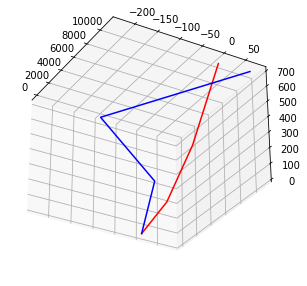

In [367]:
fig=plt.figure(figsize=(13,5))
ax = fig.gca(projection='3d')

X0=fin.y.T[0,[i for i in range(0,node_N)]]
Y0=fin.y.T[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin.y.T[0,[i for i in range(4*node_N,5*node_N)]]
X=fin.y.T[-1,[i for i in range(0,node_N)]]
Y=fin.y.T[-1,[i for i in range(2*node_N,3*node_N)]]
Z=fin.y.T[-1,[i for i in range(4*node_N,5*node_N)]]
# X0=x0
# Y0=[0 for i in range(node_N)]
# Z0=z0
# X=[fin[i] for i in range(0,node_N)]
# Y=[fin[i] for i in range(2*node_N,3*node_N)]
# Z=[fin[i] for i in range(4*node_N,5*node_N)]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [368]:
X,Y,Z

(array([    0.        ,  3692.60763842,  8757.81161414, 10976.83813936]),
 array([   0.        ,  -27.7947019 , -225.41194193,   75.67594133]),
 array([  0.        , 190.97003135, 241.9141619 , 714.36493364]))

In [369]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [ ]:
# E = 210e9

In [ ]:
# E*Ar

In [ ]:
# 1e10

In [ ]:
# import torch

In [ ]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [ ]:
# X

In [ ]:
# type(A)

In [ ]:
# X.shape

In [ ]:
# plot3D(fin, numDataPoints, FPS, filename, 3)